In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.init as init

import math

In [3]:
mg=pd.read_csv('mackeyglass.csv', names=['value'])

In [4]:
mg.values

array([[1.2   ],
       [1.1881],
       [1.1762],
       ...,
       [1.0346],
       [1.035 ],
       [1.0353]])

In [5]:
train_data=mg.values[0:15000]
test_data=mg.values[15000:20000]

In [79]:
train_x = torch.unsqueeze(torch.linspace(0,150,15000),1)
train_y = torch.from_numpy(train_data).type(torch.FloatTensor)
test_x = torch.unsqueeze(torch.linspace(150,200,5000),1)
test_y = torch.from_numpy(test_data).type(torch.FloatTensor)
torch_dataset = TensorDataset(data_tensor=train_x, target_tensor=train_y)

In [80]:
train_x, train_y

(
    0.0000
    0.0100
    0.0200
     ⋮     
  149.9800
  149.9900
  150.0000
 [torch.FloatTensor of size 15000x1], 
  1.2000
  1.1881
  1.1762
    ⋮    
  0.8771
  0.8828
  0.8884
 [torch.FloatTensor of size 15000x1])

In [81]:
data_loader=DataLoader(
            dataset=torch_dataset,      # torch TensorDataset format
            batch_size=200,              # mini batch size
            shuffle=True,               # 要不要打乱数据 (打乱比较好)
            num_workers=2,              # 多线程来读数据
        )

In [82]:
class Sin(torch.autograd.Function):

    def forward(self, input_):
#         self.save_for_backward(input_) 
        output = torch.sin(input_) 
        return output

    def backward(self, grad_output):  
        grad_input = grad_output.clone()
        return torch.cos(grad_input)

In [83]:
class MAPELoss(nn.Module):
    def forward(self,y_pred, y):
        mape=torch.mean(torch.abs(y-y_pred)/torch.clamp(torch.abs(y),max=float('inf'),min=1e-6))
        return mape


In [107]:
mysin = Sin()
class Net(nn.Module):
    def __init__(self, s, ns):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(1,s)
        self.layer2 = nn.Linear(1,ns)
        self.layer3 = nn.Linear(s,1,bias=False)
        self.layer4 = nn.Linear(ns,1,bias=False)
        
        # init
        for i in range(0, s):
            init.constant(self.layer1.weight[i], 2*math.pi*math.floor((i+1)/2))
            init.constant(self.layer1.bias[i], math.pi if i%2 != 0 else math.pi/2)
        init.constant(self.layer2.weight,1)
        init.constant(self.layer2.bias,0)
        init.constant(self.layer3.weight,0)
        init.constant(self.layer4.weight,0)
        
    def forward(self,x):
        su=mysin(self.layer1(x))
        nu=F.softplus(self.layer2(x))
        x=self.layer3(su)+self.layer4(nu)
        return x
        

In [108]:
net = Net(6,2)
print(net)

Net(
  (layer1): Linear(in_features=1, out_features=6, bias=True)
  (layer2): Linear(in_features=1, out_features=2, bias=True)
  (layer3): Linear(in_features=6, out_features=1, bias=False)
  (layer4): Linear(in_features=2, out_features=1, bias=False)
)


In [109]:
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = MAPELoss()
regularization = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
metric = nn.MSELoss()

In [110]:
for epoch in range(5000):   
    for step, (batch_x, batch_y) in enumerate(data_loader):
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
        optimizer.zero_grad()
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y) + regularization(Variable(net.layer3.weight.data), Variable(torch.zeros(6)))
        print("Train loss: ", loss.data[0])
#         print("Test loss:  ", loss)
        loss.backward()
        optimizer.step()
        

Train loss:  1.0
Train loss:  14.105892181396484
Train loss:  1.6012117862701416
Train loss:  13.248640060424805
Train loss:  2.7005116939544678
Train loss:  11.945073127746582
Train loss:  2.9496943950653076
Train loss:  11.865480422973633
Train loss:  2.649160623550415
Train loss:  12.073129653930664
Train loss:  1.4780744314193726
Train loss:  11.851974487304688
Train loss:  1.386786937713623
Train loss:  12.577825546264648
Train loss:  1.023919701576233
Train loss:  10.800877571105957
Train loss:  4.672221660614014
Train loss:  9.472837448120117
Train loss:  5.175573825836182
Train loss:  8.282737731933594
Train loss:  5.869517803192139
Train loss:  6.8919572830200195
Train loss:  6.228755950927734
Train loss:  6.325193405151367
Train loss:  7.472753047943115
Train loss:  6.2274088859558105
Train loss:  6.265468120574951
Train loss:  7.734109401702881
Train loss:  3.930602550506592
Train loss:  8.524669647216797
Train loss:  4.871594429016113
Train loss:  7.0399861335754395
Train l

Train loss:  1.3045495748519897
Train loss:  0.6329770684242249
Train loss:  1.1950018405914307
Train loss:  0.6589285731315613
Train loss:  1.044446587562561
Train loss:  0.7515153288841248
Train loss:  1.4733810424804688
Train loss:  0.5921745896339417
Train loss:  1.1769638061523438
Train loss:  0.5921006798744202
Train loss:  1.0392314195632935
Train loss:  0.6182186603546143
Train loss:  1.43533194065094
Train loss:  0.7122867107391357
Train loss:  1.286207914352417
Train loss:  0.5070319175720215
Train loss:  0.499336302280426
Train loss:  0.7353845238685608
Train loss:  1.2136931419372559
Train loss:  0.6424154043197632
Train loss:  1.1840566396713257
Train loss:  0.57053142786026
Train loss:  1.032151460647583
Train loss:  0.788266122341156
Train loss:  1.104259967803955
Train loss:  0.611273467540741
Train loss:  1.046165943145752
Train loss:  0.5773115158081055
Train loss:  0.7882919907569885
Train loss:  0.8593978881835938
Train loss:  1.1711751222610474
Train loss:  0.57882

Train loss:  0.46200889348983765
Train loss:  0.4972060024738312
Train loss:  0.5168725252151489
Train loss:  0.502315104007721
Train loss:  0.4490807354450226
Train loss:  0.4728114604949951
Train loss:  0.49702176451683044
Train loss:  0.47652116417884827
Train loss:  0.494134783744812
Train loss:  0.5146676301956177
Train loss:  0.47652673721313477
Train loss:  0.588159441947937
Train loss:  0.5907437205314636
Train loss:  0.5498614311218262
Train loss:  0.47095927596092224
Train loss:  0.5270172357559204
Train loss:  0.4800184965133667
Train loss:  0.5006084442138672
Train loss:  0.48386436700820923
Train loss:  0.43093618750572205
Train loss:  0.4690139591693878
Train loss:  0.44464412331581116
Train loss:  0.47223350405693054
Train loss:  0.47818616032600403
Train loss:  0.5165547728538513
Train loss:  0.4625706076622009
Train loss:  0.48002222180366516
Train loss:  0.5324283242225647
Train loss:  0.5315884351730347
Train loss:  0.47860005497932434
Train loss:  0.4511046111583709

Train loss:  0.5019842982292175
Train loss:  0.4696086645126343
Train loss:  0.4356943368911743
Train loss:  0.4416618347167969
Train loss:  0.4895187318325043
Train loss:  0.49076390266418457
Train loss:  0.47537603974342346
Train loss:  0.5273366570472717
Train loss:  0.5002531409263611
Train loss:  0.5166743993759155
Train loss:  0.4893397390842438
Train loss:  0.44776615500450134
Train loss:  0.45509886741638184
Train loss:  0.4555054306983948
Train loss:  0.46926286816596985
Train loss:  0.49896034598350525
Train loss:  0.4667966961860657
Train loss:  0.5474182963371277
Train loss:  0.4562831521034241
Train loss:  0.5023919343948364
Train loss:  0.485321968793869
Train loss:  0.4940560460090637
Train loss:  0.47740986943244934
Train loss:  0.4911470413208008
Train loss:  0.5163641571998596
Train loss:  0.4869209825992584
Train loss:  0.5406830906867981
Train loss:  0.5462234616279602
Train loss:  0.4894694983959198
Train loss:  0.46688491106033325
Train loss:  0.5100780725479126
T

Train loss:  0.4939168095588684
Train loss:  0.4723367691040039
Train loss:  0.5001698732376099
Train loss:  0.5339188575744629
Train loss:  0.5260202884674072
Train loss:  0.4769446551799774
Train loss:  0.4788600206375122
Train loss:  0.4661484360694885
Train loss:  0.4912337362766266
Train loss:  0.48001059889793396
Train loss:  0.44677793979644775
Train loss:  0.46934762597084045
Train loss:  0.4575105309486389
Train loss:  0.4739994704723358
Train loss:  0.5104342699050903
Train loss:  0.5100200772285461
Train loss:  0.4693426489830017
Train loss:  0.48875656723976135
Train loss:  0.4638404846191406
Train loss:  0.4665207862854004
Train loss:  0.4418999254703522
Train loss:  0.4854983985424042
Train loss:  0.43309077620506287
Train loss:  0.4843311011791229
Train loss:  0.48162806034088135
Train loss:  0.46944642066955566
Train loss:  0.4626285135746002
Train loss:  0.4512919783592224
Train loss:  0.4529620110988617
Train loss:  0.4633544087409973
Train loss:  0.5139094591140747
T

Train loss:  0.4568464457988739
Train loss:  0.5055643320083618
Train loss:  0.523507297039032
Train loss:  0.520175039768219
Train loss:  0.4583928883075714
Train loss:  0.4765477776527405
Train loss:  0.5300322771072388
Train loss:  0.4899061322212219
Train loss:  0.4697982370853424
Train loss:  0.4577611982822418
Train loss:  0.48997169733047485
Train loss:  0.45751965045928955
Train loss:  0.46749186515808105
Train loss:  0.4481707215309143
Train loss:  0.48336565494537354
Train loss:  0.4646832048892975
Train loss:  0.4849047064781189
Train loss:  0.5088990330696106
Train loss:  0.47177261114120483
Train loss:  0.47676971554756165
Train loss:  0.46282973885536194
Train loss:  0.48653849959373474
Train loss:  0.4520241618156433
Train loss:  0.4713056683540344
Train loss:  0.48381200432777405
Train loss:  0.4467000365257263
Train loss:  0.4269610643386841
Train loss:  0.48493045568466187
Train loss:  0.47813698649406433
Train loss:  0.46075817942619324
Train loss:  0.467826515436172

Train loss:  0.4621715247631073
Train loss:  0.4992167353630066
Train loss:  0.4828031361103058
Train loss:  0.47166338562965393
Train loss:  0.46418657898902893
Train loss:  0.46634364128112793
Train loss:  0.4435132145881653
Train loss:  0.47984758019447327
Train loss:  0.4766394793987274
Train loss:  0.4900411069393158
Train loss:  0.4381033480167389
Train loss:  0.46317487955093384
Train loss:  0.4392665922641754
Train loss:  0.4680487811565399
Train loss:  0.4389275908470154
Train loss:  0.515579104423523
Train loss:  0.5023751258850098
Train loss:  0.5404132604598999
Train loss:  0.4560655653476715
Train loss:  0.5589916706085205
Train loss:  0.4851053059101105
Train loss:  0.45176926255226135
Train loss:  0.4604456424713135
Train loss:  0.49116048216819763
Train loss:  0.4969630539417267
Train loss:  0.49156320095062256
Train loss:  0.4771006405353546
Train loss:  0.46170303225517273
Train loss:  0.47302475571632385
Train loss:  0.4666154086589813
Train loss:  0.5036668181419373

Train loss:  0.4860384166240692
Train loss:  0.4716043472290039
Train loss:  0.5007067322731018
Train loss:  0.4702078700065613
Train loss:  0.45454391837120056
Train loss:  0.45333606004714966
Train loss:  0.4482601583003998
Train loss:  0.4887535274028778
Train loss:  0.5151893496513367
Train loss:  0.4950152337551117
Train loss:  0.45173946022987366
Train loss:  0.5109153985977173
Train loss:  0.4580918848514557
Train loss:  0.4862327575683594
Train loss:  0.42403119802474976
Train loss:  0.464647501707077
Train loss:  0.4828840494155884
Train loss:  0.4468904435634613
Train loss:  0.4654187560081482
Train loss:  0.49221837520599365
Train loss:  0.5181795358657837
Train loss:  0.48151785135269165
Train loss:  0.49186187982559204
Train loss:  0.4539152979850769
Train loss:  0.45362842082977295
Train loss:  0.45416492223739624
Train loss:  0.45611417293548584
Train loss:  0.49883368611335754
Train loss:  0.4786714017391205
Train loss:  0.4512048065662384
Train loss:  0.445020258426666

Train loss:  0.47408607602119446
Train loss:  0.4620783030986786
Train loss:  0.48786455392837524
Train loss:  0.48922619223594666
Train loss:  0.48454514145851135
Train loss:  0.4549092948436737
Train loss:  0.48728930950164795
Train loss:  0.4957711696624756
Train loss:  0.4793649911880493
Train loss:  0.4715571701526642
Train loss:  0.4845152497291565
Train loss:  0.4822815954685211
Train loss:  0.5015091896057129
Train loss:  0.46070268750190735
Train loss:  0.4498068392276764
Train loss:  0.4154588580131531
Train loss:  0.5084837079048157
Train loss:  0.4555913209915161
Train loss:  0.4599657356739044
Train loss:  0.46595731377601624
Train loss:  0.48542463779449463
Train loss:  0.4375065863132477
Train loss:  0.4677251875400543
Train loss:  0.5059968829154968
Train loss:  0.44798943400382996
Train loss:  0.47884610295295715
Train loss:  0.45614486932754517
Train loss:  0.4466087520122528
Train loss:  0.46399185061454773
Train loss:  0.506462812423706
Train loss:  0.50060516595840

Train loss:  0.4400182366371155
Train loss:  0.47203174233436584
Train loss:  0.4920155704021454
Train loss:  0.44143766164779663
Train loss:  0.4807901680469513
Train loss:  0.4753864109516144
Train loss:  0.47401562333106995
Train loss:  0.44145286083221436
Train loss:  0.48964935541152954
Train loss:  0.4636916518211365
Train loss:  0.4951869249343872
Train loss:  0.4726516604423523
Train loss:  0.4878781735897064
Train loss:  0.4829223155975342
Train loss:  0.4710391163825989
Train loss:  0.48242974281311035
Train loss:  0.464842289686203
Train loss:  0.4962669610977173
Train loss:  0.47884029150009155
Train loss:  0.5126335620880127
Train loss:  0.5043150186538696
Train loss:  0.45700159668922424
Train loss:  0.4380725920200348
Train loss:  0.4762510359287262
Train loss:  0.46351176500320435
Train loss:  0.4704194962978363
Train loss:  0.4621739387512207
Train loss:  0.46636781096458435
Train loss:  0.468260258436203
Train loss:  0.46069014072418213
Train loss:  0.4741233289241791

Train loss:  0.45827755331993103
Train loss:  0.4627619981765747
Train loss:  0.4710192084312439
Train loss:  0.502678632736206
Train loss:  0.46412038803100586
Train loss:  0.47553983330726624
Train loss:  0.4733797609806061
Train loss:  0.46816182136535645
Train loss:  0.4740831255912781
Train loss:  0.45692870020866394
Train loss:  0.46308159828186035
Train loss:  0.44770878553390503
Train loss:  0.4560603201389313
Train loss:  0.45003554224967957
Train loss:  0.4713852107524872
Train loss:  0.48243027925491333
Train loss:  0.48682305216789246
Train loss:  0.49341732263565063
Train loss:  0.43402841687202454
Train loss:  0.4549252390861511
Train loss:  0.45024004578590393
Train loss:  0.4814847409725189
Train loss:  0.43008071184158325
Train loss:  0.46238914132118225
Train loss:  0.4917565584182739
Train loss:  0.4792764186859131
Train loss:  0.4490814507007599
Train loss:  0.45700520277023315
Train loss:  0.48188069462776184
Train loss:  0.4649824798107147
Train loss:  0.454757958

Train loss:  0.4558393359184265
Train loss:  0.5023249983787537
Train loss:  0.47514480352401733
Train loss:  0.48229873180389404
Train loss:  0.4921189844608307
Train loss:  0.4602937698364258
Train loss:  0.49669328331947327
Train loss:  0.4456920325756073
Train loss:  0.4388915002346039
Train loss:  0.4683569073677063
Train loss:  0.44386160373687744
Train loss:  0.4698294997215271
Train loss:  0.4842407703399658
Train loss:  0.4749900996685028
Train loss:  0.4592542052268982
Train loss:  0.45990216732025146
Train loss:  0.47068989276885986
Train loss:  0.4084371030330658
Train loss:  0.4678848385810852
Train loss:  0.5153915882110596
Train loss:  0.44400128722190857
Train loss:  0.49784713983535767
Train loss:  0.47461873292922974
Train loss:  0.4549766182899475
Train loss:  0.4620882272720337
Train loss:  0.4883320927619934
Train loss:  0.5094460248947144
Train loss:  0.4758113920688629
Train loss:  0.469879686832428
Train loss:  0.4588618874549866
Train loss:  0.46112683415412903

Train loss:  0.4782557487487793
Train loss:  0.5119077563285828
Train loss:  0.4493681490421295
Train loss:  0.4389747679233551
Train loss:  0.4453800320625305
Train loss:  0.47086453437805176
Train loss:  0.4440050721168518
Train loss:  0.4966531991958618
Train loss:  0.5244003534317017
Train loss:  0.4698077142238617
Train loss:  0.4875359833240509
Train loss:  0.49302998185157776
Train loss:  0.4864678978919983
Train loss:  0.4751032292842865
Train loss:  0.5031809210777283
Train loss:  0.46004238724708557
Train loss:  0.4968022108078003
Train loss:  0.517629086971283
Train loss:  0.43827351927757263
Train loss:  0.43764325976371765
Train loss:  0.4578838646411896
Train loss:  0.5062272548675537
Train loss:  0.43601250648498535
Train loss:  0.4779881238937378
Train loss:  0.4555191099643707
Train loss:  0.49178189039230347
Train loss:  0.5005640983581543
Train loss:  0.46398624777793884
Train loss:  0.5190184712409973
Train loss:  0.5027316212654114
Train loss:  0.4745466411113739
T

Train loss:  0.46971461176872253
Train loss:  0.42058664560317993
Train loss:  0.46135884523391724
Train loss:  0.5061987042427063
Train loss:  0.4982185363769531
Train loss:  0.5060696005821228
Train loss:  0.41661566495895386
Train loss:  0.43621504306793213
Train loss:  0.4599471986293793
Train loss:  0.485983669757843
Train loss:  0.48066502809524536
Train loss:  0.4818810224533081
Train loss:  0.47707176208496094
Train loss:  0.4905630648136139
Train loss:  0.4630591571331024
Train loss:  0.42694413661956787
Train loss:  0.49805745482444763
Train loss:  0.43483179807662964
Train loss:  0.5097613334655762
Train loss:  0.4449601173400879
Train loss:  0.4852823317050934
Train loss:  0.4885839819908142
Train loss:  0.44161808490753174
Train loss:  0.48540741205215454
Train loss:  0.43476244807243347
Train loss:  0.4533410966396332
Train loss:  0.4670173227787018
Train loss:  0.48602429032325745
Train loss:  0.48785218596458435
Train loss:  0.44565290212631226
Train loss:  0.4594927430

Train loss:  0.4859176576137543
Train loss:  0.4679814875125885
Train loss:  0.4742621183395386
Train loss:  0.46920958161354065
Train loss:  0.45859813690185547
Train loss:  0.47495949268341064
Train loss:  0.47796958684921265
Train loss:  0.49421927332878113
Train loss:  0.4723595976829529
Train loss:  0.4779405891895294
Train loss:  0.4932161867618561
Train loss:  0.45491623878479004
Train loss:  0.4675562381744385
Train loss:  0.48887792229652405
Train loss:  0.45374807715415955
Train loss:  0.4654856324195862
Train loss:  0.4792650043964386
Train loss:  0.4636155068874359
Train loss:  0.458347886800766
Train loss:  0.45436662435531616
Train loss:  0.45082759857177734
Train loss:  0.48728686571121216
Train loss:  0.488784521818161
Train loss:  0.49654245376586914
Train loss:  0.44235023856163025
Train loss:  0.5026423335075378
Train loss:  0.47689273953437805
Train loss:  0.4651789963245392
Train loss:  0.4320455491542816
Train loss:  0.4928532838821411
Train loss:  0.4552641212940

Train loss:  0.49124136567115784
Train loss:  0.4542568325996399
Train loss:  0.47946879267692566
Train loss:  0.46692025661468506
Train loss:  0.42569535970687866
Train loss:  0.49375414848327637
Train loss:  0.48969224095344543
Train loss:  0.4598546624183655
Train loss:  0.4922136962413788
Train loss:  0.4598950147628784
Train loss:  0.47948870062828064
Train loss:  0.4672854542732239
Train loss:  0.4669356644153595
Train loss:  0.4464503228664398
Train loss:  0.4826030731201172
Train loss:  0.47243979573249817
Train loss:  0.46976521611213684
Train loss:  0.48101606965065
Train loss:  0.4826149344444275
Train loss:  0.45391353964805603
Train loss:  0.485910564661026
Train loss:  0.48841211199760437
Train loss:  0.4669514298439026
Train loss:  0.4285719692707062
Train loss:  0.4912378191947937
Train loss:  0.4632662832736969
Train loss:  0.4609060287475586
Train loss:  0.4917694926261902
Train loss:  0.4807339012622833
Train loss:  0.46379390358924866
Train loss:  0.4606159925460815

Train loss:  0.4501883387565613
Train loss:  0.5314221382141113
Train loss:  0.48201873898506165
Train loss:  0.48461684584617615
Train loss:  0.43119993805885315
Train loss:  0.49906209111213684
Train loss:  0.4525425136089325
Train loss:  0.4709922969341278
Train loss:  0.47420790791511536
Train loss:  0.4400551915168762
Train loss:  0.47605952620506287
Train loss:  0.4895823895931244
Train loss:  0.4851458966732025
Train loss:  0.46665626764297485
Train loss:  0.44633519649505615
Train loss:  0.4854670464992523
Train loss:  0.4846755862236023
Train loss:  0.44167131185531616
Train loss:  0.4712664484977722
Train loss:  0.45279571413993835
Train loss:  0.5008139610290527
Train loss:  0.48139312863349915
Train loss:  0.4791354835033417
Train loss:  0.45031800866127014
Train loss:  0.4556979537010193
Train loss:  0.48407334089279175
Train loss:  0.47157031297683716
Train loss:  0.5021557807922363
Train loss:  0.44357872009277344
Train loss:  0.4206165075302124
Train loss:  0.4492437839

Train loss:  0.4831804037094116
Train loss:  0.48155006766319275
Train loss:  0.47901204228401184
Train loss:  0.4535258412361145
Train loss:  0.4543239176273346
Train loss:  0.4805402457714081
Train loss:  0.47113844752311707
Train loss:  0.49262702465057373
Train loss:  0.46835315227508545
Train loss:  0.47717225551605225
Train loss:  0.46334442496299744
Train loss:  0.4733659327030182
Train loss:  0.453180193901062
Train loss:  0.46741998195648193
Train loss:  0.46174168586730957
Train loss:  0.44501620531082153
Train loss:  0.49212968349456787
Train loss:  0.4561735987663269
Train loss:  0.4607861042022705
Train loss:  0.48185884952545166
Train loss:  0.46066778898239136
Train loss:  0.43787309527397156
Train loss:  0.499490886926651
Train loss:  0.5131237506866455
Train loss:  0.46612778306007385
Train loss:  0.4745790362358093
Train loss:  0.4738743305206299
Train loss:  0.42701518535614014
Train loss:  0.4811103343963623
Train loss:  0.4358915090560913
Train loss:  0.45406937599

Train loss:  0.47222837805747986
Train loss:  0.4206463396549225
Train loss:  0.45054852962493896
Train loss:  0.5034781694412231
Train loss:  0.461813360452652
Train loss:  0.4308621883392334
Train loss:  0.4559176564216614
Train loss:  0.4845985174179077
Train loss:  0.45495179295539856
Train loss:  0.4379557967185974
Train loss:  0.49094337224960327
Train loss:  0.488168865442276
Train loss:  0.4605109691619873
Train loss:  0.47085970640182495
Train loss:  0.43445804715156555
Train loss:  0.4956417679786682
Train loss:  0.4471328854560852
Train loss:  0.4502747058868408
Train loss:  0.4883090555667877
Train loss:  0.48651304841041565
Train loss:  0.43822646141052246
Train loss:  0.47604209184646606
Train loss:  0.46951067447662354
Train loss:  0.484663188457489
Train loss:  0.4429134428501129
Train loss:  0.44287508726119995
Train loss:  0.4533422887325287
Train loss:  0.5141820907592773
Train loss:  0.46938374638557434
Train loss:  0.46741393208503723
Train loss:  0.471551686525344

Train loss:  0.4290158748626709
Train loss:  0.4594552218914032
Train loss:  0.4929044544696808
Train loss:  0.4641588032245636
Train loss:  0.4603537917137146
Train loss:  0.42288652062416077
Train loss:  0.46882614493370056
Train loss:  0.46538954973220825
Train loss:  0.4654524028301239
Train loss:  0.4957170784473419
Train loss:  0.45312613248825073
Train loss:  0.48173871636390686
Train loss:  0.47202882170677185
Train loss:  0.44518914818763733
Train loss:  0.496404767036438
Train loss:  0.4621585011482239
Train loss:  0.4600946605205536
Train loss:  0.45754510164260864
Train loss:  0.501288890838623
Train loss:  0.4698435068130493
Train loss:  0.46019116044044495
Train loss:  0.4507502019405365
Train loss:  0.43059420585632324
Train loss:  0.4574791193008423
Train loss:  0.4908164441585541
Train loss:  0.44280123710632324
Train loss:  0.45792415738105774
Train loss:  0.43775689601898193
Train loss:  0.4577512741088867
Train loss:  0.4520537555217743
Train loss:  0.48036220669746

Train loss:  0.4589768946170807
Train loss:  0.4665271043777466
Train loss:  0.47814440727233887
Train loss:  0.43262311816215515
Train loss:  0.45601460337638855
Train loss:  0.45605289936065674
Train loss:  0.45711416006088257
Train loss:  0.49372172355651855
Train loss:  0.4612961709499359
Train loss:  0.44763511419296265
Train loss:  0.48731324076652527
Train loss:  0.44769421219825745
Train loss:  0.4639110565185547
Train loss:  0.4830958843231201
Train loss:  0.4206808805465698
Train loss:  0.4665544033050537
Train loss:  0.45420408248901367
Train loss:  0.45061740279197693
Train loss:  0.4379894435405731
Train loss:  0.4292404353618622
Train loss:  0.5019721388816833
Train loss:  0.46639224886894226
Train loss:  0.4592178165912628
Train loss:  0.4543818533420563
Train loss:  0.4587613642215729
Train loss:  0.44430840015411377
Train loss:  0.4919232130050659
Train loss:  0.46267959475517273
Train loss:  0.4262721836566925
Train loss:  0.4508579969406128
Train loss:  0.45781192183

Train loss:  0.43693095445632935
Train loss:  0.4302210807800293
Train loss:  0.42468878626823425
Train loss:  0.434165358543396
Train loss:  0.4073520004749298
Train loss:  0.46350380778312683
Train loss:  0.4601907730102539
Train loss:  0.4195210635662079
Train loss:  0.4069558084011078
Train loss:  0.45727214217185974
Train loss:  0.43996965885162354
Train loss:  0.38902750611305237
Train loss:  0.4220612645149231
Train loss:  0.4154951870441437
Train loss:  0.4251154661178589
Train loss:  0.41555750370025635
Train loss:  0.40696480870246887
Train loss:  0.44337570667266846
Train loss:  0.4327482283115387
Train loss:  0.39619308710098267
Train loss:  0.39460256695747375
Train loss:  0.4261934757232666
Train loss:  0.40291839838027954
Train loss:  0.38815250992774963
Train loss:  0.42745232582092285
Train loss:  0.47269588708877563
Train loss:  0.4469192326068878
Train loss:  0.4315355718135834
Train loss:  0.4417400360107422
Train loss:  0.41197213530540466
Train loss:  0.3886244893

Train loss:  0.3663625121116638
Train loss:  0.3588779866695404
Train loss:  0.42474624514579773
Train loss:  0.4026450514793396
Train loss:  0.37438657879829407
Train loss:  0.37352102994918823
Train loss:  0.3594692349433899
Train loss:  0.3705073893070221
Train loss:  0.4029608964920044
Train loss:  0.39093077182769775
Train loss:  0.3585568070411682
Train loss:  0.3859323561191559
Train loss:  0.35751110315322876
Train loss:  0.3586237132549286
Train loss:  0.35316532850265503
Train loss:  0.36854150891304016
Train loss:  0.3846321403980255
Train loss:  0.38838788866996765
Train loss:  0.370184987783432
Train loss:  0.357133686542511
Train loss:  0.33087682723999023
Train loss:  0.39155253767967224
Train loss:  0.40900692343711853
Train loss:  0.358634352684021
Train loss:  0.3883965313434601
Train loss:  0.3843645751476288
Train loss:  0.3684871196746826
Train loss:  0.37890204787254333
Train loss:  0.3983079493045807
Train loss:  0.365495890378952
Train loss:  0.4010818600654602


Train loss:  0.36240649223327637
Train loss:  0.3863036632537842
Train loss:  0.4151853621006012
Train loss:  0.40080875158309937
Train loss:  0.4012293219566345
Train loss:  0.3925458788871765
Train loss:  0.34169772267341614
Train loss:  0.3508005738258362
Train loss:  0.33424264192581177
Train loss:  0.3327448070049286
Train loss:  0.4128042459487915
Train loss:  0.35768455266952515
Train loss:  0.36670565605163574
Train loss:  0.35065698623657227
Train loss:  0.44518736004829407
Train loss:  0.391312837600708
Train loss:  0.3270968198776245
Train loss:  0.3636477291584015
Train loss:  0.2918796241283417
Train loss:  0.35210826992988586
Train loss:  0.3626532256603241
Train loss:  0.33018723130226135
Train loss:  0.29771265387535095
Train loss:  0.3225637674331665
Train loss:  0.3304138779640198
Train loss:  0.35351452231407166
Train loss:  0.3592887222766876
Train loss:  0.41081565618515015
Train loss:  0.4599335491657257
Train loss:  0.44409751892089844
Train loss:  0.347945749759

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3d2f466a58>>


Train loss:  0.3626464605331421


Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().auth

Train loss:  0.31831657886505127
Train loss:  0.34636276960372925
Train loss:  0.34711509943008423
Train loss:  0.3572174906730652
Train loss:  0.3309095501899719
Train loss:  0.30763164162635803
Train loss:  0.34733277559280396
Train loss:  0.38034504652023315
Train loss:  0.3400273621082306
Train loss:  0.3448619544506073
Train loss:  0.3634161353111267
Train loss:  0.31622809171676636
Train loss:  0.32519322633743286
Train loss:  0.33141854405403137
Train loss:  0.3309074640274048
Train loss:  0.340302437543869
Train loss:  0.3327248692512512
Train loss:  0.32426750659942627
Train loss:  0.3967088758945465
Train loss:  0.3739258050918579
Train loss:  0.38694924116134644
Train loss:  0.3671829104423523
Train loss:  0.3486747443675995
Train loss:  0.3704908490180969
Train loss:  0.31285223364830017
Train loss:  0.3284192979335785
Train loss:  0.33795684576034546
Train loss:  0.32289648056030273
Train loss:  0.317380428314209
Train loss:  0.3411025106906891
Train loss:  0.3577145040035

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3d2f466a58>>
Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/xurenchao/install/anaconda3/lib/pyt

Train loss:  0.40437188744544983
Train loss:  0.3925215005874634
Train loss:  0.4039752781391144
Train loss:  0.41729190945625305
Train loss:  0.3356951177120209
Train loss:  0.35561084747314453
Train loss:  0.31882819533348083
Train loss:  0.3169334828853607
Train loss:  0.3362843692302704
Train loss:  0.32188770174980164
Train loss:  0.3343755900859833
Train loss:  0.3667963445186615
Train loss:  0.38794049620628357
Train loss:  0.41513240337371826
Train loss:  0.42147326469421387
Train loss:  0.4286832809448242
Train loss:  0.3587014973163605
Train loss:  0.3739931881427765
Train loss:  0.3468450605869293
Train loss:  0.3398674428462982
Train loss:  0.3871174156665802
Train loss:  0.3946612775325775
Train loss:  0.36085814237594604
Train loss:  0.3300621211528778
Train loss:  0.3522932231426239
Train loss:  0.388923317193985
Train loss:  0.3030252158641815
Train loss:  0.3442210853099823
Train loss:  0.33121076226234436
Train loss:  0.3131444454193115
Train loss:  0.3771533071994781

Train loss:  0.3857378363609314
Train loss:  0.3304164707660675
Train loss:  0.39521241188049316
Train loss:  0.34466230869293213
Train loss:  0.35318127274513245
Train loss:  0.3435138463973999
Train loss:  0.38380011916160583
Train loss:  0.3775859475135803
Train loss:  0.47154003381729126
Train loss:  0.32455897331237793
Train loss:  0.37593552470207214
Train loss:  0.4362730383872986
Train loss:  0.4902598261833191
Train loss:  0.32814517617225647
Train loss:  0.35927847027778625
Train loss:  0.3953890800476074
Train loss:  0.43701106309890747
Train loss:  0.3425375819206238
Train loss:  0.44162169098854065
Train loss:  0.4269925653934479
Train loss:  0.41568267345428467
Train loss:  0.3099845349788666
Train loss:  0.43939271569252014
Train loss:  0.37999671697616577
Train loss:  0.4481871426105499
Train loss:  0.38465142250061035
Train loss:  0.49235770106315613
Train loss:  0.2820081412792206
Train loss:  0.2960204780101776
Train loss:  0.3817903995513916
Train loss:  0.422231405

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3d2f466a58>>
Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/xurenchao/install/anaconda3/lib/pyt

Train loss:  0.39527568221092224
Train loss:  0.4847027063369751
Train loss:  0.3064614534378052
Train loss:  0.3148452937602997
Train loss:  0.29650118947029114
Train loss:  0.2947803735733032
Train loss:  0.31246763467788696
Train loss:  0.31815364956855774
Train loss:  0.3253987729549408
Train loss:  0.2970552444458008
Train loss:  0.29093772172927856
Train loss:  0.3093113899230957
Train loss:  0.36632993817329407
Train loss:  0.4364672005176544
Train loss:  0.30561473965644836
Train loss:  0.32921499013900757
Train loss:  0.3335810899734497
Train loss:  0.3789710998535156
Train loss:  0.3892563283443451
Train loss:  0.4781263470649719
Train loss:  0.35186123847961426
Train loss:  0.45944032073020935
Train loss:  0.33313319087028503
Train loss:  0.41141843795776367
Train loss:  0.3974081873893738
Train loss:  0.5355473756790161
Train loss:  0.29567205905914307
Train loss:  0.29739394783973694
Train loss:  0.28438422083854675
Train loss:  0.27010059356689453
Train loss:  0.298933029

Train loss:  0.5651077032089233
Train loss:  0.2779848277568817
Train loss:  0.3904827833175659
Train loss:  0.510432779788971
Train loss:  0.3037260174751282
Train loss:  0.31522420048713684
Train loss:  0.30687829852104187
Train loss:  0.29908305406570435
Train loss:  0.32700401544570923
Train loss:  0.4601303040981293
Train loss:  0.5230921506881714
Train loss:  0.2932452857494354
Train loss:  0.28064489364624023
Train loss:  0.34476932883262634
Train loss:  0.41807645559310913
Train loss:  0.38878944516181946
Train loss:  0.49483242630958557
Train loss:  0.2840448319911957
Train loss:  0.29022401571273804
Train loss:  0.30235812067985535
Train loss:  0.35642826557159424
Train loss:  0.4718456566333771
Train loss:  0.5377514958381653
Train loss:  0.3036506175994873
Train loss:  0.29919421672821045
Train loss:  0.29784393310546875
Train loss:  0.3226653039455414
Train loss:  0.2996564507484436
Train loss:  0.29340219497680664
Train loss:  0.336966872215271
Train loss:  0.487991601228

Train loss:  0.42482876777648926
Train loss:  0.5352131128311157
Train loss:  0.2754124104976654
Train loss:  0.26708388328552246
Train loss:  0.3999919295310974
Train loss:  0.5505051612854004
Train loss:  0.29151463508605957
Train loss:  0.27248480916023254
Train loss:  0.2775057256221771
Train loss:  0.33568888902664185
Train loss:  0.3017064034938812
Train loss:  0.4288702607154846
Train loss:  0.32824307680130005
Train loss:  0.48267775774002075
Train loss:  0.29318946599960327
Train loss:  0.2884381115436554
Train loss:  0.3327293395996094
Train loss:  0.4020159840583801
Train loss:  0.3608487546443939
Train loss:  0.5159034729003906
Train loss:  0.2621050179004669
Train loss:  0.3657992482185364
Train loss:  0.5330001711845398
Train loss:  0.2700863778591156
Train loss:  0.2884467542171478
Train loss:  0.28514906764030457
Train loss:  0.2838868796825409
Train loss:  0.30752843618392944
Train loss:  0.2660975754261017
Train loss:  0.2657242715358734
Train loss:  0.365880608558654

Train loss:  0.27376022934913635
Train loss:  0.3185019791126251
Train loss:  0.38994160294532776
Train loss:  0.549164891242981
Train loss:  0.27770382165908813
Train loss:  0.31737837195396423
Train loss:  0.5026937127113342
Train loss:  0.33545398712158203
Train loss:  0.3519865870475769
Train loss:  0.36483198404312134
Train loss:  0.6005082130432129
Train loss:  0.3202892541885376
Train loss:  0.3893665671348572
Train loss:  0.4464264214038849
Train loss:  0.4273110628128052
Train loss:  0.5914854407310486
Train loss:  0.34408482909202576
Train loss:  0.41059184074401855
Train loss:  0.4783414900302887
Train loss:  0.25924062728881836
Train loss:  0.2875610291957855
Train loss:  0.26312124729156494
Train loss:  0.3088085651397705
Train loss:  0.3063531517982483
Train loss:  0.4061203896999359
Train loss:  0.356038361787796
Train loss:  0.5270682573318481
Train loss:  0.24450631439685822
Train loss:  0.2737310230731964
Train loss:  0.3597749173641205
Train loss:  0.4617552459239959

Train loss:  0.45600995421409607
Train loss:  0.30068618059158325
Train loss:  0.49727970361709595
Train loss:  0.22158890962600708
Train loss:  0.2878009080886841
Train loss:  0.3410409390926361
Train loss:  0.4527152478694916
Train loss:  0.6157194375991821
Train loss:  0.4612397849559784
Train loss:  0.2796104848384857
Train loss:  0.30681779980659485
Train loss:  0.31537121534347534
Train loss:  0.4954586327075958
Train loss:  0.270961195230484
Train loss:  0.2466108351945877
Train loss:  0.25926288962364197
Train loss:  0.318716824054718
Train loss:  0.46632370352745056
Train loss:  0.6092238426208496
Train loss:  0.3931465148925781
Train loss:  0.38076213002204895
Train loss:  0.5790650844573975
Train loss:  0.3291594684123993
Train loss:  0.4534410834312439
Train loss:  0.6149255633354187
Train loss:  0.362713485956192
Train loss:  0.403643399477005
Train loss:  0.5495114922523499
Train loss:  0.2805182933807373
Train loss:  0.2594318985939026
Train loss:  0.2773752510547638
Tra

Train loss:  0.42413049936294556
Train loss:  0.5646193027496338
Train loss:  0.30233514308929443
Train loss:  0.3410961329936981
Train loss:  0.5707456469535828
Train loss:  0.33649933338165283
Train loss:  0.4825686514377594
Train loss:  0.6037882566452026
Train loss:  0.3755567669868469
Train loss:  0.5583114624023438
Train loss:  0.6269755363464355
Train loss:  0.4638010859489441
Train loss:  0.27246206998825073
Train loss:  0.357077032327652
Train loss:  0.4252936840057373
Train loss:  0.6406832933425903
Train loss:  0.43201106786727905
Train loss:  0.38507750630378723
Train loss:  0.6297968626022339
Train loss:  0.43742889165878296
Train loss:  0.3739352822303772
Train loss:  0.5895916223526001
Train loss:  0.32702192664146423
Train loss:  0.43181312084198
Train loss:  0.5933606624603271
Train loss:  0.33523163199424744
Train loss:  0.37628796696662903
Train loss:  0.6067827343940735
Train loss:  0.35454705357551575
Train loss:  0.38723716139793396
Train loss:  0.6206650733947754

Train loss:  0.4441909193992615
Train loss:  0.5325696468353271
Train loss:  0.3279916048049927
Train loss:  0.4856451153755188
Train loss:  0.6026269793510437
Train loss:  0.42026689648628235
Train loss:  0.35319197177886963
Train loss:  0.569426953792572
Train loss:  0.2756474018096924
Train loss:  0.2949475347995758
Train loss:  0.37604016065597534
Train loss:  0.40075260400772095
Train loss:  0.5520849227905273
Train loss:  0.2726067006587982
Train loss:  0.43996113538742065
Train loss:  0.614616334438324
Train loss:  0.3744582533836365
Train loss:  0.44422659277915955
Train loss:  0.6215538382530212
Train loss:  0.41698381304740906
Train loss:  0.31419315934181213
Train loss:  0.5082902312278748
Train loss:  0.25920525193214417
Train loss:  0.26758652925491333
Train loss:  0.23339147865772247
Train loss:  0.26613733172416687
Train loss:  0.3048734962940216
Train loss:  0.5197131633758545
Train loss:  0.2473158836364746
Train loss:  0.3253779113292694
Train loss:  0.464496135711669

Train loss:  0.6319853663444519
Train loss:  0.4209631085395813
Train loss:  0.37051844596862793
Train loss:  0.6073158979415894
Train loss:  0.2945129871368408
Train loss:  0.3117794394493103
Train loss:  0.49908360838890076
Train loss:  0.2673802077770233
Train loss:  0.2654160261154175
Train loss:  0.2656348645687103
Train loss:  0.2481985092163086
Train loss:  0.2849406898021698
Train loss:  0.2591184079647064
Train loss:  0.26535743474960327
Train loss:  0.23724201321601868
Train loss:  0.27114784717559814
Train loss:  0.26932257413864136
Train loss:  0.3770439326763153
Train loss:  0.5768542289733887
Train loss:  0.3043634295463562
Train loss:  0.5066849589347839
Train loss:  0.6317376494407654
Train loss:  0.48500996828079224
Train loss:  0.2867443859577179
Train loss:  0.33403506875038147
Train loss:  0.4691963493824005
Train loss:  0.6073764562606812
Train loss:  0.3862886428833008
Train loss:  0.5033650994300842
Train loss:  0.6177661418914795
Train loss:  0.5044581890106201


Train loss:  0.2500913143157959
Train loss:  0.282249391078949
Train loss:  0.26666682958602905
Train loss:  0.4297536015510559
Train loss:  0.36004310846328735
Train loss:  0.5805906057357788
Train loss:  0.31466975808143616
Train loss:  0.44319504499435425
Train loss:  0.5663233399391174
Train loss:  0.3662227988243103
Train loss:  0.4985542893409729
Train loss:  0.6351869702339172
Train loss:  0.46116742491722107
Train loss:  0.3237805664539337
Train loss:  0.577345609664917
Train loss:  0.29120388627052307
Train loss:  0.2758808732032776
Train loss:  0.35965725779533386
Train loss:  0.3928781747817993
Train loss:  0.5847154259681702
Train loss:  0.3408762514591217
Train loss:  0.38931912183761597
Train loss:  0.5728687644004822
Train loss:  0.3021585941314697
Train loss:  0.5259531736373901
Train loss:  0.6674560904502869
Train loss:  0.5625868439674377
Train loss:  0.2792670428752899
Train loss:  0.34453240036964417
Train loss:  0.45129239559173584
Train loss:  0.26750895380973816

Train loss:  0.4475865960121155
Train loss:  0.3461642861366272
Train loss:  0.5554031729698181
Train loss:  0.28106388449668884
Train loss:  0.40898996591567993
Train loss:  0.6297374963760376
Train loss:  0.4664548933506012
Train loss:  0.27355891466140747
Train loss:  0.32826048135757446
Train loss:  0.41445180773735046
Train loss:  0.5978904962539673
Train loss:  0.4336184561252594
Train loss:  0.44989174604415894
Train loss:  0.6034809350967407
Train loss:  0.43629583716392517
Train loss:  0.3625483512878418
Train loss:  0.5893179178237915
Train loss:  0.30087846517562866
Train loss:  0.3894171118736267
Train loss:  0.6138108968734741
Train loss:  0.3794405162334442
Train loss:  0.377470463514328
Train loss:  0.5651050209999084
Train loss:  0.30942198634147644
Train loss:  0.614363968372345
Train loss:  0.686528205871582
Train loss:  0.5420544147491455
Train loss:  0.3391973674297333
Train loss:  0.5862902402877808
Train loss:  0.6195737719535828
Train loss:  0.4428592920303345
Tr

Train loss:  0.3648311197757721
Train loss:  0.32739055156707764
Train loss:  0.6122060418128967
Train loss:  0.39993157982826233
Train loss:  0.3482147753238678
Train loss:  0.5620752573013306
Train loss:  0.29581916332244873
Train loss:  0.3841554522514343
Train loss:  0.5717973709106445
Train loss:  0.32290688157081604
Train loss:  0.455746591091156
Train loss:  0.6042138934135437
Train loss:  0.32901084423065186
Train loss:  0.3997730612754822
Train loss:  0.6184154748916626
Train loss:  0.3859240710735321
Train loss:  0.3287872076034546
Train loss:  0.5114807486534119
Train loss:  0.273716539144516
Train loss:  0.29614871740341187
Train loss:  0.45728355646133423
Train loss:  0.2894231975078583
Train loss:  0.3811568319797516
Train loss:  0.4316319525241852
Train loss:  0.6169028878211975
Train loss:  0.5116519927978516
Train loss:  0.25905996561050415
Train loss:  0.3015185594558716
Train loss:  0.34966719150543213
Train loss:  0.601889431476593
Train loss:  0.4511033296585083
Tr

Train loss:  0.4952142536640167
Train loss:  0.2638096809387207
Train loss:  0.2797907888889313
Train loss:  0.5218501687049866
Train loss:  0.6629742980003357
Train loss:  0.5429295897483826
Train loss:  0.34221383929252625
Train loss:  0.4634045958518982
Train loss:  0.6164839863777161
Train loss:  0.44626736640930176
Train loss:  0.4098920226097107
Train loss:  0.6013056039810181
Train loss:  0.42325326800346375
Train loss:  0.3517565131187439
Train loss:  0.5641165971755981
Train loss:  0.3390950560569763
Train loss:  0.38409698009490967
Train loss:  0.5963614583015442
Train loss:  0.38578012585639954
Train loss:  0.4114362299442291
Train loss:  0.6541085839271545
Train loss:  0.4611535370349884
Train loss:  0.2803885042667389
Train loss:  0.3512750267982483
Train loss:  0.4080755114555359
Train loss:  0.639844536781311
Train loss:  0.5001233220100403
Train loss:  0.27062857151031494
Train loss:  0.3175826966762543
Train loss:  0.33773016929626465
Train loss:  0.5658244490623474
Tr

Train loss:  0.3219922184944153
Train loss:  0.4350832402706146
Train loss:  0.6378623843193054
Train loss:  0.45977982878685
Train loss:  0.31564173102378845
Train loss:  0.396814227104187
Train loss:  0.3814725875854492
Train loss:  0.5767714381217957
Train loss:  0.3792266845703125
Train loss:  0.39270246028900146
Train loss:  0.583615779876709
Train loss:  0.35547253489494324
Train loss:  0.5205069780349731
Train loss:  0.6325953006744385
Train loss:  0.47279030084609985
Train loss:  0.2947472035884857
Train loss:  0.4451083540916443
Train loss:  0.2759719491004944
Train loss:  0.35084882378578186
Train loss:  0.373995840549469
Train loss:  0.582582414150238
Train loss:  0.3103809952735901
Train loss:  0.5320835113525391
Train loss:  0.6070172190666199
Train loss:  0.5124006867408752
Train loss:  0.3126358091831207
Train loss:  0.42561793327331543
Train loss:  0.3045230805873871
Train loss:  0.4966098964214325
Train loss:  0.26201802492141724
Train loss:  0.34785762429237366
Train 

Train loss:  0.49072951078414917
Train loss:  0.31672772765159607
Train loss:  0.4682142734527588
Train loss:  0.27267614006996155
Train loss:  0.3162182867527008
Train loss:  0.4550226330757141
Train loss:  0.604565441608429
Train loss:  0.3795619308948517
Train loss:  0.4335479736328125
Train loss:  0.6712737083435059
Train loss:  0.48304957151412964
Train loss:  0.27625271677970886
Train loss:  0.2651517987251282
Train loss:  0.32128074765205383
Train loss:  0.5055993795394897
Train loss:  0.25759458541870117
Train loss:  0.27045848965644836
Train loss:  0.3623577356338501
Train loss:  0.4708205461502075
Train loss:  0.6213106513023376
Train loss:  0.4216897785663605
Train loss:  0.3217991590499878
Train loss:  0.5202031135559082
Train loss:  0.27730637788772583
Train loss:  0.2548728287220001
Train loss:  0.26857244968414307
Train loss:  0.35995662212371826
Train loss:  0.5612785816192627
Train loss:  0.31990090012550354
Train loss:  0.44154277443885803
Train loss:  0.6473596692085

Train loss:  0.2769048810005188
Train loss:  0.3422635495662689
Train loss:  0.5663833022117615
Train loss:  0.2966069281101227
Train loss:  0.4592427909374237
Train loss:  0.6056764721870422
Train loss:  0.42849791049957275
Train loss:  0.4611530005931854
Train loss:  0.6364317536354065
Train loss:  0.453927218914032
Train loss:  0.3103198707103729
Train loss:  0.3864375054836273
Train loss:  0.40123409032821655
Train loss:  0.6437548398971558
Train loss:  0.40008190274238586
Train loss:  0.3447851538658142
Train loss:  0.5635948777198792
Train loss:  0.2751237750053406
Train loss:  0.3893676698207855
Train loss:  0.6027562022209167
Train loss:  0.4437732398509979
Train loss:  0.3777766227722168
Train loss:  0.4924817681312561
Train loss:  0.26424261927604675
Train loss:  0.25337469577789307
Train loss:  0.25246837735176086
Train loss:  0.27215394377708435
Train loss:  0.2391400933265686
Train loss:  0.2705742120742798
Train loss:  0.3051198422908783
Train loss:  0.5002966523170471
Tr

Train loss:  0.3954044580459595
Train loss:  0.36769065260887146
Train loss:  0.5627731680870056
Train loss:  0.3166930079460144
Train loss:  0.489137202501297
Train loss:  0.6019705533981323
Train loss:  0.395836740732193
Train loss:  0.4107382893562317
Train loss:  0.6055838465690613
Train loss:  0.36306485533714294
Train loss:  0.4038577675819397
Train loss:  0.654018759727478
Train loss:  0.4089454412460327
Train loss:  0.329629510641098
Train loss:  0.5296342372894287
Train loss:  0.27730411291122437
Train loss:  0.2968532145023346
Train loss:  0.3618929386138916
Train loss:  0.48721539974212646
Train loss:  0.5898070931434631
Train loss:  0.4836199879646301
Train loss:  0.3025994896888733
Train loss:  0.34566277265548706
Train loss:  0.30318936705589294
Train loss:  0.5206592082977295
Train loss:  0.268011212348938
Train loss:  0.29235273599624634
Train loss:  0.4617444574832916
Train loss:  0.6214125752449036
Train loss:  0.4161417484283447
Train loss:  0.4225146472454071
Train 

Train loss:  0.27558279037475586
Train loss:  0.27147379517555237
Train loss:  0.38902178406715393
Train loss:  0.3939513564109802
Train loss:  0.6259303689002991
Train loss:  0.4556138217449188
Train loss:  0.40279582142829895
Train loss:  0.604806661605835
Train loss:  0.4463196396827698
Train loss:  0.3200388550758362
Train loss:  0.5278322100639343
Train loss:  0.2828579246997833
Train loss:  0.34341055154800415
Train loss:  0.5221132636070251
Train loss:  0.27190691232681274
Train loss:  0.2901015281677246
Train loss:  0.4531881511211395
Train loss:  0.2833746075630188
Train loss:  0.46220141649246216
Train loss:  0.28488975763320923
Train loss:  0.3005978465080261
Train loss:  0.4616689085960388
Train loss:  0.644294798374176
Train loss:  0.43382835388183594
Train loss:  0.387298047542572
Train loss:  0.6058127880096436
Train loss:  0.3816468119621277
Train loss:  0.3810805082321167
Train loss:  0.5762490630149841
Train loss:  0.40763700008392334
Train loss:  0.3594116270542145
T

Train loss:  0.5859768390655518
Train loss:  0.6625000238418579
Train loss:  0.5050997734069824
Train loss:  0.25448691844940186
Train loss:  0.2606007158756256
Train loss:  0.2817888855934143
Train loss:  0.2915123403072357
Train loss:  0.2697905898094177
Train loss:  0.24426306784152985
Train loss:  0.24551814794540405
Train loss:  0.2879568338394165
Train loss:  0.315682590007782
Train loss:  0.5959169864654541
Train loss:  0.6155987977981567
Train loss:  0.43223926424980164
Train loss:  0.33960074186325073
Train loss:  0.5230013132095337
Train loss:  0.24940171837806702
Train loss:  0.2793620228767395
Train loss:  0.457131028175354
Train loss:  0.2844601571559906
Train loss:  0.4103735387325287
Train loss:  0.41294267773628235
Train loss:  0.6110096573829651
Train loss:  0.40082377195358276
Train loss:  0.30124250054359436
Train loss:  0.5485409498214722
Train loss:  0.27592045068740845
Train loss:  0.38543975353240967
Train loss:  0.5940690040588379
Train loss:  0.4021044969558716

Train loss:  0.4852948486804962
Train loss:  0.26435574889183044
Train loss:  0.2786978781223297
Train loss:  0.2989516258239746
Train loss:  0.4168028235435486
Train loss:  0.632266640663147
Train loss:  0.4367351830005646
Train loss:  0.3698844611644745
Train loss:  0.58127760887146
Train loss:  0.3758685886859894
Train loss:  0.5295167565345764
Train loss:  0.6499060988426208
Train loss:  0.4871772527694702
Train loss:  0.2747907340526581
Train loss:  0.2571394741535187
Train loss:  0.2767758369445801
Train loss:  0.2697158455848694
Train loss:  0.25556623935699463
Train loss:  0.3009722828865051
Train loss:  0.5821641683578491
Train loss:  0.6539804935455322
Train loss:  0.5043941736221313
Train loss:  0.26499366760253906
Train loss:  0.28301483392715454
Train loss:  0.40951260924339294
Train loss:  0.3330114185810089
Train loss:  0.5676833391189575
Train loss:  0.2953924238681793
Train loss:  0.3919500708580017
Train loss:  0.5606094002723694
Train loss:  0.2974582612514496
Train 

Train loss:  0.2937409281730652
Train loss:  0.39517897367477417
Train loss:  0.42868441343307495
Train loss:  0.6479312181472778
Train loss:  0.49746784567832947
Train loss:  0.2596522569656372
Train loss:  0.24863457679748535
Train loss:  0.2607831656932831
Train loss:  0.36935439705848694
Train loss:  0.4639512896537781
Train loss:  0.5875322818756104
Train loss:  0.3172329366207123
Train loss:  0.48400405049324036
Train loss:  0.6367242932319641
Train loss:  0.44034305214881897
Train loss:  0.2933795750141144
Train loss:  0.4202210009098053
Train loss:  0.289754718542099
Train loss:  0.4656643271446228
Train loss:  0.2859971523284912
Train loss:  0.3486383557319641
Train loss:  0.502367377281189
Train loss:  0.6050682067871094
Train loss:  0.3969367742538452
Train loss:  0.2912387251853943
Train loss:  0.46776577830314636
Train loss:  0.2898065149784088
Train loss:  0.4490824341773987
Train loss:  0.38111573457717896
Train loss:  0.5508118271827698
Train loss:  0.2618400454521179
T

Train loss:  0.39174923300743103
Train loss:  0.5500231385231018
Train loss:  0.3128436505794525
Train loss:  0.40228721499443054
Train loss:  0.662564218044281
Train loss:  0.4563431441783905
Train loss:  0.2722395360469818
Train loss:  0.3395279347896576
Train loss:  0.4286603331565857
Train loss:  0.6471119523048401
Train loss:  0.5235192775726318
Train loss:  0.2842079699039459
Train loss:  0.39794135093688965
Train loss:  0.674534261226654
Train loss:  0.4818371832370758
Train loss:  0.25424814224243164
Train loss:  0.26085102558135986
Train loss:  0.3102823793888092
Train loss:  0.5825104117393494
Train loss:  0.2857901155948639
Train loss:  0.3478740155696869
Train loss:  0.5634564757347107
Train loss:  0.3257604241371155
Train loss:  0.38693445920944214
Train loss:  0.585093080997467
Train loss:  0.3222406208515167
Train loss:  0.402659147977829
Train loss:  0.5804160237312317
Train loss:  0.3638596832752228
Train loss:  0.5093804001808167
Train loss:  0.5730094909667969
Train 

Train loss:  0.5657655596733093
Train loss:  0.3670015335083008
Train loss:  0.35812899470329285
Train loss:  0.5669782161712646
Train loss:  0.32304254174232483
Train loss:  0.29101425409317017
Train loss:  0.4218885600566864
Train loss:  0.3968620002269745
Train loss:  0.6725539565086365
Train loss:  0.49086204171180725
Train loss:  0.23675644397735596
Train loss:  0.24375402927398682
Train loss:  0.2729857265949249
Train loss:  0.3829995393753052
Train loss:  0.5917725563049316
Train loss:  0.3583524227142334
Train loss:  0.3310220539569855
Train loss:  0.5838057398796082
Train loss:  0.30412739515304565
Train loss:  0.4213854968547821
Train loss:  0.6080493927001953
Train loss:  0.406215101480484
Train loss:  0.42709222435951233
Train loss:  0.6986674666404724
Train loss:  0.5873298048973083
Train loss:  0.28406843543052673
Train loss:  0.4076312184333801
Train loss:  0.5904215574264526
Train loss:  0.33643850684165955
Train loss:  0.3354926109313965
Train loss:  0.4835692346096039

Train loss:  0.4276346266269684
Train loss:  0.2502627372741699
Train loss:  0.29477670788764954
Train loss:  0.45544523000717163
Train loss:  0.6651288270950317
Train loss:  0.5531115531921387
Train loss:  0.2929244637489319
Train loss:  0.31788572669029236
Train loss:  0.5179898738861084
Train loss:  0.2695915102958679
Train loss:  0.2838512063026428
Train loss:  0.41630998253822327
Train loss:  0.6380900144577026
Train loss:  0.4223063886165619
Train loss:  0.3420245349407196
Train loss:  0.5090990662574768
Train loss:  0.27519217133522034
Train loss:  0.30378246307373047
Train loss:  0.5064500570297241
Train loss:  0.2795090675354004
Train loss:  0.3639960289001465
Train loss:  0.5360445380210876
Train loss:  0.6680338978767395
Train loss:  0.5557227730751038
Train loss:  0.2876221239566803
Train loss:  0.2802721858024597
Train loss:  0.5434920787811279
Train loss:  0.26810717582702637
Train loss:  0.2525785565376282
Train loss:  0.28396594524383545
Train loss:  0.2536839246749878


Train loss:  0.38908395171165466
Train loss:  0.5889864563941956
Train loss:  0.38954833149909973
Train loss:  0.4066621661186218
Train loss:  0.6492791175842285
Train loss:  0.4852490723133087
Train loss:  0.25976505875587463
Train loss:  0.2834288775920868
Train loss:  0.37919050455093384
Train loss:  0.5583549737930298
Train loss:  0.30502238869667053
Train loss:  0.3813443183898926
Train loss:  0.5681235790252686
Train loss:  0.33864152431488037
Train loss:  0.33606675267219543
Train loss:  0.5031879544258118
Train loss:  0.23917286098003387
Train loss:  0.2915630638599396
Train loss:  0.24502088129520416
Train loss:  0.27538448572158813
Train loss:  0.2392728626728058
Train loss:  0.29887011647224426
Train loss:  0.4417199492454529
Train loss:  0.3130791485309601
Train loss:  0.4648164212703705
Train loss:  0.2677645683288574
Train loss:  0.3600476384162903
Train loss:  0.471181720495224
Train loss:  0.6331267952919006
Train loss:  0.516669511795044
Train loss:  0.2602322995662689

Train loss:  0.42829403281211853
Train loss:  0.3085119426250458
Train loss:  0.47841939330101013
Train loss:  0.25589269399642944
Train loss:  0.2586195170879364
Train loss:  0.5011304020881653
Train loss:  0.6231810450553894
Train loss:  0.48642975091934204
Train loss:  0.27829718589782715
Train loss:  0.3849923312664032
Train loss:  0.38833990693092346
Train loss:  0.5647159814834595
Train loss:  0.36203786730766296
Train loss:  0.36933937668800354
Train loss:  0.5868775844573975
Train loss:  0.350469708442688
Train loss:  0.44939857721328735
Train loss:  0.6004355549812317
Train loss:  0.39032498002052307
Train loss:  0.3630220890045166
Train loss:  0.5819854140281677
Train loss:  0.3856440782546997
Train loss:  0.4080357253551483
Train loss:  0.5889458656311035
Train loss:  0.37208133935928345
Train loss:  0.38848984241485596
Train loss:  0.6301388740539551
Train loss:  0.41343483328819275
Train loss:  0.3622661828994751
Train loss:  0.5791246294975281
Train loss:  0.3348971605300

Train loss:  0.28506237268447876
Train loss:  0.2638825476169586
Train loss:  0.2751286029815674
Train loss:  0.44656431674957275
Train loss:  0.3708900511264801
Train loss:  0.6096697449684143
Train loss:  0.3876204192638397
Train loss:  0.4457584321498871
Train loss:  0.5928154587745667
Train loss:  0.3856212794780731
Train loss:  0.44726502895355225
Train loss:  0.5674781799316406
Train loss:  0.31143254041671753
Train loss:  0.3202075660228729
Train loss:  0.5390995144844055
Train loss:  0.25524643063545227
Train loss:  0.2864370048046112
Train loss:  0.47897103428840637
Train loss:  0.2976338863372803
Train loss:  0.3890363872051239
Train loss:  0.4003084599971771
Train loss:  0.6011748313903809
Train loss:  0.40172162652015686
Train loss:  0.39171314239501953
Train loss:  0.6259880661964417
Train loss:  0.43082550168037415
Train loss:  0.3679782748222351
Train loss:  0.5293244123458862
Train loss:  0.3162561357021332
Train loss:  0.3199767768383026
Train loss:  0.5101893544197083

Train loss:  0.33798760175704956
Train loss:  0.5500811338424683
Train loss:  0.3163451552391052
Train loss:  0.6144267320632935
Train loss:  0.667890727519989
Train loss:  0.5195425748825073
Train loss:  0.29839056730270386
Train loss:  0.2830553352832794
Train loss:  0.2820873558521271
Train loss:  0.47383469343185425
Train loss:  0.2647417485713959
Train loss:  0.3781146705150604
Train loss:  0.45555001497268677
Train loss:  0.6431446075439453
Train loss:  0.3958666920661926
Train loss:  0.3053361177444458
Train loss:  0.36630332469940186
Train loss:  0.3330034911632538
Train loss:  0.512043833732605
Train loss:  0.2949286103248596
Train loss:  0.47196322679519653
Train loss:  0.5917543172836304
Train loss:  0.3652785122394562
Train loss:  0.35364386439323425
Train loss:  0.577776312828064
Train loss:  0.3336138129234314
Train loss:  0.3167398273944855
Train loss:  0.5055516362190247
Train loss:  0.261602520942688
Train loss:  0.33507537841796875
Train loss:  0.5632194876670837
Trai

Train loss:  0.31037136912345886
Train loss:  0.5068676471710205
Train loss:  0.2808055281639099
Train loss:  0.3140332102775574
Train loss:  0.38172057271003723
Train loss:  0.5721703171730042
Train loss:  0.32190588116645813
Train loss:  0.45554038882255554
Train loss:  0.6067413687705994
Train loss:  0.4235111474990845
Train loss:  0.37292081117630005
Train loss:  0.5663055777549744
Train loss:  0.39524558186531067
Train loss:  0.28016164898872375
Train loss:  0.4815981090068817
Train loss:  0.2575443387031555
Train loss:  0.30777472257614136
Train loss:  0.3711475431919098
Train loss:  0.5889440178871155
Train loss:  0.37076884508132935
Train loss:  0.3933563530445099
Train loss:  0.5797050595283508
Train loss:  0.3957042694091797
Train loss:  0.4156486988067627
Train loss:  0.612232506275177
Train loss:  0.3688151240348816
Train loss:  0.27642691135406494
Train loss:  0.5032967329025269
Train loss:  0.2547847330570221
Train loss:  0.268623411655426
Train loss:  0.29891350865364075

Train loss:  0.23463693261146545
Train loss:  0.243507981300354
Train loss:  0.2715701460838318
Train loss:  0.26977357268333435
Train loss:  0.28102925419807434
Train loss:  0.401173859834671
Train loss:  0.37284988164901733
Train loss:  0.6112232804298401
Train loss:  0.3133585453033447
Train loss:  0.31372955441474915
Train loss:  0.4887180030345917
Train loss:  0.24858112633228302
Train loss:  0.3168921172618866
Train loss:  0.4817270338535309
Train loss:  0.5915148854255676
Train loss:  0.41761383414268494
Train loss:  0.3978462517261505
Train loss:  0.6563175320625305
Train loss:  0.44985103607177734
Train loss:  0.30672743916511536
Train loss:  0.5344139933586121
Train loss:  0.26388880610466003
Train loss:  0.2578684687614441
Train loss:  0.2652398943901062
Train loss:  0.31132709980010986
Train loss:  0.4848531186580658
Train loss:  0.28027331829071045
Train loss:  0.3643939793109894
Train loss:  0.373244971036911
Train loss:  0.5896852612495422
Train loss:  0.3244627416133880

Train loss:  0.33255329728126526
Train loss:  0.5199992060661316
Train loss:  0.6143662333488464
Train loss:  0.43230369687080383
Train loss:  0.30565112829208374
Train loss:  0.4491714835166931
Train loss:  0.2551026940345764
Train loss:  0.2871797978878021
Train loss:  0.32919222116470337
Train loss:  0.5029314160346985
Train loss:  0.28345030546188354
Train loss:  0.35753366351127625
Train loss:  0.5628673434257507
Train loss:  0.3178498446941376
Train loss:  0.532322108745575
Train loss:  0.6167574524879456
Train loss:  0.4604582190513611
Train loss:  0.2801316976547241
Train loss:  0.5140641927719116
Train loss:  0.23076248168945312
Train loss:  0.2731524109840393
Train loss:  0.35820960998535156
Train loss:  0.521348774433136
Train loss:  0.26754871010780334
Train loss:  0.2570374608039856
Train loss:  0.27513962984085083
Train loss:  0.28234243392944336
Train loss:  0.2932157516479492
Train loss:  0.4086848795413971
Train loss:  0.3011426031589508
Train loss:  0.4411466419696808

Train loss:  0.5804435014724731
Train loss:  0.33166515827178955
Train loss:  0.31425511837005615
Train loss:  0.49030420184135437
Train loss:  0.26686331629753113
Train loss:  0.28525325655937195
Train loss:  0.25470268726348877
Train loss:  0.2681354284286499
Train loss:  0.27214333415031433
Train loss:  0.22400501370429993
Train loss:  0.2555690407752991
Train loss:  0.2924066483974457
Train loss:  0.36470139026641846
Train loss:  0.5614259243011475
Train loss:  0.2895875573158264
Train loss:  0.39011678099632263
Train loss:  0.5818408727645874
Train loss:  0.4071568250656128
Train loss:  0.3367230296134949
Train loss:  0.5311970114707947
Train loss:  0.255018949508667
Train loss:  0.3859650194644928
Train loss:  0.5462550520896912
Train loss:  0.31944507360458374
Train loss:  0.35056570172309875
Train loss:  0.5580294728279114
Train loss:  0.3070252239704132
Train loss:  0.44818830490112305
Train loss:  0.5746340155601501
Train loss:  0.3307812809944153
Train loss:  0.3533685803413

Train loss:  0.3968575894832611
Train loss:  0.4480075240135193
Train loss:  0.5530624389648438
Train loss:  0.30411750078201294
Train loss:  0.36830830574035645
Train loss:  0.5573784112930298
Train loss:  0.32073140144348145
Train loss:  0.36097416281700134
Train loss:  0.5537202954292297
Train loss:  0.26142576336860657
Train loss:  0.29489272832870483
Train loss:  0.3877304196357727
Train loss:  0.40683862566947937
Train loss:  0.6270124912261963
Train loss:  0.4270220398902893
Train loss:  0.3500027656555176
Train loss:  0.5331822037696838
Train loss:  0.29592493176460266
Train loss:  0.3862900137901306
Train loss:  0.5369877815246582
Train loss:  0.2883164584636688
Train loss:  0.3245696723461151
Train loss:  0.5243746042251587
Train loss:  0.24226196110248566
Train loss:  0.25875863432884216
Train loss:  0.27126431465148926
Train loss:  0.27891016006469727
Train loss:  0.2542516887187958
Train loss:  0.27105292677879333
Train loss:  0.23004810512065887
Train loss:  0.38237804174

Train loss:  0.4774867296218872
Train loss:  0.30264511704444885
Train loss:  0.36168819665908813
Train loss:  0.32736244797706604
Train loss:  0.4726680517196655
Train loss:  0.2472831755876541
Train loss:  0.28656935691833496
Train loss:  0.37844428420066833
Train loss:  0.5702796578407288
Train loss:  0.40478429198265076
Train loss:  0.3753681182861328
Train loss:  0.49874839186668396
Train loss:  0.2522340714931488
Train loss:  0.43245843052864075
Train loss:  0.5601751208305359
Train loss:  0.3352825939655304
Train loss:  0.4437708258628845
Train loss:  0.5848623514175415
Train loss:  0.3782487213611603
Train loss:  0.3547850549221039
Train loss:  0.5862224102020264
Train loss:  0.4094615578651428
Train loss:  0.4181057810783386
Train loss:  0.6037797927856445
Train loss:  0.4411792457103729
Train loss:  0.29632893204689026
Train loss:  0.4636044502258301
Train loss:  0.27162665128707886
Train loss:  0.3966325521469116
Train loss:  0.3198794424533844
Train loss:  0.537185728549957

Train loss:  0.2776862680912018
Train loss:  0.39335864782333374
Train loss:  0.3577577769756317
Train loss:  0.562736451625824
Train loss:  0.32615217566490173
Train loss:  0.4362967312335968
Train loss:  0.5812405347824097
Train loss:  0.33444464206695557
Train loss:  0.36752262711524963
Train loss:  0.5515227913856506
Train loss:  0.29568320512771606
Train loss:  0.48695826530456543
Train loss:  0.6319752931594849
Train loss:  0.454163134098053
Train loss:  0.30104830861091614
Train loss:  0.4297451674938202
Train loss:  0.2590653598308563
Train loss:  0.4338530898094177
Train loss:  0.23161429166793823
Train loss:  0.31257370114326477
Train loss:  0.36652034521102905
Train loss:  0.4887431859970093
Train loss:  0.24856269359588623
Train loss:  0.2868453860282898
Train loss:  0.27956002950668335
Train loss:  0.29725879430770874
Train loss:  0.5165603756904602
Train loss:  0.6254512667655945
Train loss:  0.4454832375049591
Train loss:  0.2492549866437912
Train loss:  0.26825568079948

Train loss:  0.4395037591457367
Train loss:  0.5620049238204956
Train loss:  0.38965585827827454
Train loss:  0.3740834593772888
Train loss:  0.542733371257782
Train loss:  0.2685621976852417
Train loss:  0.29927727580070496
Train loss:  0.28257209062576294
Train loss:  0.4538152813911438
Train loss:  0.6426628828048706
Train loss:  0.4400244951248169
Train loss:  0.28468120098114014
Train loss:  0.33720338344573975
Train loss:  0.3206525146961212
Train loss:  0.508526086807251
Train loss:  0.2611530125141144
Train loss:  0.3282461166381836
Train loss:  0.46638187766075134
Train loss:  0.26750192046165466
Train loss:  0.3182810842990875
Train loss:  0.3546963334083557
Train loss:  0.600098729133606
Train loss:  0.3477472960948944
Train loss:  0.3969462811946869
Train loss:  0.5801641345024109
Train loss:  0.3541547656059265
Train loss:  0.3619811236858368
Train loss:  0.5108118653297424
Train loss:  0.23896192014217377
Train loss:  0.24537047743797302
Train loss:  0.2682177722454071
Tr

Train loss:  0.5073281526565552
Train loss:  0.25649622082710266
Train loss:  0.25718560814857483
Train loss:  0.2824470102787018
Train loss:  0.3162882626056671
Train loss:  0.49579328298568726
Train loss:  0.2571573257446289
Train loss:  0.28483331203460693
Train loss:  0.27202582359313965
Train loss:  0.41588646173477173
Train loss:  0.32425257563591003
Train loss:  0.5119727253913879
Train loss:  0.27679964900016785
Train loss:  0.3532955050468445
Train loss:  0.6395328640937805
Train loss:  0.44795671105384827
Train loss:  0.3268745541572571
Train loss:  0.4775116443634033
Train loss:  0.23840293288230896
Train loss:  0.23740524053573608
Train loss:  0.2332087606191635
Train loss:  0.23790816962718964
Train loss:  0.2963392436504364
Train loss:  0.35633641481399536
Train loss:  0.509597897529602
Train loss:  0.26240622997283936
Train loss:  0.25182363390922546
Train loss:  0.27889034152030945
Train loss:  0.4071831703186035
Train loss:  0.3909221887588501
Train loss:  0.6222496032

Train loss:  0.47330814599990845
Train loss:  0.28868570923805237
Train loss:  0.3595590591430664
Train loss:  0.4490528106689453
Train loss:  0.6219030022621155
Train loss:  0.3808421194553375
Train loss:  0.35614779591560364
Train loss:  0.4936370551586151
Train loss:  0.2628185451030731
Train loss:  0.36404237151145935
Train loss:  0.5113807916641235
Train loss:  0.252044141292572
Train loss:  0.2754758298397064
Train loss:  0.42361071705818176
Train loss:  0.33309194445610046
Train loss:  0.47158947587013245
Train loss:  0.24018284678459167
Train loss:  0.2748250365257263
Train loss:  0.3240525424480438
Train loss:  0.4576191008090973
Train loss:  0.2566956877708435
Train loss:  0.27263084053993225
Train loss:  0.3223925530910492
Train loss:  0.4965439438819885
Train loss:  0.262593537569046
Train loss:  0.32380199432373047
Train loss:  0.2620251774787903
Train loss:  0.32356342673301697
Train loss:  0.3359121084213257
Train loss:  0.5519412755966187
Train loss:  0.350503146648407


Train loss:  0.35302266478538513
Train loss:  0.39922723174095154
Train loss:  0.5759201049804688
Train loss:  0.37999847531318665
Train loss:  0.48144781589508057
Train loss:  0.5375790596008301
Train loss:  0.3748054504394531
Train loss:  0.3822357952594757
Train loss:  0.5613080263137817
Train loss:  0.3246555030345917
Train loss:  0.509847104549408
Train loss:  0.5970649123191833
Train loss:  0.35159850120544434
Train loss:  0.32362720370292664
Train loss:  0.5009061694145203
Train loss:  0.2615431845188141
Train loss:  0.3657292425632477
Train loss:  0.5534870028495789
Train loss:  0.29381048679351807
Train loss:  0.34644943475723267
Train loss:  0.5737041234970093
Train loss:  0.37699341773986816
Train loss:  0.36125648021698
Train loss:  0.5416446328163147
Train loss:  0.33936807513237
Train loss:  0.461205393075943
Train loss:  0.5638985633850098
Train loss:  0.30086445808410645
Train loss:  0.616217851638794
Train loss:  0.6477066278457642
Train loss:  0.4640704095363617
Train

Train loss:  0.6382805109024048
Train loss:  0.4885083734989166
Train loss:  0.25690892338752747
Train loss:  0.2864232659339905
Train loss:  0.45982834696769714
Train loss:  0.2583404779434204
Train loss:  0.2654690444469452
Train loss:  0.2670719027519226
Train loss:  0.2447250783443451
Train loss:  0.2514289915561676
Train loss:  0.2841460108757019
Train loss:  0.3289194703102112
Train loss:  0.5323450565338135
Train loss:  0.282866507768631
Train loss:  0.24962574243545532
Train loss:  0.281383216381073
Train loss:  0.24961815774440765
Train loss:  0.25547483563423157
Train loss:  0.2750122547149658
Train loss:  0.2666921019554138
Train loss:  0.31282034516334534
Train loss:  0.2961694896221161
Train loss:  0.4246647357940674
Train loss:  0.28297147154808044
Train loss:  0.37484169006347656
Train loss:  0.3244152367115021
Train loss:  0.5327942371368408
Train loss:  0.2596742808818817
Train loss:  0.255552738904953
Train loss:  0.2970421612262726
Train loss:  0.5018664002418518
Tra

Train loss:  0.25898775458335876
Train loss:  0.2722429931163788
Train loss:  0.2804381251335144
Train loss:  0.23713621497154236
Train loss:  0.2885245382785797
Train loss:  0.4285117983818054
Train loss:  0.3628250062465668
Train loss:  0.5237311720848083
Train loss:  0.274116575717926
Train loss:  0.2510561943054199
Train loss:  0.2985542416572571
Train loss:  0.45452681183815
Train loss:  0.3411105275154114
Train loss:  0.5267645716667175
Train loss:  0.26794639229774475
Train loss:  0.2881624102592468
Train loss:  0.45949870347976685
Train loss:  0.26686370372772217
Train loss:  0.329345166683197
Train loss:  0.5722367167472839
Train loss:  0.6272326111793518
Train loss:  0.4394432008266449
Train loss:  0.32283148169517517
Train loss:  0.5001188516616821
Train loss:  0.23626938462257385
Train loss:  0.32739606499671936
Train loss:  0.4965638220310211
Train loss:  0.27463847398757935
Train loss:  0.3658275008201599
Train loss:  0.5472671389579773
Train loss:  0.2670750617980957
Tra

Train loss:  0.2633049190044403
Train loss:  0.407328337430954
Train loss:  0.5896981358528137
Train loss:  0.34844279289245605
Train loss:  0.41596168279647827
Train loss:  0.5754560232162476
Train loss:  0.31783878803253174
Train loss:  0.41872653365135193
Train loss:  0.5587847828865051
Train loss:  0.32714298367500305
Train loss:  0.4215890169143677
Train loss:  0.5927184820175171
Train loss:  0.3860507905483246
Train loss:  0.3134453594684601
Train loss:  0.49907076358795166
Train loss:  0.2807147800922394
Train loss:  0.25968554615974426
Train loss:  0.23270541429519653
Train loss:  0.32944172620773315
Train loss:  0.4638955295085907
Train loss:  0.6510072350502014
Train loss:  0.4704829454421997
Train loss:  0.2649516463279724
Train loss:  0.2843586504459381
Train loss:  0.2335638701915741
Train loss:  0.242675319314003
Train loss:  0.29006606340408325
Train loss:  0.39488348364830017
Train loss:  0.35228481888771057
Train loss:  0.5814252495765686
Train loss:  0.276744633913040

Train loss:  0.5761938691139221
Train loss:  0.3290537893772125
Train loss:  0.33225467801094055
Train loss:  0.4698654115200043
Train loss:  0.2570973336696625
Train loss:  0.265484482049942
Train loss:  0.26928824186325073
Train loss:  0.33248743414878845
Train loss:  0.5232346057891846
Train loss:  0.5913694500923157
Train loss:  0.3150092363357544
Train loss:  0.31129658222198486
Train loss:  0.5537607669830322
Train loss:  0.26240333914756775
Train loss:  0.37262269854545593
Train loss:  0.5843863487243652
Train loss:  0.3570301830768585
Train loss:  0.35814574360847473
Train loss:  0.5525968074798584
Train loss:  0.31550881266593933
Train loss:  0.43422988057136536
Train loss:  0.5703858137130737
Train loss:  0.29244112968444824
Train loss:  0.3914826512336731
Train loss:  0.5780873894691467
Train loss:  0.32266873121261597
Train loss:  0.4391005039215088
Train loss:  0.5895435810089111
Train loss:  0.32796579599380493
Train loss:  0.32029685378074646
Train loss:  0.4850228130817

Train loss:  0.5824113488197327
Train loss:  0.4223234951496124
Train loss:  0.25823378562927246
Train loss:  0.45090407133102417
Train loss:  0.3585050404071808
Train loss:  0.4359120726585388
Train loss:  0.2979406416416168
Train loss:  0.46590253710746765
Train loss:  0.26929211616516113
Train loss:  0.2864896357059479
Train loss:  0.3745225667953491
Train loss:  0.6228414177894592
Train loss:  0.3940954804420471
Train loss:  0.4377329647541046
Train loss:  0.6339300870895386
Train loss:  0.4230536222457886
Train loss:  0.2950999438762665
Train loss:  0.36623406410217285
Train loss:  0.3695794939994812
Train loss:  0.5645684003829956
Train loss:  0.3285270035266876
Train loss:  0.2838515341281891
Train loss:  0.39033931493759155
Train loss:  0.2917441129684448
Train loss:  0.44688013195991516
Train loss:  0.35186946392059326
Train loss:  0.57761150598526
Train loss:  0.3192960321903229
Train loss:  0.384488582611084
Train loss:  0.578639805316925
Train loss:  0.39980456233024597
Tra

Train loss:  0.5414384603500366
Train loss:  0.2561834752559662
Train loss:  0.2749507427215576
Train loss:  0.23366539180278778
Train loss:  0.25878986716270447
Train loss:  0.36758744716644287
Train loss:  0.4072187840938568
Train loss:  0.5430048108100891
Train loss:  0.30192652344703674
Train loss:  0.32144463062286377
Train loss:  0.5230916142463684
Train loss:  0.26467615365982056
Train loss:  0.252380907535553
Train loss:  0.2813273072242737
Train loss:  0.3673667013645172
Train loss:  0.3897905647754669
Train loss:  0.5805380940437317
Train loss:  0.3402608036994934
Train loss:  0.4586288332939148
Train loss:  0.5761777758598328
Train loss:  0.4451255202293396
Train loss:  0.28937551379203796
Train loss:  0.38770464062690735
Train loss:  0.3506163954734802
Train loss:  0.5646332502365112
Train loss:  0.3433898091316223
Train loss:  0.3390827775001526
Train loss:  0.5134603977203369
Train loss:  0.25697872042655945
Train loss:  0.2567588686943054
Train loss:  0.27207881212234497

Train loss:  0.32435572147369385
Train loss:  0.42872509360313416
Train loss:  0.5477768778800964
Train loss:  0.26789265871047974
Train loss:  0.27843210101127625
Train loss:  0.28080910444259644
Train loss:  0.4074374735355377
Train loss:  0.5797054767608643
Train loss:  0.38299641013145447
Train loss:  0.2738223969936371
Train loss:  0.4832998514175415
Train loss:  0.28810569643974304
Train loss:  0.2816367447376251
Train loss:  0.31704390048980713
Train loss:  0.550784170627594
Train loss:  0.26692453026771545
Train loss:  0.3749668598175049
Train loss:  0.5091947913169861
Train loss:  0.2324027568101883
Train loss:  0.2940395176410675
Train loss:  0.299852579832077
Train loss:  0.4434320032596588
Train loss:  0.5665193200111389
Train loss:  0.3144344687461853
Train loss:  0.4143489897251129
Train loss:  0.5352277159690857
Train loss:  0.318894624710083
Train loss:  0.3839600384235382
Train loss:  0.5493355989456177
Train loss:  0.31146836280822754
Train loss:  0.47494572401046753


Train loss:  0.3675377368927002
Train loss:  0.5751715302467346
Train loss:  0.2738156318664551
Train loss:  0.3689001202583313
Train loss:  0.5426303148269653
Train loss:  0.2782609760761261
Train loss:  0.2558825612068176
Train loss:  0.25495362281799316
Train loss:  0.2573101222515106
Train loss:  0.28315269947052
Train loss:  0.3466584086418152
Train loss:  0.31567320227622986
Train loss:  0.45154741406440735
Train loss:  0.2584891617298126
Train loss:  0.2847139537334442
Train loss:  0.34777748584747314
Train loss:  0.4943605661392212
Train loss:  0.27795711159706116
Train loss:  0.29545146226882935
Train loss:  0.4908348321914673
Train loss:  0.599517822265625
Train loss:  0.3988073766231537
Train loss:  0.2837451994419098
Train loss:  0.4518356919288635
Train loss:  0.26705124974250793
Train loss:  0.28162911534309387
Train loss:  0.4076867699623108
Train loss:  0.5668267011642456
Train loss:  0.28010207414627075
Train loss:  0.38827982544898987
Train loss:  0.5724326968193054
T

Train loss:  0.29708245396614075
Train loss:  0.44853439927101135
Train loss:  0.33651599287986755
Train loss:  0.4777524471282959
Train loss:  0.282976359128952
Train loss:  0.25842785835266113
Train loss:  0.25625643134117126
Train loss:  0.22877991199493408
Train loss:  0.2598456144332886
Train loss:  0.32208460569381714
Train loss:  0.406687468290329
Train loss:  0.5686217546463013
Train loss:  0.36281102895736694
Train loss:  0.3439040184020996
Train loss:  0.49230584502220154
Train loss:  0.2604494094848633
Train loss:  0.2850364148616791
Train loss:  0.29244908690452576
Train loss:  0.3405652642250061
Train loss:  0.5704517960548401
Train loss:  0.2999870479106903
Train loss:  0.4020690321922302
Train loss:  0.5553154349327087
Train loss:  0.36238589882850647
Train loss:  0.41036587953567505
Train loss:  0.5853064656257629
Train loss:  0.3376855254173279
Train loss:  0.4350496530532837
Train loss:  0.6172813773155212
Train loss:  0.3887809216976166
Train loss:  0.341376304626464

Train loss:  0.23252984881401062
Train loss:  0.29462873935699463
Train loss:  0.3873107135295868
Train loss:  0.39147523045539856
Train loss:  0.4781610369682312
Train loss:  0.2668425738811493
Train loss:  0.2795603573322296
Train loss:  0.41862183809280396
Train loss:  0.5389223694801331
Train loss:  0.35008421540260315
Train loss:  0.49794918298721313
Train loss:  0.6097780466079712
Train loss:  0.5194955468177795
Train loss:  0.24085968732833862
Train loss:  0.24594639241695404
Train loss:  0.2649885416030884
Train loss:  0.2549888491630554
Train loss:  0.29388707876205444
Train loss:  0.28108325600624084
Train loss:  0.27749016880989075
Train loss:  0.37525057792663574
Train loss:  0.4349497854709625
Train loss:  0.5791369676589966
Train loss:  0.40039628744125366
Train loss:  0.3552533984184265
Train loss:  0.5564137697219849
Train loss:  0.2921887934207916
Train loss:  0.3184131681919098
Train loss:  0.4725871682167053
Train loss:  0.31039488315582275
Train loss:  0.41668096184

Train loss:  0.37432146072387695
Train loss:  0.5862134695053101
Train loss:  0.33929505944252014
Train loss:  0.4078930616378784
Train loss:  0.5400463342666626
Train loss:  0.3122906982898712
Train loss:  0.4586040675640106
Train loss:  0.5653305053710938
Train loss:  0.31354057788848877
Train loss:  0.3792490065097809
Train loss:  0.5177994966506958
Train loss:  0.25262391567230225
Train loss:  0.3054109513759613
Train loss:  0.38229432702064514
Train loss:  0.3757284879684448
Train loss:  0.5851362943649292
Train loss:  0.3588227927684784
Train loss:  0.4374493658542633
Train loss:  0.6142414808273315
Train loss:  0.4164988398551941
Train loss:  0.351780503988266
Train loss:  0.5021422505378723
Train loss:  0.2771848738193512
Train loss:  0.2708287537097931
Train loss:  0.33326730132102966
Train loss:  0.35761114954948425
Train loss:  0.5284550189971924
Train loss:  0.27670279145240784
Train loss:  0.3174308240413666
Train loss:  0.47788989543914795
Train loss:  0.2740256190299988


Train loss:  0.4644756317138672
Train loss:  0.613615095615387
Train loss:  0.44832703471183777
Train loss:  0.2625983655452728
Train loss:  0.30124861001968384
Train loss:  0.28777122497558594
Train loss:  0.39271581172943115
Train loss:  0.36901310086250305
Train loss:  0.5554996132850647
Train loss:  0.2883216142654419
Train loss:  0.3598268926143646
Train loss:  0.5019830465316772
Train loss:  0.2691519558429718
Train loss:  0.22753827273845673
Train loss:  0.25086432695388794
Train loss:  0.28283149003982544
Train loss:  0.31178829073905945
Train loss:  0.32218462228775024
Train loss:  0.5207012295722961
Train loss:  0.2678748667240143
Train loss:  0.2647051215171814
Train loss:  0.25845104455947876
Train loss:  0.26066142320632935
Train loss:  0.4359368681907654
Train loss:  0.6022744178771973
Train loss:  0.4053991734981537
Train loss:  0.30687472224235535
Train loss:  0.4510526657104492
Train loss:  0.25531691312789917
Train loss:  0.2930239140987396
Train loss:  0.444015204906

Train loss:  0.39776942133903503
Train loss:  0.3388603925704956
Train loss:  0.5004835724830627
Train loss:  0.2461971491575241
Train loss:  0.2958085238933563
Train loss:  0.3875928223133087
Train loss:  0.3073340952396393
Train loss:  0.4403783977031708
Train loss:  0.27432140707969666
Train loss:  0.45749205350875854
Train loss:  0.26919227838516235
Train loss:  0.36134961247444153
Train loss:  0.41041746735572815
Train loss:  0.5797470808029175
Train loss:  0.36636650562286377
Train loss:  0.27125421166419983
Train loss:  0.4491124451160431
Train loss:  0.27368178963661194
Train loss:  0.31861773133277893
Train loss:  0.43649324774742126
Train loss:  0.5448973774909973
Train loss:  0.3051355183124542
Train loss:  0.351616233587265
Train loss:  0.5263789892196655
Train loss:  0.2784528434276581
Train loss:  0.25242310762405396
Train loss:  0.28086841106414795
Train loss:  0.3695390224456787
Train loss:  0.46720418334007263
Train loss:  0.2323058545589447
Train loss:  0.241705223917

Train loss:  0.2713105082511902
Train loss:  0.33588525652885437
Train loss:  0.34171393513679504
Train loss:  0.4852689206600189
Train loss:  0.24722324311733246
Train loss:  0.2866653501987457
Train loss:  0.30379900336265564
Train loss:  0.39457225799560547
Train loss:  0.5345552563667297
Train loss:  0.323869526386261
Train loss:  0.3447011709213257
Train loss:  0.42041173577308655
Train loss:  0.28545379638671875
Train loss:  0.44235625863075256
Train loss:  0.2393428534269333
Train loss:  0.2860056459903717
Train loss:  0.3688224256038666
Train loss:  0.5309196710586548
Train loss:  0.2991379499435425
Train loss:  0.3850629925727844
Train loss:  0.4982030391693115
Train loss:  0.2556869089603424
Train loss:  0.2482791543006897
Train loss:  0.2519102990627289
Train loss:  0.27188295125961304
Train loss:  0.2606370151042938
Train loss:  0.25889864563941956
Train loss:  0.3300594985485077
Train loss:  0.5091525316238403
Train loss:  0.2599264681339264
Train loss:  0.2555865049362182

Train loss:  0.3162027895450592
Train loss:  0.38205453753471375
Train loss:  0.56824791431427
Train loss:  0.35036858916282654
Train loss:  0.3239916265010834
Train loss:  0.5319157242774963
Train loss:  0.2722090780735016
Train loss:  0.26152703166007996
Train loss:  0.26017823815345764
Train loss:  0.2664664387702942
Train loss:  0.23668687045574188
Train loss:  0.2580604553222656
Train loss:  0.2778359651565552
Train loss:  0.30506429076194763
Train loss:  0.4858047366142273
Train loss:  0.5601884722709656
Train loss:  0.3771298825740814
Train loss:  0.3589629530906677
Train loss:  0.4754176139831543
Train loss:  0.26700225472450256
Train loss:  0.278437077999115
Train loss:  0.29496198892593384
Train loss:  0.4480375051498413
Train loss:  0.3186522126197815
Train loss:  0.4983903169631958
Train loss:  0.2671622931957245
Train loss:  0.36950233578681946
Train loss:  0.4234711229801178
Train loss:  0.559564471244812
Train loss:  0.3570178747177124
Train loss:  0.3466699421405792
Tra

Train loss:  0.5818355083465576
Train loss:  0.3324366807937622
Train loss:  0.4151935875415802
Train loss:  0.5162259340286255
Train loss:  0.2907673418521881
Train loss:  0.2819634974002838
Train loss:  0.3663627803325653
Train loss:  0.4535573720932007
Train loss:  0.5538800358772278
Train loss:  0.34320545196533203
Train loss:  0.38126978278160095
Train loss:  0.5479381084442139
Train loss:  0.29178088903427124
Train loss:  0.3595196604728699
Train loss:  0.4969817101955414
Train loss:  0.2506121098995209
Train loss:  0.2961176037788391
Train loss:  0.39734843373298645
Train loss:  0.33132320642471313
Train loss:  0.48852378129959106
Train loss:  0.24769845604896545
Train loss:  0.2646532356739044
Train loss:  0.3091118633747101
Train loss:  0.43378350138664246
Train loss:  0.3209334909915924
Train loss:  0.5256633162498474
Train loss:  0.2961008846759796
Train loss:  0.24999640882015228
Train loss:  0.4155970513820648
Train loss:  0.6029253005981445
Train loss:  0.4378729462623596

Train loss:  0.5686075687408447
Train loss:  0.2945389449596405
Train loss:  0.43513399362564087
Train loss:  0.5893879532814026
Train loss:  0.42019516229629517
Train loss:  0.311990886926651
Train loss:  0.37175774574279785
Train loss:  0.31981179118156433
Train loss:  0.43072956800460815
Train loss:  0.25757136940956116
Train loss:  0.251190185546875
Train loss:  0.27668195962905884
Train loss:  0.3535762131214142
Train loss:  0.3258911371231079
Train loss:  0.4945867955684662
Train loss:  0.264199435710907
Train loss:  0.2661689221858978
Train loss:  0.31248968839645386
Train loss:  0.417490154504776
Train loss:  0.5796048045158386
Train loss:  0.31499147415161133
Train loss:  0.28189510107040405
Train loss:  0.39103785157203674
Train loss:  0.32581761479377747
Train loss:  0.5401080846786499
Train loss:  0.2708981931209564
Train loss:  0.2635706067085266
Train loss:  0.34327390789985657
Train loss:  0.34005221724510193
Train loss:  0.44855108857154846
Train loss:  0.31999692320823

Train loss:  0.5725836753845215
Train loss:  0.26732397079467773
Train loss:  0.4046193063259125
Train loss:  0.48275452852249146
Train loss:  0.2621273696422577
Train loss:  0.2593902051448822
Train loss:  0.2935948371887207
Train loss:  0.2979784905910492
Train loss:  0.40799832344055176
Train loss:  0.31173965334892273
Train loss:  0.45524081587791443
Train loss:  0.2895088195800781
Train loss:  0.38495731353759766
Train loss:  0.3427833914756775
Train loss:  0.48178258538246155
Train loss:  0.23902767896652222
Train loss:  0.2540820240974426
Train loss:  0.3047668933868408
Train loss:  0.2790612280368805
Train loss:  0.45615100860595703
Train loss:  0.250502347946167
Train loss:  0.3566461503505707
Train loss:  0.2894166111946106
Train loss:  0.49282166361808777
Train loss:  0.2623908221721649
Train loss:  0.30058979988098145
Train loss:  0.32954663038253784
Train loss:  0.44065985083580017
Train loss:  0.2692773938179016
Train loss:  0.3557831346988678
Train loss:  0.2960172593593

Train loss:  0.2649269104003906
Train loss:  0.33515042066574097
Train loss:  0.47162795066833496
Train loss:  0.26662757992744446
Train loss:  0.23135574162006378
Train loss:  0.2647601068019867
Train loss:  0.24893324077129364
Train loss:  0.2741169035434723
Train loss:  0.46563825011253357
Train loss:  0.6049665212631226
Train loss:  0.4496370255947113
Train loss:  0.2674688696861267
Train loss:  0.25195080041885376
Train loss:  0.2604284882545471
Train loss:  0.26838046312332153
Train loss:  0.33660605549812317
Train loss:  0.4330970048904419
Train loss:  0.23010438680648804
Train loss:  0.25286638736724854
Train loss:  0.2412915676832199
Train loss:  0.26019084453582764
Train loss:  0.2744557559490204
Train loss:  0.3397478461265564
Train loss:  0.35134366154670715
Train loss:  0.5188700556755066
Train loss:  0.26169338822364807
Train loss:  0.26752883195877075
Train loss:  0.2712000608444214
Train loss:  0.24222125113010406
Train loss:  0.31477999687194824
Train loss:  0.46157988

Train loss:  0.32840150594711304
Train loss:  0.5265978574752808
Train loss:  0.3070474863052368
Train loss:  0.36090996861457825
Train loss:  0.5575213432312012
Train loss:  0.3155224919319153
Train loss:  0.4003036916255951
Train loss:  0.6210428476333618
Train loss:  0.39266321063041687
Train loss:  0.3552548587322235
Train loss:  0.5509949326515198
Train loss:  0.26497238874435425
Train loss:  0.23199684917926788
Train loss:  0.3090101480484009
Train loss:  0.2440146654844284
Train loss:  0.2632666528224945
Train loss:  0.29612037539482117
Train loss:  0.2477424144744873
Train loss:  0.28192102909088135
Train loss:  0.3754338324069977
Train loss:  0.5112891793251038
Train loss:  0.2555515170097351
Train loss:  0.3722720742225647
Train loss:  0.5549968481063843
Train loss:  0.288626492023468
Train loss:  0.350660502910614
Train loss:  0.4922754466533661
Train loss:  0.2665926516056061
Train loss:  0.2728543281555176
Train loss:  0.3033290207386017
Train loss:  0.3179143965244293
Tra

Train loss:  0.24247731268405914
Train loss:  0.3068757951259613
Train loss:  0.37300506234169006
Train loss:  0.5195072293281555
Train loss:  0.29128479957580566
Train loss:  0.2806239128112793
Train loss:  0.3928448557853699
Train loss:  0.3427150845527649
Train loss:  0.452474445104599
Train loss:  0.2583159804344177
Train loss:  0.34785380959510803
Train loss:  0.3556222915649414
Train loss:  0.524544894695282
Train loss:  0.24781683087348938
Train loss:  0.2533189356327057
Train loss:  0.32262012362480164
Train loss:  0.4612252712249756
Train loss:  0.5147329568862915
Train loss:  0.2524333596229553
Train loss:  0.2915843427181244
Train loss:  0.29575005173683167
Train loss:  0.29294100403785706
Train loss:  0.4264882802963257
Train loss:  0.37390822172164917
Train loss:  0.510006308555603
Train loss:  0.2746488153934479
Train loss:  0.3109819293022156
Train loss:  0.42384740710258484
Train loss:  0.33237019181251526
Train loss:  0.48265883326530457
Train loss:  0.2674089074134826

Train loss:  0.5495434403419495
Train loss:  0.29975956678390503
Train loss:  0.40144672989845276
Train loss:  0.5144057869911194
Train loss:  0.3033140003681183
Train loss:  0.33195045590400696
Train loss:  0.5320177674293518
Train loss:  0.28575339913368225
Train loss:  0.27682605385780334
Train loss:  0.4080045521259308
Train loss:  0.40328365564346313
Train loss:  0.5317416787147522
Train loss:  0.2870921492576599
Train loss:  0.3342025578022003
Train loss:  0.5158812999725342
Train loss:  0.2702614367008209
Train loss:  0.2579606771469116
Train loss:  0.26307588815689087
Train loss:  0.2806258499622345
Train loss:  0.2814384400844574
Train loss:  0.3190063536167145
Train loss:  0.39354464411735535
Train loss:  0.6033903956413269
Train loss:  0.3621261417865753
Train loss:  0.3528849482536316
Train loss:  0.5108739733695984
Train loss:  0.2845737040042877
Train loss:  0.27489587664604187
Train loss:  0.2895965576171875
Train loss:  0.38977178931236267
Train loss:  0.612686872482299

Train loss:  0.354115754365921
Train loss:  0.3108668625354767
Train loss:  0.42142626643180847
Train loss:  0.2616017460823059
Train loss:  0.2980925142765045
Train loss:  0.310573548078537
Train loss:  0.4939782917499542
Train loss:  0.28361549973487854
Train loss:  0.30293071269989014
Train loss:  0.37625953555107117
Train loss:  0.5369892120361328
Train loss:  0.321548193693161
Train loss:  0.38471171259880066
Train loss:  0.5290395021438599
Train loss:  0.2656472325325012
Train loss:  0.3226644992828369
Train loss:  0.40805378556251526
Train loss:  0.32672375440597534
Train loss:  0.5266104936599731
Train loss:  0.25547510385513306
Train loss:  0.4151335656642914
Train loss:  0.5711434483528137
Train loss:  0.3557289242744446
Train loss:  0.46023619174957275
Train loss:  0.6186349391937256
Train loss:  0.38982105255126953
Train loss:  0.35117748379707336
Train loss:  0.46344953775405884
Train loss:  0.2429230511188507
Train loss:  0.241695836186409
Train loss:  0.315396785736084
T

Train loss:  0.28913652896881104
Train loss:  0.28814589977264404
Train loss:  0.3896581828594208
Train loss:  0.3626348376274109
Train loss:  0.5078911781311035
Train loss:  0.2503770887851715
Train loss:  0.24903933703899384
Train loss:  0.2840885519981384
Train loss:  0.2919893264770508
Train loss:  0.3757525384426117
Train loss:  0.27367326617240906
Train loss:  0.3946262001991272
Train loss:  0.37207043170928955
Train loss:  0.4637734591960907
Train loss:  0.2868429124355316
Train loss:  0.38298898935317993
Train loss:  0.40681272745132446
Train loss:  0.6157744526863098
Train loss:  0.4072614312171936
Train loss:  0.4367673993110657
Train loss:  0.5734751224517822
Train loss:  0.3974268436431885
Train loss:  0.26305389404296875
Train loss:  0.36946120858192444
Train loss:  0.3483741879463196
Train loss:  0.47553643584251404
Train loss:  0.22129450738430023
Train loss:  0.24267856776714325
Train loss:  0.27849531173706055
Train loss:  0.2744414806365967
Train loss:  0.279787629842

Train loss:  0.32590919733047485
Train loss:  0.3447803258895874
Train loss:  0.33260563015937805
Train loss:  0.509316086769104
Train loss:  0.244201198220253
Train loss:  0.279612272977829
Train loss:  0.2757405936717987
Train loss:  0.35843196511268616
Train loss:  0.5026937127113342
Train loss:  0.2830179035663605
Train loss:  0.30326104164123535
Train loss:  0.4791605472564697
Train loss:  0.26364120841026306
Train loss:  0.2208084911108017
Train loss:  0.3756163716316223
Train loss:  0.5907039046287537
Train loss:  0.34243300557136536
Train loss:  0.44041764736175537
Train loss:  0.49391189217567444
Train loss:  0.2515875995159149
Train loss:  0.2693367600440979
Train loss:  0.26892146468162537
Train loss:  0.25539708137512207
Train loss:  0.2495630979537964
Train loss:  0.2841622531414032
Train loss:  0.34863540530204773
Train loss:  0.37491604685783386
Train loss:  0.5217620730400085
Train loss:  0.27816241979599
Train loss:  0.27921754121780396
Train loss:  0.3211270868778229


Train loss:  0.25127822160720825
Train loss:  0.25916147232055664
Train loss:  0.23340114951133728
Train loss:  0.2639918327331543
Train loss:  0.3409581184387207
Train loss:  0.3890019953250885
Train loss:  0.5236977934837341
Train loss:  0.28364166617393494
Train loss:  0.32711222767829895
Train loss:  0.498464971780777
Train loss:  0.2815534174442291
Train loss:  0.30236509442329407
Train loss:  0.28654924035072327
Train loss:  0.2775828540325165
Train loss:  0.42231184244155884
Train loss:  0.2721056342124939
Train loss:  0.3783015012741089
Train loss:  0.384520947933197
Train loss:  0.5633626580238342
Train loss:  0.33958548307418823
Train loss:  0.3319731652736664
Train loss:  0.4737500548362732
Train loss:  0.26218128204345703
Train loss:  0.2998431324958801
Train loss:  0.47674739360809326
Train loss:  0.6050646901130676
Train loss:  0.355698823928833
Train loss:  0.3869507908821106
Train loss:  0.5235567092895508
Train loss:  0.2440463900566101
Train loss:  0.3056134581565857


Train loss:  0.3776504099369049
Train loss:  0.5717822909355164
Train loss:  0.28434085845947266
Train loss:  0.47309190034866333
Train loss:  0.5187671780586243
Train loss:  0.2652626633644104
Train loss:  0.33024173974990845
Train loss:  0.4842000901699066
Train loss:  0.2852877974510193
Train loss:  0.40308207273483276
Train loss:  0.3304871916770935
Train loss:  0.47803130745887756
Train loss:  0.2629645764827728
Train loss:  0.27335572242736816
Train loss:  0.2682514190673828
Train loss:  0.2940685451030731
Train loss:  0.321230947971344
Train loss:  0.29802247881889343
Train loss:  0.3620864450931549
Train loss:  0.33142510056495667
Train loss:  0.4829888939857483
Train loss:  0.2733447253704071
Train loss:  0.29299038648605347
Train loss:  0.3285638988018036
Train loss:  0.3905339241027832
Train loss:  0.30644357204437256
Train loss:  0.46545836329460144
Train loss:  0.26945972442626953
Train loss:  0.2727069556713104
Train loss:  0.26118385791778564
Train loss:  0.2754941582679

Train loss:  0.26492664217948914
Train loss:  0.2915525436401367
Train loss:  0.4044059216976166
Train loss:  0.320345014333725
Train loss:  0.451406329870224
Train loss:  0.24467147886753082
Train loss:  0.27479246258735657
Train loss:  0.32116687297821045
Train loss:  0.5534454584121704
Train loss:  0.2737448215484619
Train loss:  0.32310575246810913
Train loss:  0.4588886797428131
Train loss:  0.296433687210083
Train loss:  0.24677273631095886
Train loss:  0.24015504121780396
Train loss:  0.24793636798858643
Train loss:  0.30767354369163513
Train loss:  0.3385266363620758
Train loss:  0.4761621654033661
Train loss:  0.2628827691078186
Train loss:  0.2453378140926361
Train loss:  0.25726211071014404
Train loss:  0.2569942772388458
Train loss:  0.25127309560775757
Train loss:  0.28824856877326965
Train loss:  0.33471736311912537
Train loss:  0.2841281592845917
Train loss:  0.35584142804145813
Train loss:  0.2511940002441406
Train loss:  0.3221070468425751
Train loss:  0.41321447491645

Train loss:  0.3163808584213257
Train loss:  0.37549495697021484
Train loss:  0.582006573677063
Train loss:  0.3167416751384735
Train loss:  0.4601408839225769
Train loss:  0.5156118273735046
Train loss:  0.2550748586654663
Train loss:  0.3175053000450134
Train loss:  0.384466290473938
Train loss:  0.32570040225982666
Train loss:  0.48498812317848206
Train loss:  0.24023479223251343
Train loss:  0.29204878211021423
Train loss:  0.37730005383491516
Train loss:  0.34108564257621765
Train loss:  0.4563864469528198
Train loss:  0.2611691951751709
Train loss:  0.27124783396720886
Train loss:  0.3139418065547943
Train loss:  0.37246692180633545
Train loss:  0.31046196818351746
Train loss:  0.48491260409355164
Train loss:  0.28850722312927246
Train loss:  0.2643463909626007
Train loss:  0.3140898644924164
Train loss:  0.4476436972618103
Train loss:  0.2357255518436432
Train loss:  0.2956223785877228
Train loss:  0.3107559084892273
Train loss:  0.3542664051055908
Train loss:  0.468408107757568

Train loss:  0.5270215272903442
Train loss:  0.2854919135570526
Train loss:  0.30057424306869507
Train loss:  0.2976312041282654
Train loss:  0.3434287905693054
Train loss:  0.5196205377578735
Train loss:  0.27775171399116516
Train loss:  0.29842957854270935
Train loss:  0.41278785467147827
Train loss:  0.34788864850997925
Train loss:  0.5389273166656494
Train loss:  0.26200854778289795
Train loss:  0.3783213496208191
Train loss:  0.5324781537055969
Train loss:  0.2617611289024353
Train loss:  0.231935515999794
Train loss:  0.28518614172935486
Train loss:  0.2666909098625183
Train loss:  0.35605284571647644
Train loss:  0.4802549183368683
Train loss:  0.24801166355609894
Train loss:  0.2390325516462326
Train loss:  0.2533770203590393
Train loss:  0.2536497414112091
Train loss:  0.273210346698761
Train loss:  0.26994988322257996
Train loss:  0.285208135843277
Train loss:  0.37234875559806824
Train loss:  0.3819980323314667
Train loss:  0.4249524772167206
Train loss:  0.25369635224342346

Train loss:  0.3739735782146454
Train loss:  0.5184820890426636
Train loss:  0.2786126434803009
Train loss:  0.26544588804244995
Train loss:  0.3502548336982727
Train loss:  0.4235374331474304
Train loss:  0.5417764782905579
Train loss:  0.32030928134918213
Train loss:  0.43054863810539246
Train loss:  0.5299171209335327
Train loss:  0.3226633369922638
Train loss:  0.3742629885673523
Train loss:  0.5095829367637634
Train loss:  0.27605247497558594
Train loss:  0.2572607398033142
Train loss:  0.2820279598236084
Train loss:  0.27797943353652954
Train loss:  0.2428056299686432
Train loss:  0.30035486817359924
Train loss:  0.4146769642829895
Train loss:  0.35231104493141174
Train loss:  0.5029621720314026
Train loss:  0.24557138979434967
Train loss:  0.32372182607650757
Train loss:  0.5550829768180847
Train loss:  0.30915743112564087
Train loss:  0.36863356828689575
Train loss:  0.5101715326309204
Train loss:  0.2682380974292755
Train loss:  0.29542651772499084
Train loss:  0.3676407635211

Train loss:  0.504554808139801
Train loss:  0.26867660880088806
Train loss:  0.2445516586303711
Train loss:  0.2519535720348358
Train loss:  0.2492958903312683
Train loss:  0.37622350454330444
Train loss:  0.4608680307865143
Train loss:  0.2530611455440521
Train loss:  0.2624863386154175
Train loss:  0.24687226116657257
Train loss:  0.32535234093666077
Train loss:  0.3173426687717438
Train loss:  0.4322158694267273
Train loss:  0.2351379692554474
Train loss:  0.2971445918083191
Train loss:  0.3408626914024353
Train loss:  0.4610705077648163
Train loss:  0.2860215902328491
Train loss:  0.4311504662036896
Train loss:  0.27426275610923767
Train loss:  0.32223275303840637
Train loss:  0.432027131319046
Train loss:  0.5198521018028259
Train loss:  0.26233792304992676
Train loss:  0.32036206126213074
Train loss:  0.4927910566329956
Train loss:  0.2550959885120392
Train loss:  0.31838667392730713
Train loss:  0.43093907833099365
Train loss:  0.26513293385505676
Train loss:  0.2692037522792816

Train loss:  0.31993839144706726
Train loss:  0.39352312684059143
Train loss:  0.29563426971435547
Train loss:  0.407280296087265
Train loss:  0.33481690287590027
Train loss:  0.5065844058990479
Train loss:  0.28152376413345337
Train loss:  0.238405242562294
Train loss:  0.23812615871429443
Train loss:  0.27571776509284973
Train loss:  0.30261680483818054
Train loss:  0.3153633177280426
Train loss:  0.4511658847332001
Train loss:  0.27932360768318176
Train loss:  0.35910651087760925
Train loss:  0.3087352514266968
Train loss:  0.4429207444190979
Train loss:  0.2671482563018799
Train loss:  0.2715403139591217
Train loss:  0.2559528052806854
Train loss:  0.27312329411506653
Train loss:  0.3464336097240448
Train loss:  0.5081456899642944
Train loss:  0.2619590163230896
Train loss:  0.2516119182109833
Train loss:  0.29599422216415405
Train loss:  0.38376617431640625
Train loss:  0.3811664879322052
Train loss:  0.5525078773498535
Train loss:  0.27208811044692993
Train loss:  0.2818973660469

Train loss:  0.5088877081871033
Train loss:  0.2468632012605667
Train loss:  0.2579505443572998
Train loss:  0.24918478727340698
Train loss:  0.23240643739700317
Train loss:  0.27094483375549316
Train loss:  0.3586117923259735
Train loss:  0.379606157541275
Train loss:  0.5768477916717529
Train loss:  0.28206291794776917
Train loss:  0.3174131512641907
Train loss:  0.4065498411655426
Train loss:  0.29510602355003357
Train loss:  0.4418245255947113
Train loss:  0.28914305567741394
Train loss:  0.3315516710281372
Train loss:  0.4212847352027893
Train loss:  0.47830525040626526
Train loss:  0.2995854318141937
Train loss:  0.2586281895637512
Train loss:  0.2763148844242096
Train loss:  0.2749864459037781
Train loss:  0.30943185091018677
Train loss:  0.3837839961051941
Train loss:  0.6133478879928589
Train loss:  0.40453454852104187
Train loss:  0.28180810809135437
Train loss:  0.3798872232437134
Train loss:  0.35349658131599426
Train loss:  0.5037769079208374
Train loss:  0.274290859699249

Train loss:  0.26008909940719604
Train loss:  0.32896533608436584
Train loss:  0.31005918979644775
Train loss:  0.44216951727867126
Train loss:  0.25991812348365784
Train loss:  0.3161899447441101
Train loss:  0.3793947696685791
Train loss:  0.47267720103263855
Train loss:  0.2607642114162445
Train loss:  0.2577155530452728
Train loss:  0.2448083460330963
Train loss:  0.27619925141334534
Train loss:  0.26423782110214233
Train loss:  0.2609806954860687
Train loss:  0.24214434623718262
Train loss:  0.28581541776657104
Train loss:  0.26905298233032227
Train loss:  0.26548391580581665
Train loss:  0.2776153087615967
Train loss:  0.3274950087070465
Train loss:  0.5171913504600525
Train loss:  0.5265388488769531
Train loss:  0.2680502235889435
Train loss:  0.2552552819252014
Train loss:  0.33534228801727295
Train loss:  0.300211101770401
Train loss:  0.41628706455230713
Train loss:  0.29034826159477234
Train loss:  0.36525750160217285
Train loss:  0.45596984028816223
Train loss:  0.624312520

Train loss:  0.25368741154670715
Train loss:  0.2643933892250061
Train loss:  0.2626969516277313
Train loss:  0.23969294130802155
Train loss:  0.25594332814216614
Train loss:  0.27152708172798157
Train loss:  0.23389051854610443
Train loss:  0.29137343168258667
Train loss:  0.2555520832538605
Train loss:  0.3169303834438324
Train loss:  0.4081297516822815
Train loss:  0.2598121464252472
Train loss:  0.3529145419597626
Train loss:  0.3046511113643646
Train loss:  0.4769517481327057
Train loss:  0.25706133246421814
Train loss:  0.2450125515460968
Train loss:  0.24250276386737823
Train loss:  0.26377901434898376
Train loss:  0.2628609240055084
Train loss:  0.29036393761634827
Train loss:  0.3244313597679138
Train loss:  0.38119757175445557
Train loss:  0.5048020482063293
Train loss:  0.28699368238449097
Train loss:  0.2623036205768585
Train loss:  0.25325673818588257
Train loss:  0.28028053045272827
Train loss:  0.23695743083953857
Train loss:  0.25131040811538696
Train loss:  0.243882104

Train loss:  0.2607162594795227
Train loss:  0.25896719098091125
Train loss:  0.2720828652381897
Train loss:  0.44134950637817383
Train loss:  0.31074684858322144
Train loss:  0.44859248399734497
Train loss:  0.2729173004627228
Train loss:  0.2673496603965759
Train loss:  0.25765129923820496
Train loss:  0.29406800866127014
Train loss:  0.41963714361190796
Train loss:  0.2627905607223511
Train loss:  0.2775091528892517
Train loss:  0.28025490045547485
Train loss:  0.29642224311828613
Train loss:  0.35472723841667175
Train loss:  0.5297451019287109
Train loss:  0.22703993320465088
Train loss:  0.2821750044822693
Train loss:  0.3577122986316681
Train loss:  0.34306958317756653
Train loss:  0.5324814319610596
Train loss:  0.29469117522239685
Train loss:  0.2612847685813904
Train loss:  0.2920011579990387
Train loss:  0.32491448521614075
Train loss:  0.4358915686607361
Train loss:  0.3170144557952881
Train loss:  0.37843403220176697
Train loss:  0.43629416823387146
Train loss:  0.561954319

Train loss:  0.24649226665496826
Train loss:  0.284098744392395
Train loss:  0.4085054099559784
Train loss:  0.30331912636756897
Train loss:  0.39212968945503235
Train loss:  0.3111240267753601
Train loss:  0.3448747396469116
Train loss:  0.3466244041919708
Train loss:  0.47160330414772034
Train loss:  0.25228792428970337
Train loss:  0.23019997775554657
Train loss:  0.3028806746006012
Train loss:  0.3937898278236389
Train loss:  0.31686246395111084
Train loss:  0.48136454820632935
Train loss:  0.29356297850608826
Train loss:  0.30086928606033325
Train loss:  0.4193580746650696
Train loss:  0.6020041108131409
Train loss:  0.33636415004730225
Train loss:  0.2647416293621063
Train loss:  0.38022252917289734
Train loss:  0.29827067255973816
Train loss:  0.39550384879112244
Train loss:  0.2775399386882782
Train loss:  0.311989963054657
Train loss:  0.2734263241291046
Train loss:  0.3325751721858978
Train loss:  0.30115142464637756
Train loss:  0.40413936972618103
Train loss:  0.31057998538

Train loss:  0.3052699863910675
Train loss:  0.47711730003356934
Train loss:  0.26029157638549805
Train loss:  0.2645776867866516
Train loss:  0.25079211592674255
Train loss:  0.2623292803764343
Train loss:  0.2948063611984253
Train loss:  0.30980488657951355
Train loss:  0.4783947467803955
Train loss:  0.5565229654312134
Train loss:  0.3240983188152313
Train loss:  0.47855144739151
Train loss:  0.6069384217262268
Train loss:  0.4755127727985382
Train loss:  0.25023797154426575
Train loss:  0.29636964201927185
Train loss:  0.2817561626434326
Train loss:  0.26856526732444763
Train loss:  0.2776394188404083
Train loss:  0.2867467403411865
Train loss:  0.3744594156742096
Train loss:  0.5850805044174194
Train loss:  0.3569495975971222
Train loss:  0.3342318534851074
Train loss:  0.42988821864128113
Train loss:  0.2814045250415802
Train loss:  0.3563426434993744
Train loss:  0.4293428957462311
Train loss:  0.5333269238471985
Train loss:  0.3597714900970459
Train loss:  0.42518284916877747
T

Train loss:  0.268770694732666
Train loss:  0.25199976563453674
Train loss:  0.27937424182891846
Train loss:  0.3675040900707245
Train loss:  0.3389321565628052
Train loss:  0.46414756774902344
Train loss:  0.27967408299446106
Train loss:  0.26461249589920044
Train loss:  0.4271599352359772
Train loss:  0.5579016208648682
Train loss:  0.3346024453639984
Train loss:  0.3396298289299011
Train loss:  0.5189524292945862
Train loss:  0.26006627082824707
Train loss:  0.29284483194351196
Train loss:  0.2781731188297272
Train loss:  0.3186868727207184
Train loss:  0.48847874999046326
Train loss:  0.2567199468612671
Train loss:  0.2861103117465973
Train loss:  0.3397088646888733
Train loss:  0.4245069622993469
Train loss:  0.543509304523468
Train loss:  0.30984410643577576
Train loss:  0.32347798347473145
Train loss:  0.47987207770347595
Train loss:  0.28129586577415466
Train loss:  0.3184245526790619
Train loss:  0.4855283200740814
Train loss:  0.5136386156082153
Train loss:  0.270553201436996

Train loss:  0.37506982684135437
Train loss:  0.2913135290145874
Train loss:  0.3785252869129181
Train loss:  0.3751474618911743
Train loss:  0.468387246131897
Train loss:  0.2503525912761688
Train loss:  0.27415236830711365
Train loss:  0.28893083333969116
Train loss:  0.35461944341659546
Train loss:  0.29953163862228394
Train loss:  0.38615795969963074
Train loss:  0.3701661229133606
Train loss:  0.5345273613929749
Train loss:  0.26286330819129944
Train loss:  0.26447969675064087
Train loss:  0.2627180516719818
Train loss:  0.34495073556900024
Train loss:  0.28160038590431213
Train loss:  0.3481786847114563
Train loss:  0.26782646775245667
Train loss:  0.341033011674881
Train loss:  0.403533935546875
Train loss:  0.4835989475250244
Train loss:  0.2541438043117523
Train loss:  0.2663116753101349
Train loss:  0.2863002121448517
Train loss:  0.31855159997940063
Train loss:  0.5028477311134338
Train loss:  0.2552061975002289
Train loss:  0.26281222701072693
Train loss:  0.234926253557205

Train loss:  0.4040428400039673
Train loss:  0.5415589213371277
Train loss:  0.2715987265110016
Train loss:  0.33480507135391235
Train loss:  0.5199955701828003
Train loss:  0.3083958923816681
Train loss:  0.3535362482070923
Train loss:  0.5472725629806519
Train loss:  0.29747018218040466
Train loss:  0.38704419136047363
Train loss:  0.5113325715065002
Train loss:  0.270148903131485
Train loss:  0.4160737991333008
Train loss:  0.5695215463638306
Train loss:  0.37595418095588684
Train loss:  0.30408787727355957
Train loss:  0.5104821920394897
Train loss:  0.25447437167167664
Train loss:  0.25386929512023926
Train loss:  0.2552047669887543
Train loss:  0.2601260244846344
Train loss:  0.26009994745254517
Train loss:  0.23619307577610016
Train loss:  0.2394919991493225
Train loss:  0.31179752945899963
Train loss:  0.30927297472953796
Train loss:  0.3631143867969513
Train loss:  0.41647928953170776
Train loss:  0.30093079805374146
Train loss:  0.32923027873039246
Train loss:  0.342652678489

Train loss:  0.2887665629386902
Train loss:  0.47188517451286316
Train loss:  0.27722135186195374
Train loss:  0.2716253697872162
Train loss:  0.2574385106563568
Train loss:  0.2870446443557739
Train loss:  0.3083679974079132
Train loss:  0.48243820667266846
Train loss:  0.28559809923171997
Train loss:  0.41987553238868713
Train loss:  0.2476496398448944
Train loss:  0.2753846347332001
Train loss:  0.23496374487876892
Train loss:  0.25926873087882996
Train loss:  0.2510373592376709
Train loss:  0.293154239654541
Train loss:  0.27599218487739563
Train loss:  0.29810476303100586
Train loss:  0.4435032904148102
Train loss:  0.4821648597717285
Train loss:  0.26920196413993835
Train loss:  0.2633959949016571
Train loss:  0.25862008333206177
Train loss:  0.2571910321712494
Train loss:  0.36698123812675476
Train loss:  0.5532423257827759
Train loss:  0.3191184997558594
Train loss:  0.3642261028289795
Train loss:  0.46238505840301514
Train loss:  0.2664456367492676
Train loss:  0.2587580978870

Train loss:  0.5594253540039062
Train loss:  0.33986809849739075
Train loss:  0.44425255060195923
Train loss:  0.592364490032196
Train loss:  0.39749762415885925
Train loss:  0.3402848541736603
Train loss:  0.4938507080078125
Train loss:  0.2583281695842743
Train loss:  0.2501320242881775
Train loss:  0.2538955807685852
Train loss:  0.2684949040412903
Train loss:  0.2505578398704529
Train loss:  0.28209424018859863
Train loss:  0.246263325214386
Train loss:  0.27313220500946045
Train loss:  0.27818989753723145
Train loss:  0.2614712417125702
Train loss:  0.24256731569766998
Train loss:  0.22788994014263153
Train loss:  0.29080191254615784
Train loss:  0.3613258898258209
Train loss:  0.35097965598106384
Train loss:  0.4977208971977234
Train loss:  0.2761649489402771
Train loss:  0.2652992308139801
Train loss:  0.2908656597137451
Train loss:  0.27624237537384033
Train loss:  0.4089241921901703
Train loss:  0.2738426625728607
Train loss:  0.3046511113643646
Train loss:  0.3836745023727417

Train loss:  0.4375809133052826
Train loss:  0.27718234062194824
Train loss:  0.28838300704956055
Train loss:  0.3803439140319824
Train loss:  0.5091390013694763
Train loss:  0.30539894104003906
Train loss:  0.2797815501689911
Train loss:  0.3619162440299988
Train loss:  0.32033365964889526
Train loss:  0.4526737928390503
Train loss:  0.31034934520721436
Train loss:  0.2348785400390625
Train loss:  0.23212546110153198
Train loss:  0.2562350332736969
Train loss:  0.2919338047504425
Train loss:  0.26074182987213135
Train loss:  0.28592273592948914
Train loss:  0.2678469121456146
Train loss:  0.24496880173683167
Train loss:  0.26231250166893005
Train loss:  0.2840591073036194
Train loss:  0.3529580533504486
Train loss:  0.35579511523246765
Train loss:  0.5138804912567139
Train loss:  0.2691875994205475
Train loss:  0.28913646936416626
Train loss:  0.3420005440711975
Train loss:  0.2777326703071594
Train loss:  0.3427198827266693
Train loss:  0.27365097403526306
Train loss:  0.395842850208

Train loss:  0.5085211992263794
Train loss:  0.2328135222196579
Train loss:  0.2722523510456085
Train loss:  0.2614944875240326
Train loss:  0.2613673806190491
Train loss:  0.31052491068840027
Train loss:  0.39191436767578125
Train loss:  0.3155946433544159
Train loss:  0.43225473165512085
Train loss:  0.279048889875412
Train loss:  0.28580236434936523
Train loss:  0.32131218910217285
Train loss:  0.5113903284072876
Train loss:  0.27268221974372864
Train loss:  0.27010101079940796
Train loss:  0.3790152966976166
Train loss:  0.36269623041152954
Train loss:  0.5158922076225281
Train loss:  0.24857722222805023
Train loss:  0.26238512992858887
Train loss:  0.2673318088054657
Train loss:  0.3952687382698059
Train loss:  0.4695661664009094
Train loss:  0.27548131346702576
Train loss:  0.2980521619319916
Train loss:  0.3147561252117157
Train loss:  0.4317728579044342
Train loss:  0.2929037809371948
Train loss:  0.3320472836494446
Train loss:  0.27176937460899353
Train loss:  0.30714675784111

Train loss:  0.41444122791290283
Train loss:  0.2747671604156494
Train loss:  0.36733219027519226
Train loss:  0.3510292172431946
Train loss:  0.4719119369983673
Train loss:  0.24017059803009033
Train loss:  0.2683924436569214
Train loss:  0.31022781133651733
Train loss:  0.43153807520866394
Train loss:  0.47742027044296265
Train loss:  0.24307040870189667
Train loss:  0.25390350818634033
Train loss:  0.2534531354904175
Train loss:  0.26921436190605164
Train loss:  0.4262409508228302
Train loss:  0.5242931246757507
Train loss:  0.28204238414764404
Train loss:  0.4190365970134735
Train loss:  0.5659864544868469
Train loss:  0.3242926299571991
Train loss:  0.30076608061790466
Train loss:  0.4121159315109253
Train loss:  0.2949817180633545
Train loss:  0.3372958302497864
Train loss:  0.36598968505859375
Train loss:  0.4624954164028168
Train loss:  0.2528771460056305
Train loss:  0.28384098410606384
Train loss:  0.32802286744117737
Train loss:  0.47575053572654724
Train loss:  0.2451374530

Train loss:  0.45553112030029297
Train loss:  0.24097415804862976
Train loss:  0.24751053750514984
Train loss:  0.26943016052246094
Train loss:  0.27415263652801514
Train loss:  0.35296520590782166
Train loss:  0.3442656099796295
Train loss:  0.5028234720230103
Train loss:  0.2827449440956116
Train loss:  0.2626698315143585
Train loss:  0.3688073754310608
Train loss:  0.484402060508728
Train loss:  0.25167083740234375
Train loss:  0.35603806376457214
Train loss:  0.5233774185180664
Train loss:  0.28547027707099915
Train loss:  0.27411261200904846
Train loss:  0.3646545708179474
Train loss:  0.3737722635269165
Train loss:  0.5077500939369202
Train loss:  0.25568342208862305
Train loss:  0.24934902787208557
Train loss:  0.27124255895614624
Train loss:  0.3145560324192047
Train loss:  0.4169662594795227
Train loss:  0.5389369130134583
Train loss:  0.2917465567588806
Train loss:  0.3103817403316498
Train loss:  0.38677161931991577
Train loss:  0.3001844882965088
Train loss:  0.400606334209

Train loss:  0.2595711052417755
Train loss:  0.23673202097415924
Train loss:  0.24977333843708038
Train loss:  0.26889923214912415
Train loss:  0.25157999992370605
Train loss:  0.273867130279541
Train loss:  0.2604586184024811
Train loss:  0.2765761613845825
Train loss:  0.5328407883644104
Train loss:  0.5929708480834961
Train loss:  0.332606703042984
Train loss:  0.34314265847206116
Train loss:  0.45157596468925476
Train loss:  0.28037092089653015
Train loss:  0.28361281752586365
Train loss:  0.28306660056114197
Train loss:  0.4419994056224823
Train loss:  0.3103180527687073
Train loss:  0.43432626128196716
Train loss:  0.29420921206474304
Train loss:  0.43336158990859985
Train loss:  0.24767687916755676
Train loss:  0.26046618819236755
Train loss:  0.2751844823360443
Train loss:  0.29455503821372986
Train loss:  0.2668166756629944
Train loss:  0.3734617531299591
Train loss:  0.39828789234161377
Train loss:  0.5038099884986877
Train loss:  0.29332950711250305
Train loss:  0.2552540004

Train loss:  0.2516055107116699
Train loss:  0.25116226077079773
Train loss:  0.2610744833946228
Train loss:  0.2612464427947998
Train loss:  0.27237001061439514
Train loss:  0.2724268138408661
Train loss:  0.25544318556785583
Train loss:  0.2576279938220978
Train loss:  0.26923489570617676
Train loss:  0.26284435391426086
Train loss:  0.24158364534378052
Train loss:  0.27171847224235535
Train loss:  0.2771522104740143
Train loss:  0.28326940536499023
Train loss:  0.36733007431030273
Train loss:  0.28706106543540955
Train loss:  0.40560826659202576
Train loss:  0.29987454414367676
Train loss:  0.4747791290283203
Train loss:  0.24879805743694305
Train loss:  0.24339723587036133
Train loss:  0.23371955752372742
Train loss:  0.29346972703933716
Train loss:  0.4417945444583893
Train loss:  0.29491645097732544
Train loss:  0.3544907569885254
Train loss:  0.3101882040500641
Train loss:  0.3794787526130676
Train loss:  0.3087330460548401
Train loss:  0.4152541756629944
Train loss:  0.26493477

Train loss:  0.26468366384506226
Train loss:  0.2574838101863861
Train loss:  0.23080678284168243
Train loss:  0.2727408707141876
Train loss:  0.25951462984085083
Train loss:  0.2776123285293579
Train loss:  0.25839486718177795
Train loss:  0.2349371761083603
Train loss:  0.2716465890407562
Train loss:  0.26428544521331787
Train loss:  0.2582249939441681
Train loss:  0.25300657749176025
Train loss:  0.35712236166000366
Train loss:  0.4919102191925049
Train loss:  0.2687700688838959
Train loss:  0.23641535639762878
Train loss:  0.26205509901046753
Train loss:  0.2659192383289337
Train loss:  0.3204687237739563
Train loss:  0.3410966694355011
Train loss:  0.41590413451194763
Train loss:  0.28963372111320496
Train loss:  0.27611759305000305
Train loss:  0.3983990252017975
Train loss:  0.5125263333320618
Train loss:  0.27833056449890137
Train loss:  0.26345697045326233
Train loss:  0.2848684787750244
Train loss:  0.26086029410362244
Train loss:  0.2588479816913605
Train loss:  0.2413381636

Train loss:  0.46145549416542053
Train loss:  0.24633127450942993
Train loss:  0.27206671237945557
Train loss:  0.262384831905365
Train loss:  0.30606409907341003
Train loss:  0.42018136382102966
Train loss:  0.2825663983821869
Train loss:  0.32208892703056335
Train loss:  0.28516101837158203
Train loss:  0.41136234998703003
Train loss:  0.43402132391929626
Train loss:  0.545977771282196
Train loss:  0.2817435562610626
Train loss:  0.29948580265045166
Train loss:  0.3688681423664093
Train loss:  0.26744693517684937
Train loss:  0.36701688170433044
Train loss:  0.3714792728424072
Train loss:  0.4990521967411041
Train loss:  0.24260450899600983
Train loss:  0.26939865946769714
Train loss:  0.25496548414230347
Train loss:  0.26097744703292847
Train loss:  0.25900036096572876
Train loss:  0.2557019591331482
Train loss:  0.2782445251941681
Train loss:  0.27773818373680115
Train loss:  0.22880753874778748
Train loss:  0.30162739753723145
Train loss:  0.33056163787841797
Train loss:  0.316768

Train loss:  0.24871546030044556
Train loss:  0.27043774724006653
Train loss:  0.305545836687088
Train loss:  0.3021119236946106
Train loss:  0.23644912242889404
Train loss:  0.3087751567363739
Train loss:  0.4574969708919525
Train loss:  0.24161940813064575
Train loss:  0.26968151330947876
Train loss:  0.26646992564201355
Train loss:  0.30537858605384827
Train loss:  0.5008979439735413
Train loss:  0.549918532371521
Train loss:  0.3365512788295746
Train loss:  0.4216766357421875
Train loss:  0.5005788207054138
Train loss:  0.2872886657714844
Train loss:  0.2744908928871155
Train loss:  0.2877846658229828
Train loss:  0.27843591570854187
Train loss:  0.27605777978897095
Train loss:  0.3531111478805542
Train loss:  0.4765457510948181
Train loss:  0.23712754249572754
Train loss:  0.3185831904411316
Train loss:  0.33397045731544495
Train loss:  0.42561835050582886
Train loss:  0.3102158308029175
Train loss:  0.41435426473617554
Train loss:  0.2652793526649475
Train loss:  0.30105835199356

Train loss:  0.3712508976459503
Train loss:  0.5349948406219482
Train loss:  0.2744138836860657
Train loss:  0.28620654344558716
Train loss:  0.24876436591148376
Train loss:  0.2536671459674835
Train loss:  0.26129037141799927
Train loss:  0.27740851044654846
Train loss:  0.3666631281375885
Train loss:  0.3133485019207001
Train loss:  0.43157708644866943
Train loss:  0.3177083134651184
Train loss:  0.4113220274448395
Train loss:  0.26203426718711853
Train loss:  0.300660640001297
Train loss:  0.3187406659126282
Train loss:  0.5074158906936646
Train loss:  0.28445732593536377
Train loss:  0.31771335005760193
Train loss:  0.3224729895591736
Train loss:  0.4858507812023163
Train loss:  0.25419843196868896
Train loss:  0.29837891459465027
Train loss:  0.2842300534248352
Train loss:  0.2729145586490631
Train loss:  0.2691969871520996
Train loss:  0.23544524610042572
Train loss:  0.2956355810165405
Train loss:  0.42729452252388
Train loss:  0.31941378116607666
Train loss:  0.4354318678379059

Train loss:  0.275256872177124
Train loss:  0.2750166058540344
Train loss:  0.27370190620422363
Train loss:  0.25778982043266296
Train loss:  0.2524442970752716
Train loss:  0.28580620884895325
Train loss:  0.30867594480514526
Train loss:  0.415518194437027
Train loss:  0.3121333718299866
Train loss:  0.39578595757484436
Train loss:  0.31396010518074036
Train loss:  0.42351609468460083
Train loss:  0.3248904347419739
Train loss:  0.4364129602909088
Train loss:  0.258623868227005
Train loss:  0.29009827971458435
Train loss:  0.3436940610408783
Train loss:  0.49698513746261597
Train loss:  0.2463090717792511
Train loss:  0.24559371173381805
Train loss:  0.2745860815048218
Train loss:  0.2858049273490906
Train loss:  0.3161223232746124
Train loss:  0.36566826701164246
Train loss:  0.5116397142410278
Train loss:  0.28530558943748474
Train loss:  0.2810100317001343
Train loss:  0.4428015947341919
Train loss:  0.2674480378627777
Train loss:  0.3467487096786499
Train loss:  0.3184072077274322

Train loss:  0.32387980818748474
Train loss:  0.4446576237678528
Train loss:  0.24043941497802734
Train loss:  0.28869619965553284
Train loss:  0.2732105553150177
Train loss:  0.2897709906101227
Train loss:  0.35644441843032837
Train loss:  0.318509966135025
Train loss:  0.37438273429870605
Train loss:  0.34659337997436523
Train loss:  0.4659082889556885
Train loss:  0.293467253446579
Train loss:  0.40743139386177063
Train loss:  0.3506074845790863
Train loss:  0.4840734004974365
Train loss:  0.24821555614471436
Train loss:  0.2592681050300598
Train loss:  0.25501224398612976
Train loss:  0.2722325026988983
Train loss:  0.3704293370246887
Train loss:  0.49187713861465454
Train loss:  0.26218006014823914
Train loss:  0.2363552451133728
Train loss:  0.25643324851989746
Train loss:  0.2518464922904968
Train loss:  0.26663559675216675
Train loss:  0.27190935611724854
Train loss:  0.31228965520858765
Train loss:  0.3651164174079895
Train loss:  0.3482843339443207
Train loss:  0.479337811470

Train loss:  0.3522212505340576
Train loss:  0.5351723432540894
Train loss:  0.31034937500953674
Train loss:  0.3550054430961609
Train loss:  0.5193989872932434
Train loss:  0.2322804033756256
Train loss:  0.26178157329559326
Train loss:  0.2561912536621094
Train loss:  0.26688581705093384
Train loss:  0.3086696267127991
Train loss:  0.45989006757736206
Train loss:  0.2533457279205322
Train loss:  0.2413395643234253
Train loss:  0.31528371572494507
Train loss:  0.35639315843582153
Train loss:  0.3903768062591553
Train loss:  0.47530242800712585
Train loss:  0.24264250695705414
Train loss:  0.28051507472991943
Train loss:  0.3036227822303772
Train loss:  0.2872070372104645
Train loss:  0.3244474530220032
Train loss:  0.25985604524612427
Train loss:  0.32455572485923767
Train loss:  0.33033597469329834
Train loss:  0.42401114106178284
Train loss:  0.2885226905345917
Train loss:  0.3231607973575592
Train loss:  0.30521124601364136
Train loss:  0.39421314001083374
Train loss:  0.3283527493

Train loss:  0.27504652738571167
Train loss:  0.34155380725860596
Train loss:  0.29634708166122437
Train loss:  0.3936109244823456
Train loss:  0.36891576647758484
Train loss:  0.5341302752494812
Train loss:  0.2524009644985199
Train loss:  0.26454293727874756
Train loss:  0.2946101725101471
Train loss:  0.2674585282802582
Train loss:  0.2778226137161255
Train loss:  0.2383112907409668
Train loss:  0.2824874520301819
Train loss:  0.2819035053253174
Train loss:  0.35403597354888916
Train loss:  0.30516964197158813
Train loss:  0.41185590624809265
Train loss:  0.2981318235397339
Train loss:  0.35072794556617737
Train loss:  0.30208584666252136
Train loss:  0.46481195092201233
Train loss:  0.2617753744125366
Train loss:  0.3008576035499573
Train loss:  0.2687394618988037
Train loss:  0.28377777338027954
Train loss:  0.2781437039375305
Train loss:  0.29405146837234497
Train loss:  0.32148534059524536
Train loss:  0.3707635998725891
Train loss:  0.5437086224555969
Train loss:  0.26571324467

Train loss:  0.2939165234565735
Train loss:  0.3654949367046356
Train loss:  0.41580823063850403
Train loss:  0.2764928638935089
Train loss:  0.3402225077152252
Train loss:  0.40306413173675537
Train loss:  0.5653160214424133
Train loss:  0.35721468925476074
Train loss:  0.33471331000328064
Train loss:  0.4482434093952179
Train loss:  0.2755581736564636
Train loss:  0.28774282336235046
Train loss:  0.31234487891197205
Train loss:  0.405747652053833
Train loss:  0.2761659622192383
Train loss:  0.2902505695819855
Train loss:  0.38973569869995117
Train loss:  0.5117186307907104
Train loss:  0.2696554958820343
Train loss:  0.3526844084262848
Train loss:  0.4770587980747223
Train loss:  0.26721689105033875
Train loss:  0.2530929148197174
Train loss:  0.2934929430484772
Train loss:  0.28466761112213135
Train loss:  0.3368539810180664
Train loss:  0.39830780029296875
Train loss:  0.49676525592803955
Train loss:  0.23679961264133453
Train loss:  0.4252868592739105
Train loss:  0.53777348995208

Train loss:  0.23539042472839355
Train loss:  0.2650470435619354
Train loss:  0.25694578886032104
Train loss:  0.2382558435201645
Train loss:  0.2766605019569397
Train loss:  0.2758912444114685
Train loss:  0.28708258271217346
Train loss:  0.37328973412513733
Train loss:  0.27132001519203186
Train loss:  0.4314906895160675
Train loss:  0.24150079488754272
Train loss:  0.27056726813316345
Train loss:  0.29438358545303345
Train loss:  0.31087934970855713
Train loss:  0.457094669342041
Train loss:  0.4933183193206787
Train loss:  0.27383506298065186
Train loss:  0.2795170843601227
Train loss:  0.29358506202697754
Train loss:  0.3192714750766754
Train loss:  0.38036325573921204
Train loss:  0.3294398784637451
Train loss:  0.5015909075737
Train loss:  0.2715736925601959
Train loss:  0.34505921602249146
Train loss:  0.44512471556663513
Train loss:  0.2889326214790344
Train loss:  0.33339959383010864
Train loss:  0.3740317225456238
Train loss:  0.5099827647209167
Train loss:  0.26269805431365

Train loss:  0.2713412940502167
Train loss:  0.32627904415130615
Train loss:  0.2620319426059723
Train loss:  0.32719409465789795
Train loss:  0.37257876992225647
Train loss:  0.49184027314186096
Train loss:  0.2949126362800598
Train loss:  0.3255731761455536
Train loss:  0.41418081521987915
Train loss:  0.48899784684181213
Train loss:  0.2488698661327362
Train loss:  0.27915436029434204
Train loss:  0.27445417642593384
Train loss:  0.26572301983833313
Train loss:  0.27613914012908936
Train loss:  0.24224351346492767
Train loss:  0.24876239895820618
Train loss:  0.2314167022705078
Train loss:  0.2493225783109665
Train loss:  0.2770712673664093
Train loss:  0.31111735105514526
Train loss:  0.4449547529220581
Train loss:  0.280784010887146
Train loss:  0.32725223898887634
Train loss:  0.3245939612388611
Train loss:  0.38418781757354736
Train loss:  0.29451021552085876
Train loss:  0.3679797053337097
Train loss:  0.28681933879852295
Train loss:  0.38077646493911743
Train loss:  0.29436361

Train loss:  0.25819772481918335
Train loss:  0.358554869890213
Train loss:  0.48044389486312866
Train loss:  0.22629888355731964
Train loss:  0.31098034977912903
Train loss:  0.4392315745353699
Train loss:  0.3065551221370697
Train loss:  0.4781585931777954
Train loss:  0.24935176968574524
Train loss:  0.2474023550748825
Train loss:  0.27382126450538635
Train loss:  0.2961448132991791
Train loss:  0.3201107680797577
Train loss:  0.34307703375816345
Train loss:  0.45698466897010803
Train loss:  0.2549251616001129
Train loss:  0.26173365116119385
Train loss:  0.283873051404953
Train loss:  0.30551210045814514
Train loss:  0.3134825825691223
Train loss:  0.3773331046104431
Train loss:  0.3107578754425049
Train loss:  0.4139351546764374
Train loss:  0.2229086309671402
Train loss:  0.28097742795944214
Train loss:  0.31663548946380615
Train loss:  0.2869522273540497
Train loss:  0.3932953178882599
Train loss:  0.28766101598739624
Train loss:  0.32843437790870667
Train loss:  0.2636074125766

Train loss:  0.25547781586647034
Train loss:  0.28254058957099915
Train loss:  0.3705686926841736
Train loss:  0.499196320772171
Train loss:  0.2891976237297058
Train loss:  0.27211064100265503
Train loss:  0.29561787843704224
Train loss:  0.4398811459541321
Train loss:  0.2772771120071411
Train loss:  0.37657395005226135
Train loss:  0.2665950655937195
Train loss:  0.32723167538642883
Train loss:  0.28639012575149536
Train loss:  0.34050992131233215
Train loss:  0.45195096731185913
Train loss:  0.5811892151832581
Train loss:  0.3866824805736542
Train loss:  0.3347097933292389
Train loss:  0.4252309203147888
Train loss:  0.2685682475566864
Train loss:  0.3411485254764557
Train loss:  0.3822122812271118
Train loss:  0.5184184312820435
Train loss:  0.29114416241645813
Train loss:  0.27840718626976013
Train loss:  0.28848186135292053
Train loss:  0.27220258116722107
Train loss:  0.392024427652359
Train loss:  0.33187711238861084
Train loss:  0.37716859579086304
Train loss:  0.275804668664

Train loss:  0.4232868552207947
Train loss:  0.2633909285068512
Train loss:  0.383788526058197
Train loss:  0.2882665693759918
Train loss:  0.33349573612213135
Train loss:  0.360729455947876
Train loss:  0.5102574825286865
Train loss:  0.2626723051071167
Train loss:  0.24912920594215393
Train loss:  0.25738364458084106
Train loss:  0.24928297102451324
Train loss:  0.27548307180404663
Train loss:  0.3003780245780945
Train loss:  0.26501598954200745
Train loss:  0.21062783896923065
Train loss:  0.2527022957801819
Train loss:  0.25322332978248596
Train loss:  0.2707444131374359
Train loss:  0.28909194469451904
Train loss:  0.28038036823272705
Train loss:  0.36891841888427734
Train loss:  0.45785456895828247
Train loss:  0.2674552798271179
Train loss:  0.2595115602016449
Train loss:  0.27690282464027405
Train loss:  0.27403512597084045
Train loss:  0.25372758507728577
Train loss:  0.26622921228408813
Train loss:  0.2678676247596741
Train loss:  0.410368412733078
Train loss:  0.271150082349

Train loss:  0.42047861218452454
Train loss:  0.30861592292785645
Train loss:  0.4443787932395935
Train loss:  0.26368045806884766
Train loss:  0.31794679164886475
Train loss:  0.28660300374031067
Train loss:  0.38229307532310486
Train loss:  0.3172336220741272
Train loss:  0.48434311151504517
Train loss:  0.2906143069267273
Train loss:  0.25954321026802063
Train loss:  0.2425968199968338
Train loss:  0.2654836177825928
Train loss:  0.2989649474620819
Train loss:  0.29477420449256897
Train loss:  0.37320035696029663
Train loss:  0.4822741448879242
Train loss:  0.2569819390773773
Train loss:  0.24842043220996857
Train loss:  0.25620850920677185
Train loss:  0.2444269210100174
Train loss:  0.35449618101119995
Train loss:  0.46225276589393616
Train loss:  0.26165926456451416
Train loss:  0.32928070425987244
Train loss:  0.4060389995574951
Train loss:  0.32201334834098816
Train loss:  0.3939059376716614
Train loss:  0.3066850006580353
Train loss:  0.42261895537376404
Train loss:  0.2744322

Train loss:  0.2821764051914215
Train loss:  0.2351135015487671
Train loss:  0.25863415002822876
Train loss:  0.2699680030345917
Train loss:  0.25893136858940125
Train loss:  0.2695296108722687
Train loss:  0.2563178837299347
Train loss:  0.25812482833862305
Train loss:  0.2721870541572571
Train loss:  0.2693096101284027
Train loss:  0.2795509397983551
Train loss:  0.2578662037849426
Train loss:  0.2604759633541107
Train loss:  0.2848300039768219
Train loss:  0.2811843156814575
Train loss:  0.256517618894577
Train loss:  0.28348416090011597
Train loss:  0.4143942892551422
Train loss:  0.48164430260658264
Train loss:  0.25447946786880493
Train loss:  0.26979008316993713
Train loss:  0.2584784924983978
Train loss:  0.3043428361415863
Train loss:  0.3772350251674652
Train loss:  0.3184696137905121
Train loss:  0.4550495445728302
Train loss:  0.2652636468410492
Train loss:  0.23985137045383453
Train loss:  0.260905385017395
Train loss:  0.2390650063753128
Train loss:  0.28958776593208313
T

Train loss:  0.2599428594112396
Train loss:  0.2623673379421234
Train loss:  0.2581048905849457
Train loss:  0.2530384957790375
Train loss:  0.28588196635246277
Train loss:  0.26286059617996216
Train loss:  0.4190202057361603
Train loss:  0.4951089918613434
Train loss:  0.25692856311798096
Train loss:  0.2792288064956665
Train loss:  0.391260027885437
Train loss:  0.3108208179473877
Train loss:  0.3517642617225647
Train loss:  0.43640416860580444
Train loss:  0.47920751571655273
Train loss:  0.24587513506412506
Train loss:  0.26102861762046814
Train loss:  0.25891026854515076
Train loss:  0.2568014860153198
Train loss:  0.26129430532455444
Train loss:  0.2487836480140686
Train loss:  0.25773343443870544
Train loss:  0.3062935471534729
Train loss:  0.2898995876312256
Train loss:  0.31786346435546875
Train loss:  0.30387264490127563
Train loss:  0.403152734041214
Train loss:  0.2856809198856354
Train loss:  0.3731980621814728
Train loss:  0.3513830602169037
Train loss:  0.454531848430633

Train loss:  0.32805269956588745
Train loss:  0.35301268100738525
Train loss:  0.44608616828918457
Train loss:  0.2546825706958771
Train loss:  0.2400471270084381
Train loss:  0.24814178049564362
Train loss:  0.25248804688453674
Train loss:  0.29992321133613586
Train loss:  0.2868412137031555
Train loss:  0.3282262682914734
Train loss:  0.41688454151153564
Train loss:  0.3024100661277771
Train loss:  0.3433283269405365
Train loss:  0.3144271671772003
Train loss:  0.44420599937438965
Train loss:  0.30399587750434875
Train loss:  0.371122270822525
Train loss:  0.34610942006111145
Train loss:  0.44635072350502014
Train loss:  0.2404969185590744
Train loss:  0.3028709888458252
Train loss:  0.43708425760269165
Train loss:  0.5029441118240356
Train loss:  0.25763365626335144
Train loss:  0.30427905917167664
Train loss:  0.41418030858039856
Train loss:  0.24915453791618347
Train loss:  0.24415583908557892
Train loss:  0.23369200527668
Train loss:  0.2623401880264282
Train loss:  0.38710188865

Train loss:  0.3142918050289154
Train loss:  0.4211364984512329
Train loss:  0.27796950936317444
Train loss:  0.33078470826148987
Train loss:  0.2875126600265503
Train loss:  0.32796332240104675
Train loss:  0.3830389380455017
Train loss:  0.5487724542617798
Train loss:  0.3675784170627594
Train loss:  0.333647757768631
Train loss:  0.39635613560676575
Train loss:  0.27252721786499023
Train loss:  0.27420976758003235
Train loss:  0.28840047121047974
Train loss:  0.27300456166267395
Train loss:  0.25475871562957764
Train loss:  0.27602189779281616
Train loss:  0.28163230419158936
Train loss:  0.3678094148635864
Train loss:  0.25554847717285156
Train loss:  0.32384246587753296
Train loss:  0.3487296402454376
Train loss:  0.4589819312095642
Train loss:  0.25044703483581543
Train loss:  0.41895976662635803
Train loss:  0.5177736878395081
Train loss:  0.23553086817264557
Train loss:  0.31565266847610474
Train loss:  0.41178908944129944
Train loss:  0.34990713000297546
Train loss:  0.4508353

Train loss:  0.24116216599941254
Train loss:  0.29728391766548157
Train loss:  0.4092131555080414
Train loss:  0.3280189335346222
Train loss:  0.4432414174079895
Train loss:  0.2674914300441742
Train loss:  0.3023837208747864
Train loss:  0.26910847425460815
Train loss:  0.41138163208961487
Train loss:  0.3293743133544922
Train loss:  0.42085590958595276
Train loss:  0.27309519052505493
Train loss:  0.29205894470214844
Train loss:  0.35518962144851685
Train loss:  0.4160521924495697
Train loss:  0.28430745005607605
Train loss:  0.28055575489997864
Train loss:  0.2467840611934662
Train loss:  0.2809695303440094
Train loss:  0.2813897430896759
Train loss:  0.32613399624824524
Train loss:  0.41074809432029724
Train loss:  0.29389309883117676
Train loss:  0.24390460550785065
Train loss:  0.2927834391593933
Train loss:  0.2758541703224182
Train loss:  0.2719021439552307
Train loss:  0.28776437044143677
Train loss:  0.3184667229652405
Train loss:  0.324581116437912
Train loss:  0.44320270419

Train loss:  0.3994305431842804
Train loss:  0.3303574025630951
Train loss:  0.4376033842563629
Train loss:  0.30328914523124695
Train loss:  0.27142634987831116
Train loss:  0.27146703004837036
Train loss:  0.351497620344162
Train loss:  0.3671312928199768
Train loss:  0.4614836275577545
Train loss:  0.27472323179244995
Train loss:  0.28919923305511475
Train loss:  0.30643483996391296
Train loss:  0.37938883900642395
Train loss:  0.2907079756259918
Train loss:  0.3973105251789093
Train loss:  0.34054362773895264
Train loss:  0.4766605794429779
Train loss:  0.24917852878570557
Train loss:  0.272613525390625
Train loss:  0.2721306383609772
Train loss:  0.3148896396160126
Train loss:  0.3993634581565857
Train loss:  0.30649521946907043
Train loss:  0.40581536293029785
Train loss:  0.24202239513397217
Train loss:  0.2536320984363556
Train loss:  0.2908247113227844
Train loss:  0.32932955026626587
Train loss:  0.39133429527282715
Train loss:  0.4684394598007202
Train loss:  0.2415338605642

Train loss:  0.2582477927207947
Train loss:  0.2879425585269928
Train loss:  0.2711106538772583
Train loss:  0.24119871854782104
Train loss:  0.2226572185754776
Train loss:  0.2549176514148712
Train loss:  0.24192480742931366
Train loss:  0.28164350986480713
Train loss:  0.27004265785217285
Train loss:  0.24577583372592926
Train loss:  0.267494261264801
Train loss:  0.30814847350120544
Train loss:  0.34224504232406616
Train loss:  0.4795284569263458
Train loss:  0.2546541094779968
Train loss:  0.259933203458786
Train loss:  0.2445085048675537
Train loss:  0.28512638807296753
Train loss:  0.351283460855484
Train loss:  0.5353684425354004
Train loss:  0.2585335373878479
Train loss:  0.3018692433834076
Train loss:  0.317596435546875
Train loss:  0.39746037125587463
Train loss:  0.5233141183853149
Train loss:  0.25982242822647095
Train loss:  0.3118460178375244
Train loss:  0.39292117953300476
Train loss:  0.3121029734611511
Train loss:  0.38055452704429626
Train loss:  0.2668493092060089


Train loss:  0.27912938594818115
Train loss:  0.38442519307136536
Train loss:  0.3555445075035095
Train loss:  0.5187276601791382
Train loss:  0.258908748626709
Train loss:  0.25684410333633423
Train loss:  0.24319177865982056
Train loss:  0.27077022194862366
Train loss:  0.28588634729385376
Train loss:  0.3135625123977661
Train loss:  0.31829679012298584
Train loss:  0.4521343410015106
Train loss:  0.2719048261642456
Train loss:  0.280848890542984
Train loss:  0.28578516840934753
Train loss:  0.2822258770465851
Train loss:  0.2858507037162781
Train loss:  0.4245415925979614
Train loss:  0.270698606967926
Train loss:  0.28974708914756775
Train loss:  0.36550667881965637
Train loss:  0.45977315306663513
Train loss:  0.24058324098587036
Train loss:  0.2609238624572754
Train loss:  0.2442568689584732
Train loss:  0.2593318223953247
Train loss:  0.29490962624549866
Train loss:  0.2527594566345215
Train loss:  0.2619357109069824
Train loss:  0.25070273876190186
Train loss:  0.24597929418087

Train loss:  0.31099605560302734
Train loss:  0.3415724039077759
Train loss:  0.4844532310962677
Train loss:  0.25483423471450806
Train loss:  0.2556808590888977
Train loss:  0.25967904925346375
Train loss:  0.29092252254486084
Train loss:  0.36512961983680725
Train loss:  0.4599476754665375
Train loss:  0.2525370717048645
Train loss:  0.2586904466152191
Train loss:  0.27694088220596313
Train loss:  0.25576967000961304
Train loss:  0.2605367600917816
Train loss:  0.324663370847702
Train loss:  0.31163090467453003
Train loss:  0.4408864676952362
Train loss:  0.2974679172039032
Train loss:  0.3064681887626648
Train loss:  0.30646950006484985
Train loss:  0.4073355793952942
Train loss:  0.2416842132806778
Train loss:  0.23872308433055878
Train loss:  0.3489129841327667
Train loss:  0.4374968111515045
Train loss:  0.25629448890686035
Train loss:  0.2686085104942322
Train loss:  0.29754140973091125
Train loss:  0.33831721544265747
Train loss:  0.2986624836921692
Train loss:  0.4094070196151

Train loss:  0.4071676433086395
Train loss:  0.513368546962738
Train loss:  0.2609194815158844
Train loss:  0.25440001487731934
Train loss:  0.2760845124721527
Train loss:  0.27944841980934143
Train loss:  0.3935387432575226
Train loss:  0.2955004870891571
Train loss:  0.2964700162410736
Train loss:  0.2773544192314148
Train loss:  0.3214324116706848
Train loss:  0.31963029503822327
Train loss:  0.39941835403442383
Train loss:  0.326591819524765
Train loss:  0.4503115713596344
Train loss:  0.2537443935871124
Train loss:  0.2885288894176483
Train loss:  0.2663239538669586
Train loss:  0.26584476232528687
Train loss:  0.2696688175201416
Train loss:  0.31701958179473877
Train loss:  0.3432496190071106
Train loss:  0.272376149892807
Train loss:  0.38777250051498413
Train loss:  0.35165539383888245
Train loss:  0.446499764919281
Train loss:  0.2768756151199341
Train loss:  0.2367175668478012
Train loss:  0.2710367441177368
Train loss:  0.2429158091545105
Train loss:  0.30073150992393494
Tra

Train loss:  0.2928656041622162
Train loss:  0.27506890892982483
Train loss:  0.3401978313922882
Train loss:  0.36550888419151306
Train loss:  0.4422512352466583
Train loss:  0.27526602149009705
Train loss:  0.2741703689098358
Train loss:  0.3115180730819702
Train loss:  0.36316579580307007
Train loss:  0.37254005670547485
Train loss:  0.5394505858421326
Train loss:  0.31420034170150757
Train loss:  0.30725690722465515
Train loss:  0.47334370017051697
Train loss:  0.27895185351371765
Train loss:  0.2920123338699341
Train loss:  0.2579198181629181
Train loss:  0.26532021164894104
Train loss:  0.26146024465560913
Train loss:  0.25765833258628845
Train loss:  0.26718631386756897
Train loss:  0.2896885275840759
Train loss:  0.4086269438266754
Train loss:  0.46494337916374207
Train loss:  0.2671040892601013
Train loss:  0.24640227854251862
Train loss:  0.24053695797920227
Train loss:  0.2296212613582611
Train loss:  0.24422261118888855
Train loss:  0.30126282572746277
Train loss:  0.3657156

Train loss:  0.30297669768333435
Train loss:  0.38108566403388977
Train loss:  0.2824799716472626
Train loss:  0.3193633556365967
Train loss:  0.3742751181125641
Train loss:  0.48676103353500366
Train loss:  0.2517344653606415
Train loss:  0.2739854156970978
Train loss:  0.25286754965782166
Train loss:  0.2564411163330078
Train loss:  0.2545185685157776
Train loss:  0.2693310081958771
Train loss:  0.33664071559906006
Train loss:  0.3313479423522949
Train loss:  0.4498530924320221
Train loss:  0.27207282185554504
Train loss:  0.2546702027320862
Train loss:  0.2601594924926758
Train loss:  0.25534963607788086
Train loss:  0.262996107339859
Train loss:  0.29003068804740906
Train loss:  0.33460530638694763
Train loss:  0.2623680531978607
Train loss:  0.31267639994621277
Train loss:  0.2991182506084442
Train loss:  0.39553534984588623
Train loss:  0.26029935479164124
Train loss:  0.3618808686733246
Train loss:  0.27456504106521606
Train loss:  0.2432679980993271
Train loss:  0.2969135344028

Train loss:  0.3263789415359497
Train loss:  0.2708161771297455
Train loss:  0.3444054424762726
Train loss:  0.3265172839164734
Train loss:  0.4396330714225769
Train loss:  0.27484989166259766
Train loss:  0.27262648940086365
Train loss:  0.2662430703639984
Train loss:  0.2550807297229767
Train loss:  0.2815359830856323
Train loss:  0.28110504150390625
Train loss:  0.31956714391708374
Train loss:  0.3709062337875366
Train loss:  0.2888832986354828
Train loss:  0.42294806241989136
Train loss:  0.2540118098258972
Train loss:  0.2592792809009552
Train loss:  0.2943152189254761
Train loss:  0.3223828375339508
Train loss:  0.34029942750930786
Train loss:  0.4697359800338745
Train loss:  0.2450931966304779
Train loss:  0.25301212072372437
Train loss:  0.2673015296459198
Train loss:  0.27365484833717346
Train loss:  0.26878058910369873
Train loss:  0.3006037771701813
Train loss:  0.29393821954727173
Train loss:  0.35370776057243347
Train loss:  0.29002678394317627
Train loss:  0.3834065794944

Train loss:  0.27968132495880127
Train loss:  0.2738712430000305
Train loss:  0.33294302225112915
Train loss:  0.37680190801620483
Train loss:  0.44407546520233154
Train loss:  0.251443475484848
Train loss:  0.2769636809825897
Train loss:  0.28925850987434387
Train loss:  0.25889450311660767
Train loss:  0.27844342589378357
Train loss:  0.2587873935699463
Train loss:  0.30619797110557556
Train loss:  0.3654268682003021
Train loss:  0.33877965807914734
Train loss:  0.4750621020793915
Train loss:  0.25391885638237
Train loss:  0.2677847743034363
Train loss:  0.2815595865249634
Train loss:  0.26592713594436646
Train loss:  0.28144535422325134
Train loss:  0.26910045742988586
Train loss:  0.2684570848941803
Train loss:  0.2473241537809372
Train loss:  0.2307397723197937
Train loss:  0.27001240849494934
Train loss:  0.24698668718338013
Train loss:  0.26128119230270386
Train loss:  0.2694319784641266
Train loss:  0.3030663728713989
Train loss:  0.36359983682632446
Train loss:  0.479564040899

Train loss:  0.2764756977558136
Train loss:  0.345135360956192
Train loss:  0.27042922377586365
Train loss:  0.3317025899887085
Train loss:  0.2987717092037201
Train loss:  0.36140549182891846
Train loss:  0.3166746497154236
Train loss:  0.4239218235015869
Train loss:  0.28212445974349976
Train loss:  0.261635422706604
Train loss:  0.3047942817211151
Train loss:  0.4130253493785858
Train loss:  0.2825028896331787
Train loss:  0.2747872471809387
Train loss:  0.28960785269737244
Train loss:  0.4267328679561615
Train loss:  0.22700905799865723
Train loss:  0.2735501527786255
Train loss:  0.267738401889801
Train loss:  0.30938220024108887
Train loss:  0.32005003094673157
Train loss:  0.45058971643447876
Train loss:  0.22666779160499573
Train loss:  0.2655617296695709
Train loss:  0.26754170656204224
Train loss:  0.2666274905204773
Train loss:  0.2827625274658203
Train loss:  0.2583749294281006
Train loss:  0.26842740178108215
Train loss:  0.24861463904380798
Train loss:  0.2528018951416015

Train loss:  0.25406745076179504
Train loss:  0.24507580697536469
Train loss:  0.2741415500640869
Train loss:  0.2678385078907013
Train loss:  0.27798545360565186
Train loss:  0.2540927529335022
Train loss:  0.2332579791545868
Train loss:  0.2785431146621704
Train loss:  0.3017398416996002
Train loss:  0.36531564593315125
Train loss:  0.4774664342403412
Train loss:  0.26333948969841003
Train loss:  0.26172253489494324
Train loss:  0.24757857620716095
Train loss:  0.2575022876262665
Train loss:  0.23995360732078552
Train loss:  0.2605450451374054
Train loss:  0.25613653659820557
Train loss:  0.2771226465702057
Train loss:  0.26573893427848816
Train loss:  0.27668315172195435
Train loss:  0.30653801560401917
Train loss:  0.38209623098373413
Train loss:  0.4448436498641968
Train loss:  0.2700704336166382
Train loss:  0.276309996843338
Train loss:  0.26016539335250854
Train loss:  0.265453040599823
Train loss:  0.332431435585022
Train loss:  0.31667032837867737
Train loss:  0.4014602601528

Train loss:  0.5173777937889099
Train loss:  0.25627079606056213
Train loss:  0.2632169723510742
Train loss:  0.30811119079589844
Train loss:  0.2727734446525574
Train loss:  0.4091414213180542
Train loss:  0.24872183799743652
Train loss:  0.2494484931230545
Train loss:  0.26308101415634155
Train loss:  0.2633909285068512
Train loss:  0.25541096925735474
Train loss:  0.2964446544647217
Train loss:  0.2694840133190155
Train loss:  0.30583298206329346
Train loss:  0.3074329197406769
Train loss:  0.48732346296310425
Train loss:  0.2873985469341278
Train loss:  0.2749757468700409
Train loss:  0.30370640754699707
Train loss:  0.3644382953643799
Train loss:  0.28803426027297974
Train loss:  0.3515419363975525
Train loss:  0.3332829177379608
Train loss:  0.4510519802570343
Train loss:  0.28232643008232117
Train loss:  0.2526325583457947
Train loss:  0.28017130494117737
Train loss:  0.27245211601257324
Train loss:  0.27068424224853516
Train loss:  0.33394744992256165
Train loss:  0.46316736936

Train loss:  0.2760109007358551
Train loss:  0.2936205267906189
Train loss:  0.3473529815673828
Train loss:  0.4345442056655884
Train loss:  0.24111175537109375
Train loss:  0.2701297700405121
Train loss:  0.2704921364784241
Train loss:  0.2720458209514618
Train loss:  0.2525452673435211
Train loss:  0.29122865200042725
Train loss:  0.3035545349121094
Train loss:  0.30027493834495544
Train loss:  0.26831236481666565
Train loss:  0.2956116199493408
Train loss:  0.34557631611824036
Train loss:  0.45995116233825684
Train loss:  0.2675696313381195
Train loss:  0.24867765605449677
Train loss:  0.2737259864807129
Train loss:  0.2766337990760803
Train loss:  0.2601132094860077
Train loss:  0.2748778462409973
Train loss:  0.3491753935813904
Train loss:  0.4652787744998932
Train loss:  0.25840702652931213
Train loss:  0.2656249701976776
Train loss:  0.20932196080684662
Train loss:  0.27614662051200867
Train loss:  0.2766812741756439
Train loss:  0.26901841163635254
Train loss:  0.25344645977020

Train loss:  0.23351770639419556
Train loss:  0.240308478474617
Train loss:  0.2518085241317749
Train loss:  0.24827423691749573
Train loss:  0.25746724009513855
Train loss:  0.2501305341720581
Train loss:  0.26754680275917053
Train loss:  0.25969067215919495
Train loss:  0.30366429686546326
Train loss:  0.4073236584663391
Train loss:  0.25676479935646057
Train loss:  0.25422582030296326
Train loss:  0.28155210614204407
Train loss:  0.26526305079460144
Train loss:  0.22811229526996613
Train loss:  0.24569252133369446
Train loss:  0.258085697889328
Train loss:  0.2628183662891388
Train loss:  0.2555064857006073
Train loss:  0.24426430463790894
Train loss:  0.2619805932044983
Train loss:  0.27593258023262024
Train loss:  0.3907482326030731
Train loss:  0.37758010625839233
Train loss:  0.4814950227737427
Train loss:  0.25244784355163574
Train loss:  0.2597881555557251
Train loss:  0.2812999486923218
Train loss:  0.3045975863933563
Train loss:  0.3750797212123871
Train loss:  0.30026170611

Train loss:  0.38240405917167664
Train loss:  0.28914543986320496
Train loss:  0.31866052746772766
Train loss:  0.33647584915161133
Train loss:  0.41191500425338745
Train loss:  0.3081085681915283
Train loss:  0.4237326681613922
Train loss:  0.27841371297836304
Train loss:  0.3308091163635254
Train loss:  0.32176050543785095
Train loss:  0.41169264912605286
Train loss:  0.3034791052341461
Train loss:  0.3872010111808777
Train loss:  0.2680651843547821
Train loss:  0.3104880750179291
Train loss:  0.4079137146472931
Train loss:  0.4575643539428711
Train loss:  0.2818532884120941
Train loss:  0.29209643602371216
Train loss:  0.29430368542671204
Train loss:  0.3612683117389679
Train loss:  0.27147749066352844
Train loss:  0.3344881236553192
Train loss:  0.2831033170223236
Train loss:  0.3996035158634186
Train loss:  0.33122774958610535
Train loss:  0.46128934621810913
Train loss:  0.26771631836891174
Train loss:  0.3042408525943756
Train loss:  0.3376121520996094
Train loss:  0.37777146697

Train loss:  0.450177937746048
Train loss:  0.24830745160579681
Train loss:  0.2543559670448303
Train loss:  0.2760169804096222
Train loss:  0.26597288250923157
Train loss:  0.3051699101924896
Train loss:  0.3030549883842468
Train loss:  0.28599828481674194
Train loss:  0.2715727686882019
Train loss:  0.3046979606151581
Train loss:  0.27457180619239807
Train loss:  0.3031572699546814
Train loss:  0.3783610463142395
Train loss:  0.3104653060436249
Train loss:  0.3181441128253937
Train loss:  0.3716138005256653
Train loss:  0.5005688071250916
Train loss:  0.2828182280063629
Train loss:  0.33363234996795654
Train loss:  0.4579853415489197
Train loss:  0.2554774880409241
Train loss:  0.2948659062385559
Train loss:  0.226721853017807
Train loss:  0.2410176396369934
Train loss:  0.2763883173465729
Train loss:  0.3054497539997101
Train loss:  0.32809147238731384
Train loss:  0.4374324381351471
Train loss:  0.2948291599750519
Train loss:  0.32589903473854065
Train loss:  0.34943458437919617
Tr

Train loss:  0.29322549700737
Train loss:  0.3469425141811371
Train loss:  0.41893312335014343
Train loss:  0.27925145626068115
Train loss:  0.30552971363067627
Train loss:  0.4058186411857605
Train loss:  0.5484030842781067
Train loss:  0.27397891879081726
Train loss:  0.37175050377845764
Train loss:  0.4781751036643982
Train loss:  0.2661820948123932
Train loss:  0.2741999626159668
Train loss:  0.3372275233268738
Train loss:  0.36448943614959717
Train loss:  0.4948807656764984
Train loss:  0.24019478261470795
Train loss:  0.2941094636917114
Train loss:  0.33830082416534424
Train loss:  0.2551238238811493
Train loss:  0.3201908469200134
Train loss:  0.3455061912536621
Train loss:  0.4721117317676544
Train loss:  0.2777499258518219
Train loss:  0.2847532331943512
Train loss:  0.23632998764514923
Train loss:  0.24326932430267334
Train loss:  0.280617892742157
Train loss:  0.280972421169281
Train loss:  0.3892945945262909
Train loss:  0.4871510863304138
Train loss:  0.27923914790153503
T

Train loss:  0.24346400797367096
Train loss:  0.265228807926178
Train loss:  0.26970192790031433
Train loss:  0.26328206062316895
Train loss:  0.2671434283256531
Train loss:  0.3040856122970581
Train loss:  0.46531790494918823
Train loss:  0.3163427710533142
Train loss:  0.35000962018966675
Train loss:  0.3855244219303131
Train loss:  0.47517797350883484
Train loss:  0.2614835500717163
Train loss:  0.2817482352256775
Train loss:  0.3508836627006531
Train loss:  0.34692463278770447
Train loss:  0.2930210828781128
Train loss:  0.3705710172653198
Train loss:  0.2723589539527893
Train loss:  0.3157532513141632
Train loss:  0.3472183644771576
Train loss:  0.5077956318855286
Train loss:  0.2529498040676117
Train loss:  0.3035173714160919
Train loss:  0.42552855610847473
Train loss:  0.2479429543018341
Train loss:  0.2598828375339508
Train loss:  0.24721069633960724
Train loss:  0.2950022220611572
Train loss:  0.3450128138065338
Train loss:  0.27793723344802856
Train loss:  0.3405208587646484

Train loss:  0.2574681341648102
Train loss:  0.341091513633728
Train loss:  0.311890184879303
Train loss:  0.37536880373954773
Train loss:  0.23733431100845337
Train loss:  0.27238354086875916
Train loss:  0.22480463981628418
Train loss:  0.2778284549713135
Train loss:  0.25652751326560974
Train loss:  0.26331982016563416
Train loss:  0.28478699922561646
Train loss:  0.3271929621696472
Train loss:  0.3755945861339569
Train loss:  0.3431420922279358
Train loss:  0.38132497668266296
Train loss:  0.34167423844337463
Train loss:  0.46512413024902344
Train loss:  0.24047447741031647
Train loss:  0.27837640047073364
Train loss:  0.2755931615829468
Train loss:  0.27036982774734497
Train loss:  0.2641858458518982
Train loss:  0.29851672053337097
Train loss:  0.3507843613624573
Train loss:  0.4118972420692444
Train loss:  0.30521881580352783
Train loss:  0.42753079533576965
Train loss:  0.26207199692726135
Train loss:  0.2531999349594116
Train loss:  0.2526448667049408
Train loss:  0.2452033907

Train loss:  0.3077021837234497
Train loss:  0.3332442343235016
Train loss:  0.37436026334762573
Train loss:  0.4314940571784973
Train loss:  0.2593632936477661
Train loss:  0.27862951159477234
Train loss:  0.3231295943260193
Train loss:  0.42725855112075806
Train loss:  0.23933319747447968
Train loss:  0.26259344816207886
Train loss:  0.24559417366981506
Train loss:  0.25624966621398926
Train loss:  0.2658705711364746
Train loss:  0.24165356159210205
Train loss:  0.2551192343235016
Train loss:  0.256797730922699
Train loss:  0.27089759707450867
Train loss:  0.24132181704044342
Train loss:  0.2936045229434967
Train loss:  0.28195685148239136
Train loss:  0.31498217582702637
Train loss:  0.3250666558742523
Train loss:  0.4394339919090271
Train loss:  0.29345738887786865
Train loss:  0.3384947180747986
Train loss:  0.3449688255786896
Train loss:  0.4508049190044403
Train loss:  0.25262579321861267
Train loss:  0.29174408316612244
Train loss:  0.2690125107765198
Train loss:  0.28531128168

Train loss:  0.2426326870918274
Train loss:  0.2541481852531433
Train loss:  0.2549673020839691
Train loss:  0.2319093942642212
Train loss:  0.2597401440143585
Train loss:  0.25974899530410767
Train loss:  0.27553826570510864
Train loss:  0.2928142845630646
Train loss:  0.29088178277015686
Train loss:  0.3539659380912781
Train loss:  0.31394636631011963
Train loss:  0.4424256384372711
Train loss:  0.26270338892936707
Train loss:  0.282118022441864
Train loss:  0.3144308030605316
Train loss:  0.37079551815986633
Train loss:  0.2651238441467285
Train loss:  0.2699706256389618
Train loss:  0.28954657912254333
Train loss:  0.4553206264972687
Train loss:  0.26622137427330017
Train loss:  0.2604835629463196
Train loss:  0.2588001489639282
Train loss:  0.2891952097415924
Train loss:  0.2930107116699219
Train loss:  0.34135669469833374
Train loss:  0.29526177048683167
Train loss:  0.3108682930469513
Train loss:  0.3978078365325928
Train loss:  0.47943058609962463
Train loss:  0.265365689992904

Train loss:  0.31036415696144104
Train loss:  0.3557194471359253
Train loss:  0.47035282850265503
Train loss:  0.24991333484649658
Train loss:  0.2567268908023834
Train loss:  0.266595721244812
Train loss:  0.2754751443862915
Train loss:  0.25786298513412476
Train loss:  0.29339462518692017
Train loss:  0.3603237271308899
Train loss:  0.45294418931007385
Train loss:  0.2568642199039459
Train loss:  0.3215317726135254
Train loss:  0.37776806950569153
Train loss:  0.45404401421546936
Train loss:  0.26651084423065186
Train loss:  0.268955796957016
Train loss:  0.25094085931777954
Train loss:  0.2588452994823456
Train loss:  0.2602100074291229
Train loss:  0.2794783413410187
Train loss:  0.31903189420700073
Train loss:  0.48915261030197144
Train loss:  0.25602486729621887
Train loss:  0.24186153709888458
Train loss:  0.2692590355873108
Train loss:  0.28889748454093933
Train loss:  0.2896311283111572
Train loss:  0.2413538545370102
Train loss:  0.31058794260025024
Train loss:  0.31262814998

Train loss:  0.2728331685066223
Train loss:  0.2677742838859558
Train loss:  0.3827245831489563
Train loss:  0.2900291085243225
Train loss:  0.30426210165023804
Train loss:  0.24770291149616241
Train loss:  0.2941317856311798
Train loss:  0.3150118291378021
Train loss:  0.4096561372280121
Train loss:  0.26478812098503113
Train loss:  0.3026226758956909
Train loss:  0.2924604117870331
Train loss:  0.358333945274353
Train loss:  0.32437214255332947
Train loss:  0.5119512677192688
Train loss:  0.27715033292770386
Train loss:  0.25620633363723755
Train loss:  0.2418580949306488
Train loss:  0.2558193504810333
Train loss:  0.24230478703975677
Train loss:  0.26952067017555237
Train loss:  0.30095145106315613
Train loss:  0.36513751745224
Train loss:  0.30329975485801697
Train loss:  0.36834579706192017
Train loss:  0.27299803495407104
Train loss:  0.414997935295105
Train loss:  0.29912978410720825
Train loss:  0.29939737915992737
Train loss:  0.38061925768852234
Train loss:  0.41218531131744

Train loss:  0.2605423331260681
Train loss:  0.2892024517059326
Train loss:  0.31204038858413696
Train loss:  0.2708284258842468
Train loss:  0.2972356379032135
Train loss:  0.33464816212654114
Train loss:  0.4588034749031067
Train loss:  0.24004410207271576
Train loss:  0.3186516761779785
Train loss:  0.40349680185317993
Train loss:  0.2817516028881073
Train loss:  0.3638196289539337
Train loss:  0.3362281322479248
Train loss:  0.43627116084098816
Train loss:  0.28608953952789307
Train loss:  0.30116063356399536
Train loss:  0.3211098909378052
Train loss:  0.37305590510368347
Train loss:  0.26606735587120056
Train loss:  0.2819363474845886
Train loss:  0.3611782491207123
Train loss:  0.4439004063606262
Train loss:  0.2411733716726303
Train loss:  0.2678825557231903
Train loss:  0.25203046202659607
Train loss:  0.28897133469581604
Train loss:  0.24430646002292633
Train loss:  0.25817784667015076
Train loss:  0.2414848357439041
Train loss:  0.23673030734062195
Train loss:  0.26171007752

Train loss:  0.24904599785804749
Train loss:  0.3510543704032898
Train loss:  0.4219406545162201
Train loss:  0.3290973901748657
Train loss:  0.37036943435668945
Train loss:  0.3827908933162689
Train loss:  0.45906299352645874
Train loss:  0.2788476347923279
Train loss:  0.25239887833595276
Train loss:  0.26495400071144104
Train loss:  0.2911193072795868
Train loss:  0.38476741313934326
Train loss:  0.5278888940811157
Train loss:  0.2629587948322296
Train loss:  0.2790790796279907
Train loss:  0.2651338279247284
Train loss:  0.3239465355873108
Train loss:  0.356869637966156
Train loss:  0.29000774025917053
Train loss:  0.32844874262809753
Train loss:  0.30319881439208984
Train loss:  0.3513159155845642
Train loss:  0.24718771874904633
Train loss:  0.2916838526725769
Train loss:  0.28078609704971313
Train loss:  0.38379988074302673
Train loss:  0.3580925762653351
Train loss:  0.42806756496429443
Train loss:  0.2161022126674652
Train loss:  0.286823034286499
Train loss:  0.42394450306892

Train loss:  0.3144841492176056
Train loss:  0.36955857276916504
Train loss:  0.28094762563705444
Train loss:  0.3509691655635834
Train loss:  0.30049893260002136
Train loss:  0.34390056133270264
Train loss:  0.2957744598388672
Train loss:  0.37193161249160767
Train loss:  0.2522178590297699
Train loss:  0.3060186505317688
Train loss:  0.36462241411209106
Train loss:  0.4340316355228424
Train loss:  0.25578612089157104
Train loss:  0.2648670971393585
Train loss:  0.292387992143631
Train loss:  0.30751991271972656
Train loss:  0.2694902718067169
Train loss:  0.320230633020401
Train loss:  0.2834729254245758
Train loss:  0.3434278070926666
Train loss:  0.44002997875213623
Train loss:  0.5218042135238647
Train loss:  0.3007039427757263
Train loss:  0.3103441596031189
Train loss:  0.3585013747215271
Train loss:  0.32233861088752747
Train loss:  0.3841898441314697
Train loss:  0.2932502031326294
Train loss:  0.36913633346557617
Train loss:  0.25752267241477966
Train loss:  0.313634514808654

Train loss:  0.2743540406227112
Train loss:  0.28333961963653564
Train loss:  0.2828200161457062
Train loss:  0.305427223443985
Train loss:  0.2850702106952667
Train loss:  0.3031578063964844
Train loss:  0.37910187244415283
Train loss:  0.47663766145706177
Train loss:  0.268006831407547
Train loss:  0.25593385100364685
Train loss:  0.27238795161247253
Train loss:  0.2441319078207016
Train loss:  0.24805684387683868
Train loss:  0.2598598003387451
Train loss:  0.33554479479789734
Train loss:  0.34293264150619507
Train loss:  0.42274048924446106
Train loss:  0.2748405635356903
Train loss:  0.27097243070602417
Train loss:  0.25732672214508057
Train loss:  0.2531222403049469
Train loss:  0.27108314633369446
Train loss:  0.2625024616718292
Train loss:  0.264365017414093
Train loss:  0.2562757432460785
Train loss:  0.30986320972442627
Train loss:  0.37138620018959045
Train loss:  0.2667154371738434
Train loss:  0.32859480381011963
Train loss:  0.34214305877685547
Train loss:  0.385542958974

Train loss:  0.39981648325920105
Train loss:  0.4993476867675781
Train loss:  0.23287822306156158
Train loss:  0.2647567093372345
Train loss:  0.300325870513916
Train loss:  0.32307785749435425
Train loss:  0.4287746846675873
Train loss:  0.2728247046470642
Train loss:  0.31125643849372864
Train loss:  0.28783100843429565
Train loss:  0.329622745513916
Train loss:  0.42226630449295044
Train loss:  0.48863685131073
Train loss:  0.22845661640167236
Train loss:  0.27153024077415466
Train loss:  0.2812427580356598
Train loss:  0.2578425407409668
Train loss:  0.284679114818573
Train loss:  0.31934279203414917
Train loss:  0.28840726613998413
Train loss:  0.2804102599620819
Train loss:  0.3492010235786438
Train loss:  0.4858490824699402
Train loss:  0.25919297337532043
Train loss:  0.23582880198955536
Train loss:  0.2710668742656708
Train loss:  0.2814766764640808
Train loss:  0.28497081995010376
Train loss:  0.3205985724925995
Train loss:  0.3010273277759552
Train loss:  0.28603869676589966

Train loss:  0.2676788866519928
Train loss:  0.2903114855289459
Train loss:  0.28884968161582947
Train loss:  0.29702648520469666
Train loss:  0.3753446936607361
Train loss:  0.3001170754432678
Train loss:  0.40931400656700134
Train loss:  0.2769708037376404
Train loss:  0.39045363664627075
Train loss:  0.2927314341068268
Train loss:  0.36927342414855957
Train loss:  0.3254699409008026
Train loss:  0.3501834273338318
Train loss:  0.2670619487762451
Train loss:  0.2984234094619751
Train loss:  0.3298298418521881
Train loss:  0.4367440938949585
Train loss:  0.2682703137397766
Train loss:  0.360228031873703
Train loss:  0.2976527810096741
Train loss:  0.3098936676979065
Train loss:  0.3588005602359772
Train loss:  0.4102093279361725
Train loss:  0.24500419199466705
Train loss:  0.24280180037021637
Train loss:  0.2967585325241089
Train loss:  0.32250890135765076
Train loss:  0.2984410524368286
Train loss:  0.3709963858127594
Train loss:  0.30529889464378357
Train loss:  0.27856510877609253

Train loss:  0.3224606513977051
Train loss:  0.31491023302078247
Train loss:  0.4425753057003021
Train loss:  0.29193422198295593
Train loss:  0.33384013175964355
Train loss:  0.28762519359588623
Train loss:  0.4382530450820923
Train loss:  0.2911352217197418
Train loss:  0.35408762097358704
Train loss:  0.38703951239585876
Train loss:  0.5008693337440491
Train loss:  0.2512524724006653
Train loss:  0.26539361476898193
Train loss:  0.3053165376186371
Train loss:  0.3078163266181946
Train loss:  0.4321860373020172
Train loss:  0.27600035071372986
Train loss:  0.2942511737346649
Train loss:  0.36302098631858826
Train loss:  0.4622746706008911
Train loss:  0.26540708541870117
Train loss:  0.2535362243652344
Train loss:  0.301331102848053
Train loss:  0.304588258266449
Train loss:  0.24350234866142273
Train loss:  0.28651145100593567
Train loss:  0.29054969549179077
Train loss:  0.28681766986846924
Train loss:  0.2704228162765503
Train loss:  0.2975803315639496
Train loss:  0.2977116107940

Train loss:  0.27121037244796753
Train loss:  0.259429007768631
Train loss:  0.2686169743537903
Train loss:  0.24670585989952087
Train loss:  0.2737513482570648
Train loss:  0.24221079051494598
Train loss:  0.2810279428958893
Train loss:  0.2642875611782074
Train loss:  0.2540299892425537
Train loss:  0.25917768478393555
Train loss:  0.28870290517807007
Train loss:  0.35177645087242126
Train loss:  0.39924493432044983
Train loss:  0.3156261444091797
Train loss:  0.39927467703819275
Train loss:  0.32580825686454773
Train loss:  0.3710779845714569
Train loss:  0.280552476644516
Train loss:  0.33731600642204285
Train loss:  0.3162042200565338
Train loss:  0.3811890780925751
Train loss:  0.23839685320854187
Train loss:  0.2765581011772156
Train loss:  0.27007466554641724
Train loss:  0.28292590379714966
Train loss:  0.27127838134765625
Train loss:  0.3107415437698364
Train loss:  0.25431719422340393
Train loss:  0.3016499876976013
Train loss:  0.3277788460254669
Train loss:  0.406116068363

Train loss:  0.27288296818733215
Train loss:  0.23741142451763153
Train loss:  0.26477089524269104
Train loss:  0.2693450152873993
Train loss:  0.2743350863456726
Train loss:  0.2795124053955078
Train loss:  0.337180495262146
Train loss:  0.2835876941680908
Train loss:  0.3833412230014801
Train loss:  0.3199979364871979
Train loss:  0.37135428190231323
Train loss:  0.33986812829971313
Train loss:  0.45078009366989136
Train loss:  0.2739608585834503
Train loss:  0.24506475031375885
Train loss:  0.2561661899089813
Train loss:  0.26212650537490845
Train loss:  0.26967909932136536
Train loss:  0.2725209593772888
Train loss:  0.27218061685562134
Train loss:  0.2734481394290924
Train loss:  0.2548178434371948
Train loss:  0.2686876952648163
Train loss:  0.2440209686756134
Train loss:  0.24023979902267456
Train loss:  0.2599191963672638
Train loss:  0.2564443349838257
Train loss:  0.24949601292610168
Train loss:  0.2622480094432831
Train loss:  0.25490158796310425
Train loss:  0.2528292238712

Train loss:  0.2865912914276123
Train loss:  0.3158584535121918
Train loss:  0.340368390083313
Train loss:  0.47259560227394104
Train loss:  0.22890928387641907
Train loss:  0.2659822106361389
Train loss:  0.2920149564743042
Train loss:  0.3315609097480774
Train loss:  0.34746360778808594
Train loss:  0.39573249220848083
Train loss:  0.2672409415245056
Train loss:  0.3829593360424042
Train loss:  0.3545605540275574
Train loss:  0.4060524106025696
Train loss:  0.27888399362564087
Train loss:  0.23970240354537964
Train loss:  0.28427350521087646
Train loss:  0.28181684017181396
Train loss:  0.2537422478199005
Train loss:  0.29872241616249084
Train loss:  0.32202786207199097
Train loss:  0.3168042004108429
Train loss:  0.3807651400566101
Train loss:  0.2638150155544281
Train loss:  0.2814580202102661
Train loss:  0.23882116377353668
Train loss:  0.2807474136352539
Train loss:  0.300979882478714
Train loss:  0.3578968644142151
Train loss:  0.29652222990989685
Train loss:  0.332368373870849

Train loss:  0.2816512882709503
Train loss:  0.2989674210548401
Train loss:  0.33269205689430237
Train loss:  0.42459169030189514
Train loss:  0.2681733965873718
Train loss:  0.25917643308639526
Train loss:  0.2514161765575409
Train loss:  0.2643131911754608
Train loss:  0.24770911037921906
Train loss:  0.27322593331336975
Train loss:  0.27058759331703186
Train loss:  0.30100467801094055
Train loss:  0.3017723858356476
Train loss:  0.2717123031616211
Train loss:  0.2364635467529297
Train loss:  0.2567206621170044
Train loss:  0.2612796425819397
Train loss:  0.2843312919139862
Train loss:  0.2849084138870239
Train loss:  0.269002765417099
Train loss:  0.30185702443122864
Train loss:  0.33699530363082886
Train loss:  0.3857934772968292
Train loss:  0.2825711965560913
Train loss:  0.3198238015174866
Train loss:  0.3730078935623169
Train loss:  0.45415839552879333
Train loss:  0.2683177590370178
Train loss:  0.2502139210700989
Train loss:  0.29062774777412415
Train loss:  0.366166323423385

Train loss:  0.40032464265823364
Train loss:  0.2829664945602417
Train loss:  0.31515565514564514
Train loss:  0.3449881672859192
Train loss:  0.46205586194992065
Train loss:  0.27166447043418884
Train loss:  0.27152541279792786
Train loss:  0.2495688796043396
Train loss:  0.27976474165916443
Train loss:  0.23998431861400604
Train loss:  0.2638991177082062
Train loss:  0.24503271281719208
Train loss:  0.23899537324905396
Train loss:  0.271542489528656
Train loss:  0.23510870337486267
Train loss:  0.2632761001586914
Train loss:  0.349857360124588
Train loss:  0.2580394148826599
Train loss:  0.28561973571777344
Train loss:  0.26171454787254333
Train loss:  0.34122800827026367
Train loss:  0.2770238518714905
Train loss:  0.30638086795806885
Train loss:  0.2760851979255676
Train loss:  0.3402462601661682
Train loss:  0.29698446393013
Train loss:  0.3864165246486664
Train loss:  0.2780643701553345
Train loss:  0.3271453082561493
Train loss:  0.25493958592414856
Train loss:  0.28082537651062

Train loss:  0.2723361551761627
Train loss:  0.24532285332679749
Train loss:  0.22808288037776947
Train loss:  0.27757012844085693
Train loss:  0.28077825903892517
Train loss:  0.3066859841346741
Train loss:  0.33090832829475403
Train loss:  0.44709980487823486
Train loss:  0.24051126837730408
Train loss:  0.2769680917263031
Train loss:  0.2515029013156891
Train loss:  0.28382277488708496
Train loss:  0.3160983622074127
Train loss:  0.2840328514575958
Train loss:  0.3355465531349182
Train loss:  0.3175860345363617
Train loss:  0.32740339636802673
Train loss:  0.3112390637397766
Train loss:  0.4367668628692627
Train loss:  0.2889327108860016
Train loss:  0.2783023416996002
Train loss:  0.33402571082115173
Train loss:  0.41311803460121155
Train loss:  0.27530819177627563
Train loss:  0.36655518412590027
Train loss:  0.2688377797603607
Train loss:  0.3650791645050049
Train loss:  0.3008730709552765
Train loss:  0.3388420045375824
Train loss:  0.43307632207870483
Train loss:  0.48393324017

Train loss:  0.27142179012298584
Train loss:  0.25083407759666443
Train loss:  0.27747681736946106
Train loss:  0.3088127076625824
Train loss:  0.2601965367794037
Train loss:  0.27695828676223755
Train loss:  0.3364894688129425
Train loss:  0.42683708667755127
Train loss:  0.2363390177488327
Train loss:  0.2521553337574005
Train loss:  0.24415713548660278
Train loss:  0.25606849789619446
Train loss:  0.26668110489845276
Train loss:  0.28413790464401245
Train loss:  0.275037556886673
Train loss:  0.24384093284606934
Train loss:  0.2828543484210968
Train loss:  0.31755080819129944
Train loss:  0.3535347282886505
Train loss:  0.3966916799545288
Train loss:  0.27627044916152954
Train loss:  0.2713991403579712
Train loss:  0.3241654634475708
Train loss:  0.33778268098831177
Train loss:  0.28351742029190063
Train loss:  0.26169127225875854
Train loss:  0.32383885979652405
Train loss:  0.41054272651672363
Train loss:  0.2430274784564972
Train loss:  0.2794109582901001
Train loss:  0.275531083

Train loss:  0.41936254501342773
Train loss:  0.2769627571105957
Train loss:  0.31689679622650146
Train loss:  0.33676934242248535
Train loss:  0.40255001187324524
Train loss:  0.24824315309524536
Train loss:  0.2826766073703766
Train loss:  0.2653265595436096
Train loss:  0.24904684722423553
Train loss:  0.2686364948749542
Train loss:  0.2960068881511688
Train loss:  0.3733362853527069
Train loss:  0.31255042552948
Train loss:  0.3893214762210846
Train loss:  0.2748274803161621
Train loss:  0.33429211378097534
Train loss:  0.2949123680591583
Train loss:  0.40924304723739624
Train loss:  0.27373358607292175
Train loss:  0.2833169996738434
Train loss:  0.26132383942604065
Train loss:  0.2728877663612366
Train loss:  0.26892411708831787
Train loss:  0.2548521161079407
Train loss:  0.2731696367263794
Train loss:  0.30227038264274597
Train loss:  0.2567102313041687
Train loss:  0.2916620373725891
Train loss:  0.2885199785232544
Train loss:  0.3819621205329895
Train loss:  0.286519736051559

Train loss:  0.2927592992782593
Train loss:  0.28289639949798584
Train loss:  0.3106521964073181
Train loss:  0.2822735011577606
Train loss:  0.3229046165943146
Train loss:  0.29222238063812256
Train loss:  0.338450163602829
Train loss:  0.3328982889652252
Train loss:  0.32983431220054626
Train loss:  0.26842740178108215
Train loss:  0.3472740650177002
Train loss:  0.30353349447250366
Train loss:  0.4037119746208191
Train loss:  0.3087596297264099
Train loss:  0.25590845942497253
Train loss:  0.30056682229042053
Train loss:  0.31215569376945496
Train loss:  0.45026496052742004
Train loss:  0.5212274193763733
Train loss:  0.31609857082366943
Train loss:  0.2969452142715454
Train loss:  0.37255361676216125
Train loss:  0.29957419633865356
Train loss:  0.3489683270454407
Train loss:  0.3161877393722534
Train loss:  0.3611271381378174
Train loss:  0.2704271972179413
Train loss:  0.25835007429122925
Train loss:  0.24307401478290558
Train loss:  0.2722693383693695
Train loss:  0.241824194788

Train loss:  0.36274462938308716
Train loss:  0.36927416920661926
Train loss:  0.42573800683021545
Train loss:  0.26700347661972046
Train loss:  0.2559785842895508
Train loss:  0.2710118591785431
Train loss:  0.29085573554039
Train loss:  0.27507537603378296
Train loss:  0.3015535771846771
Train loss:  0.34741994738578796
Train loss:  0.4252626895904541
Train loss:  0.2647436559200287
Train loss:  0.36813220381736755
Train loss:  0.2917478382587433
Train loss:  0.3023509979248047
Train loss:  0.3022809326648712
Train loss:  0.35177189111709595
Train loss:  0.2744765877723694
Train loss:  0.3392702639102936
Train loss:  0.28061172366142273
Train loss:  0.35745474696159363
Train loss:  0.35267335176467896
Train loss:  0.46702221035957336
Train loss:  0.25653061270713806
Train loss:  0.26075783371925354
Train loss:  0.30134907364845276
Train loss:  0.28263214230537415
Train loss:  0.34068283438682556
Train loss:  0.4483378827571869
Train loss:  0.2815821170806885
Train loss:  0.2712033390

Train loss:  0.3130182921886444
Train loss:  0.31928083300590515
Train loss:  0.4583207368850708
Train loss:  0.24477452039718628
Train loss:  0.2997934818267822
Train loss:  0.3288945257663727
Train loss:  0.309363454580307
Train loss:  0.3537767231464386
Train loss:  0.3245683014392853
Train loss:  0.4241195023059845
Train loss:  0.27980998158454895
Train loss:  0.2827516496181488
Train loss:  0.34877684712409973
Train loss:  0.4112319052219391
Train loss:  0.3146044611930847
Train loss:  0.3989274501800537
Train loss:  0.28890928626060486
Train loss:  0.35502147674560547
Train loss:  0.2960210144519806
Train loss:  0.4048779606819153
Train loss:  0.24933958053588867
Train loss:  0.2720675766468048
Train loss:  0.3322853446006775
Train loss:  0.39846399426460266
Train loss:  0.27257171273231506
Train loss:  0.29816439747810364
Train loss:  0.27992600202560425
Train loss:  0.3087504804134369
Train loss:  0.27737686038017273
Train loss:  0.2770288586616516
Train loss:  0.28388226032257

Train loss:  0.2706327736377716
Train loss:  0.31545591354370117
Train loss:  0.337870717048645
Train loss:  0.3775400221347809
Train loss:  0.3291810154914856
Train loss:  0.46854889392852783
Train loss:  0.25056901574134827
Train loss:  0.25931602716445923
Train loss:  0.2743978798389435
Train loss:  0.3844541013240814
Train loss:  0.46763619780540466
Train loss:  0.2682988941669464
Train loss:  0.2710130214691162
Train loss:  0.26299989223480225
Train loss:  0.26306551694869995
Train loss:  0.2568661570549011
Train loss:  0.2907058000564575
Train loss:  0.2598852813243866
Train loss:  0.2616485059261322
Train loss:  0.28098630905151367
Train loss:  0.32372912764549255
Train loss:  0.4414411783218384
Train loss:  0.2547999918460846
Train loss:  0.25805747509002686
Train loss:  0.25050947070121765
Train loss:  0.28646373748779297
Train loss:  0.2716078460216522
Train loss:  0.24785351753234863
Train loss:  0.25722718238830566
Train loss:  0.25974738597869873
Train loss:  0.29686772823

Train loss:  0.3056829273700714
Train loss:  0.41210824251174927
Train loss:  0.29013553261756897
Train loss:  0.3740101158618927
Train loss:  0.2839627265930176
Train loss:  0.3364277184009552
Train loss:  0.3402522802352905
Train loss:  0.43560129404067993
Train loss:  0.25245749950408936
Train loss:  0.26683175563812256
Train loss:  0.28431692719459534
Train loss:  0.3332955241203308
Train loss:  0.36626267433166504
Train loss:  0.31197991967201233
Train loss:  0.3206130564212799
Train loss:  0.3010394871234894
Train loss:  0.4304541349411011
Train loss:  0.28096598386764526
Train loss:  0.30414631962776184
Train loss:  0.31878113746643066
Train loss:  0.39790305495262146
Train loss:  0.2998325526714325
Train loss:  0.3189420700073242
Train loss:  0.35621002316474915
Train loss:  0.4187527298927307
Train loss:  0.25252074003219604
Train loss:  0.28816646337509155
Train loss:  0.2783151865005493
Train loss:  0.27589893341064453
Train loss:  0.3637339770793915
Train loss:  0.436847358

Train loss:  0.40172094106674194
Train loss:  0.46388310194015503
Train loss:  0.25897759199142456
Train loss:  0.29069238901138306
Train loss:  0.31973668932914734
Train loss:  0.40839260816574097
Train loss:  0.27227526903152466
Train loss:  0.3522394895553589
Train loss:  0.2406146079301834
Train loss:  0.24752475321292877
Train loss:  0.27070075273513794
Train loss:  0.32893022894859314
Train loss:  0.29234611988067627
Train loss:  0.3312649726867676
Train loss:  0.28566595911979675
Train loss:  0.34494784474372864
Train loss:  0.37708696722984314
Train loss:  0.3921505808830261
Train loss:  0.31359076499938965
Train loss:  0.3480556011199951
Train loss:  0.3298574388027191
Train loss:  0.3929887115955353
Train loss:  0.25290995836257935
Train loss:  0.357088178396225
Train loss:  0.3068624436855316
Train loss:  0.33884426951408386
Train loss:  0.30801811814308167
Train loss:  0.38638541102409363
Train loss:  0.26548197865486145
Train loss:  0.30823156237602234
Train loss:  0.30493

Train loss:  0.32562318444252014
Train loss:  0.3410983085632324
Train loss:  0.3573138415813446
Train loss:  0.2710113227367401
Train loss:  0.32543429732322693
Train loss:  0.3272090554237366
Train loss:  0.40049120783805847
Train loss:  0.25982388854026794
Train loss:  0.3611724376678467
Train loss:  0.3062126934528351
Train loss:  0.39687904715538025
Train loss:  0.2931576371192932
Train loss:  0.27038049697875977
Train loss:  0.2787133753299713
Train loss:  0.29468393325805664
Train loss:  0.2691025733947754
Train loss:  0.2944560945034027
Train loss:  0.3514692485332489
Train loss:  0.40138065814971924
Train loss:  0.30989426374435425
Train loss:  0.32151737809181213
Train loss:  0.275687575340271
Train loss:  0.2801985442638397
Train loss:  0.34166648983955383
Train loss:  0.42522144317626953
Train loss:  0.2683592140674591
Train loss:  0.24912278354167938
Train loss:  0.3234596252441406
Train loss:  0.3810809850692749
Train loss:  0.3102513253688812
Train loss:  0.2998965978622

Train loss:  0.2681579887866974
Train loss:  0.2655427157878876
Train loss:  0.31224313378334045
Train loss:  0.30413269996643066
Train loss:  0.3658391535282135
Train loss:  0.23924680054187775
Train loss:  0.2684266269207001
Train loss:  0.272177129983902
Train loss:  0.29815787076950073
Train loss:  0.309003084897995
Train loss:  0.3673422932624817
Train loss:  0.2600598633289337
Train loss:  0.2829611003398895
Train loss:  0.32283860445022583
Train loss:  0.4155714809894562
Train loss:  0.25263354182243347
Train loss:  0.27036628127098083
Train loss:  0.41746804118156433
Train loss:  0.4569603204727173
Train loss:  0.29080909490585327
Train loss:  0.2495732605457306
Train loss:  0.2470286637544632
Train loss:  0.30069318413734436
Train loss:  0.29492276906967163
Train loss:  0.26886236667633057
Train loss:  0.25624215602874756
Train loss:  0.28490760922431946
Train loss:  0.26160022616386414
Train loss:  0.3224738836288452
Train loss:  0.2847144603729248
Train loss:  0.286391019821

Train loss:  0.2631599009037018
Train loss:  0.29660287499427795
Train loss:  0.36222410202026367
Train loss:  0.2769923508167267
Train loss:  0.29340752959251404
Train loss:  0.28946828842163086
Train loss:  0.3342278301715851
Train loss:  0.31796208024024963
Train loss:  0.4352034330368042
Train loss:  0.23181402683258057
Train loss:  0.25632911920547485
Train loss:  0.3175193667411804
Train loss:  0.3654429316520691
Train loss:  0.26683807373046875
Train loss:  0.29046204686164856
Train loss:  0.2729957401752472
Train loss:  0.31145238876342773
Train loss:  0.2827293872833252
Train loss:  0.32783621549606323
Train loss:  0.36000654101371765
Train loss:  0.42935577034950256
Train loss:  0.2772107422351837
Train loss:  0.2392207831144333
Train loss:  0.24375377595424652
Train loss:  0.27985548973083496
Train loss:  0.3210025429725647
Train loss:  0.36082160472869873
Train loss:  0.23124797642230988
Train loss:  0.2685778737068176
Train loss:  0.26117339730262756
Train loss:  0.2699783

Train loss:  0.3899815082550049
Train loss:  0.2795281708240509
Train loss:  0.29228195548057556
Train loss:  0.25230327248573303
Train loss:  0.2906350791454315
Train loss:  0.32198843359947205
Train loss:  0.39698532223701477
Train loss:  0.2342078536748886
Train loss:  0.27403897047042847
Train loss:  0.27412644028663635
Train loss:  0.24599811434745789
Train loss:  0.26688340306282043
Train loss:  0.30089470744132996
Train loss:  0.28298959136009216
Train loss:  0.29542386531829834
Train loss:  0.35823971033096313
Train loss:  0.3867660462856293
Train loss:  0.3045666515827179
Train loss:  0.3460342288017273
Train loss:  0.2947451174259186
Train loss:  0.3871740400791168
Train loss:  0.27873969078063965
Train loss:  0.28408047556877136
Train loss:  0.33743807673454285
Train loss:  0.44307631254196167
Train loss:  0.24690750241279602
Train loss:  0.29426854848861694
Train loss:  0.2359614223241806
Train loss:  0.26031509041786194
Train loss:  0.2692323625087738
Train loss:  0.259148

Train loss:  0.35516107082366943
Train loss:  0.3410167992115021
Train loss:  0.3668819069862366
Train loss:  0.24543407559394836
Train loss:  0.2595616579055786
Train loss:  0.26468169689178467
Train loss:  0.23809154331684113
Train loss:  0.24275866150856018
Train loss:  0.2700574994087219
Train loss:  0.2590225636959076
Train loss:  0.28752973675727844
Train loss:  0.27024999260902405
Train loss:  0.24340327084064484
Train loss:  0.28764811158180237
Train loss:  0.32166045904159546
Train loss:  0.26313576102256775
Train loss:  0.2717149555683136
Train loss:  0.26790302991867065
Train loss:  0.27461346983909607
Train loss:  0.33140644431114197
Train loss:  0.40347424149513245
Train loss:  0.30934882164001465
Train loss:  0.2845926284790039
Train loss:  0.27827757596969604
Train loss:  0.32286155223846436
Train loss:  0.26398855447769165
Train loss:  0.2610645592212677
Train loss:  0.2968045473098755
Train loss:  0.4081823229789734
Train loss:  0.25077375769615173
Train loss:  0.26342

Train loss:  0.3001483678817749
Train loss:  0.3478446304798126
Train loss:  0.4622876048088074
Train loss:  0.26186510920524597
Train loss:  0.2689802348613739
Train loss:  0.31519365310668945
Train loss:  0.3450775742530823
Train loss:  0.45293906331062317
Train loss:  0.2664088308811188
Train loss:  0.23851071298122406
Train loss:  0.2929023206233978
Train loss:  0.29124918580055237
Train loss:  0.3055948317050934
Train loss:  0.3718422055244446
Train loss:  0.30642712116241455
Train loss:  0.4014577567577362
Train loss:  0.34728044271469116
Train loss:  0.41860708594322205
Train loss:  0.2981255352497101
Train loss:  0.2895257771015167
Train loss:  0.2547752261161804
Train loss:  0.2662215530872345
Train loss:  0.2713712155818939
Train loss:  0.3331657946109772
Train loss:  0.3029652237892151
Train loss:  0.34554213285446167
Train loss:  0.2578161060810089
Train loss:  0.2412395179271698
Train loss:  0.2613883912563324
Train loss:  0.27366939187049866
Train loss:  0.263623535633087

Train loss:  0.35318318009376526
Train loss:  0.27429720759391785
Train loss:  0.33814430236816406
Train loss:  0.3032224476337433
Train loss:  0.34311339259147644
Train loss:  0.38918536901474
Train loss:  0.4351862668991089
Train loss:  0.28523650765419006
Train loss:  0.3080103099346161
Train loss:  0.37984445691108704
Train loss:  0.5270015597343445
Train loss:  0.33766570687294006
Train loss:  0.30607205629348755
Train loss:  0.3753657042980194
Train loss:  0.2927015423774719
Train loss:  0.4112575352191925
Train loss:  0.3116474449634552
Train loss:  0.3154965341091156
Train loss:  0.31548207998275757
Train loss:  0.3389146625995636
Train loss:  0.29570838809013367
Train loss:  0.25347039103507996
Train loss:  0.24526263773441315
Train loss:  0.27669817209243774
Train loss:  0.2555057406425476
Train loss:  0.2660137116909027
Train loss:  0.2488398551940918
Train loss:  0.26221370697021484
Train loss:  0.24719838798046112
Train loss:  0.259931743144989
Train loss:  0.2544600367546

Train loss:  0.2530418634414673
Train loss:  0.27090469002723694
Train loss:  0.24415981769561768
Train loss:  0.315915584564209
Train loss:  0.3265075385570526
Train loss:  0.3934764862060547
Train loss:  0.3117499351501465
Train loss:  0.368785560131073
Train loss:  0.33157482743263245
Train loss:  0.35150960087776184
Train loss:  0.31524375081062317
Train loss:  0.33475828170776367
Train loss:  0.3539443910121918
Train loss:  0.42651623487472534
Train loss:  0.29361456632614136
Train loss:  0.30343136191368103
Train loss:  0.2563914954662323
Train loss:  0.2752761244773865
Train loss:  0.2624126970767975
Train loss:  0.2740682363510132
Train loss:  0.26399704813957214
Train loss:  0.26432740688323975
Train loss:  0.2500156760215759
Train loss:  0.24768699705600739
Train loss:  0.2449052482843399
Train loss:  0.2572467625141144
Train loss:  0.292289137840271
Train loss:  0.2661212682723999
Train loss:  0.2499157190322876
Train loss:  0.2763617932796478
Train loss:  0.2758627533912658

Train loss:  0.26155099272727966
Train loss:  0.2648980915546417
Train loss:  0.2597610652446747
Train loss:  0.24826514720916748
Train loss:  0.2530941963195801
Train loss:  0.28145137429237366
Train loss:  0.2621385157108307
Train loss:  0.23634032905101776
Train loss:  0.22684745490550995
Train loss:  0.2989725172519684
Train loss:  0.33270615339279175
Train loss:  0.3374592065811157
Train loss:  0.43781161308288574
Train loss:  0.2612611651420593
Train loss:  0.2835957109928131
Train loss:  0.31997135281562805
Train loss:  0.28549128770828247
Train loss:  0.3765296936035156
Train loss:  0.24842023849487305
Train loss:  0.30764275789260864
Train loss:  0.3000873923301697
Train loss:  0.3499146103858948
Train loss:  0.3345520496368408
Train loss:  0.43719184398651123
Train loss:  0.2628830373287201
Train loss:  0.32672977447509766
Train loss:  0.3120863139629364
Train loss:  0.35532769560813904
Train loss:  0.2889746427536011
Train loss:  0.4422289729118347
Train loss:  0.24855035543

Train loss:  0.33117568492889404
Train loss:  0.34807640314102173
Train loss:  0.36541351675987244
Train loss:  0.2834737002849579
Train loss:  0.3826567530632019
Train loss:  0.3039902150630951
Train loss:  0.3316868841648102
Train loss:  0.28182175755500793
Train loss:  0.3287312388420105
Train loss:  0.32083821296691895
Train loss:  0.40808090567588806
Train loss:  0.31391632556915283
Train loss:  0.4046456813812256
Train loss:  0.23540128767490387
Train loss:  0.26575663685798645
Train loss:  0.2421562373638153
Train loss:  0.2631745934486389
Train loss:  0.25833916664123535
Train loss:  0.2590586543083191
Train loss:  0.2755740284919739
Train loss:  0.3488922417163849
Train loss:  0.3894181251525879
Train loss:  0.2606135308742523
Train loss:  0.26732826232910156
Train loss:  0.3120502829551697
Train loss:  0.3049072325229645
Train loss:  0.2599352300167084
Train loss:  0.29235148429870605
Train loss:  0.30075109004974365
Train loss:  0.3352988660335541
Train loss:  0.285417586565

Train loss:  0.367890864610672
Train loss:  0.32227209210395813
Train loss:  0.35998693108558655
Train loss:  0.29397517442703247
Train loss:  0.3876025974750519
Train loss:  0.28400444984436035
Train loss:  0.3132370412349701
Train loss:  0.3789112865924835
Train loss:  0.3823228180408478
Train loss:  0.2825089991092682
Train loss:  0.27900731563568115
Train loss:  0.28837066888809204
Train loss:  0.3777316212654114
Train loss:  0.28981444239616394
Train loss:  0.2688426673412323
Train loss:  0.33565255999565125
Train loss:  0.4247163236141205
Train loss:  0.29796934127807617
Train loss:  0.2676045596599579
Train loss:  0.2573883831501007
Train loss:  0.33663681149482727
Train loss:  0.2848198115825653
Train loss:  0.33177122473716736
Train loss:  0.3956177532672882
Train loss:  0.43163323402404785
Train loss:  0.2808314859867096
Train loss:  0.265872061252594
Train loss:  0.27599525451660156
Train loss:  0.26001331210136414
Train loss:  0.24884586036205292
Train loss:  0.251171767711

Process Process-14170:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Process-14169:
Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/connection.py", line 407, in 

Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-110-c31a23b4a3a1>", line 2, in <module>
    for step, (batch_x, batch_y) in enumerate(data_loader):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 281, in __next__
    return self._process_next_batch(batch)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 299, in _process_next_batch
    self._put_indices()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 290, in _put_indices
    indices = next(self.sample_iter, None)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/sampler.py", line 119, in __iter__
    for idx in self.sampler:
KeyboardI

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/xurenchao/install/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 135, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 135, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 112, in d

In [111]:
metric(net(Variable(test_x)),Variable(test_y))

Variable containing:
 0.2114
[torch.FloatTensor of size 1]

In [112]:
metric(Variable(torch.randn(5000,1)),Variable(test_y))

Variable containing:
 1.9267
[torch.FloatTensor of size 1]

In [113]:
net.layer1.weight

Parameter containing:
1.00000e+05 *
 -7.7931
 -7.7930
 -7.7930
 -7.7930
 -7.7930
 -7.7929
[torch.FloatTensor of size 6x1]

In [114]:
net.layer3.weight

Parameter containing:
1.00000e-03 *
 -0.6679  0.5933 -0.6344  1.2308  1.9093  0.9664
[torch.FloatTensor of size 1x6]

In [115]:
net.layer4.weight

Parameter containing:
 0.3065  0.3065
[torch.FloatTensor of size 1x2]

In [116]:
Y=mg.values
X=np.linspace(0,2,20000)
X_in = torch.unsqueeze(torch.from_numpy(X),1).type(torch.FloatTensor)
Y_out=net(Variable(X_in))

In [117]:
Y_pred = Y_out.data.numpy()

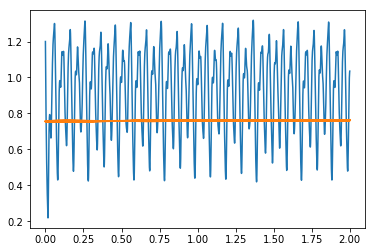

In [118]:
plt.plot(X,Y)
plt.plot(X,Y_pred)